In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import math
import numpy as np
import xlsxwriter
from openpyxl import load_workbook

In [2]:
CURRENT_TEAMS= ["ATL", "BOS", "BRK", "CHI", "CHO", "CLE", "DAL", "DEN", "DET", "GSW", "HOU", "IND", "LAC", "LAL", "MEM", "MIA", "MIL", "MIN", "NOP", "NYK", "OKC", "ORL", "PHI", "PHO", "POR", "SAC", "SAS", "TOR", "UTA", "WAS"]
TEAMS = CURRENT_TEAMS + ["SLH", "TCB", "NJN", "NYN", "CHA", "FWP", "SFW", "SDC", "VAN", "NOK", "NOH", "SEA", "SYR", "KCK", "ROR", "NOJ", "WSB", "CAP", "BAL"]

In [3]:
WESTERN_CONF_TEAMS = ["DAL", "DEN", "GSW", "HOU", "LAC", "LAL", "MEM", "MIN", "NOP", "OKC", "PHO", "POR", "SAC", "SAS", "UTA"]
EASTERN_CONF_TEAMS = ["ATL", "BOS", "BRK", "CHI", "CHO", "CLE", "DET", "IND", "MIA", "MIL", "NYK", "ORL", "PHI", "TOR", "WAS"]

In [4]:
ATLANTIC_DIV_TEAMS = ["BOS", "BRK", "NYK", "PHI", "TOR"]
CENTRAL_DIV_TEAMS = ["CHI", "CLE", "DET", "IND", "MIL"]
SOUTHEAST_DIV_TEAMS = ["ATL", "CHO", "MIA", "ORL", "WAS"]

In [5]:
NORTHWEST_DIV_TEAMS = ["DEN", "MIN", "OKC", "POR", "UTA"]
SOUTHWEST_DIV_TEAM = ["GSW", "LAC", "LAL", "PHO", "SAC"]
PACIFIC_DIV_TEAMS = ["DAL", "HOU", "MEM", "NOP", "SAS"]

In [6]:
SEASONS = [2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]
POSITIONS = ["PG", "SG", "SF", "PF", "C"]

In [7]:
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (28, 18),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

In [8]:
def mean(data):
    return sum(data) / len(data)

In [9]:
def variance(data):
    n = len(data)
    avg = mean(data)
    
    deviations = [(x - avg) ** 2 for x in data]
    
    variance = sum(deviations) / n
    return variance

In [10]:
def std(data):
    var = variance(data)
    std = var ** 0.5
    return std

In [11]:
def growth_rate(data):
    straight_line_growth = []
    
    for i in range(1, len(data)):
        growth = (data[i] - data[i-1]) / data[i-1]
        straight_line_growth.append(growth)
        
    growth_rt = sum(straight_line_growth) / len(straight_line_growth)
    
    return "{:.2f}%".format(growth_rt*100)

In [12]:
def spearman_rank_corr(rank1, rank2):
    d_square = []
    
    if len(rank1) != len(rank2):
        return
    
    n = len(rank1)
    
    for i in range(n):
        d = rank1[i] - rank2[i]
        d_square.append(d ** 2)
    
    return 1 - ((6 * sum(d_square)) / (n * (n ** 2 - 1)))

In [13]:
def calculate_rank_corr_by_team_stat(df, eastern_standings, western_standings, stat):
    
    corr_df = df.sort_values(by=[stat, 'Team'], ascending=[False, True])
    
#     corr_df.set_index('Team', inplace=True)
    
    teams = list(corr_df.index)
    rank = range(1, 31)
    zip_iterator = zip(teams, rank)

    teams_ordered_by_stat = dict(zip_iterator)
    
    standings = merge_standings(eastern_standings, western_standings)
        
    rank1 = []
    rank2 = []
    for team in TEAMS:
        if team in standings:
            rank1.append(teams_ordered_by_stat[team])
            rank2.append(standings[team])

    return spearman_rank_corr(rank1, rank2)

In [14]:
def rank_team_corrs_to_excel(dfs, eastern_standings_dfs, western_standings_dfs, stat):
    corrs = [stat]
    
    n = len(dfs)
    
    for i in range(n):
        corrs.append(calculate_rank_corr_by_team_stat(dfs[i], eastern_standings_dfs[i], western_standings_dfs[i], stat))
        
    wb = load_workbook("DataCollection/Correlation/Rank_Correlation_bench_Players_Stats.xlsx")
    ws = wb.worksheets[0]
    
    ws.append(corrs)
    wb.save("DataCollection/Correlation/Rank_Correlation_bench_Players_Stats.xlsx")

In [15]:
def merge_standings(eastern_standings, western_standings):
    standings = pd.concat([western_standings, eastern_standings])
    standings.sort_values(by=["Made_Playoffs", "W", "Rank", "Team"], ascending=[False, False, True, True], inplace=True)
    standings.reset_index(inplace=True)
    standings.drop('index', axis=1, inplace=True)
    standings.index += 1
    teams_ranked = dict(standings["Team"])
    inv_teams_ranked = {v: k for k, v in teams_ranked.items()}
    return inv_teams_ranked

In [16]:
def format_season(season):
        #Formats years in season to use in File Name
        #Ex: 2021 turns into 2020-21
        first_year = season-1
        second_year = str(season)[2:]
        
        return first_year, second_year

In [17]:
def get_csvs_by_season(season):
    first_year, second_year = format_season(season)
    
    player_df = pd.read_csv("DataCollection/Player_Stats/player_stats_{0}-{1}.csv".format(first_year, second_year))
    team_df = pd.read_csv("DataCollection/Team_Stats/team_stats_{0}-{1}.csv".format(first_year, second_year))
    adv_team_df = pd.read_csv("DataCollection/Advanced_Team_Stats/adv_team_stats_{0}-{1}.csv".format(first_year, second_year))
    opponent_df = pd.read_csv("DataCollection/Opponent_Stats/opponent_stats_{0}-{1}.csv".format(first_year, second_year))
    eastern_standings_df = pd.read_csv("DataCollection/Standings/standings_eastern_conference_{0}-{1}.csv".format(first_year, second_year))
    western_standings_df = pd.read_csv("DataCollection/Standings/standings_western_conference_{0}-{1}.csv".format(first_year, second_year))
    
    return player_df, team_df, adv_team_df, opponent_df, eastern_standings_df, western_standings_df

In [18]:
def get_playoff_csvs_by_season(season):
    first_year, second_year = format_season(season)
    
    player_df = pd.read_csv("DataCollection/Player_Stats_Playoffs/player_stats_playoffs_{0}-{1}.csv".format(first_year, second_year))    
#     standings_df = pd.read_csv("DataCollection/Standings_Playoffs/playoff_standings_{0}-{1}.csv".format(first_year, second_year))
    
    return player_df#, standings_df

In [19]:
player_dfs, team_dfs, adv_team_dfs, opponent_dfs, eastern_standings_dfs, western_standings_dfs = [], [], [], [], [], []

for season in SEASONS:
    player_df, team_df, adv_team_df, opponent_df, eastern_standings_df, western_standings_df = get_csvs_by_season(season)
    player_dfs.append(player_df)
    team_dfs.append(team_df)
    adv_team_dfs.append(adv_team_df)
    opponent_dfs.append(opponent_df)
    eastern_standings_dfs.append(eastern_standings_df)
    western_standings_dfs.append(western_standings_df)

In [20]:
df = player_dfs[18].sort_values(by=['Tm', 'GS'], ascending=[True, False])

In [21]:
bench_per_season = []

for i in range(len(SEASONS)):    
    games_in_season = team_dfs[i]["G"][0]
    df = player_dfs[i].sort_values(by=['Tm', 'GS'], ascending=[True, False])
    df.insert(len(df.columns), "Count", 0)
    cols = df.columns    
    bench = pd.DataFrame(columns = cols)
    for team in TEAMS:
        bench_players = pd.DataFrame(df[df["Tm"] == team][5:])
        bench_players = bench_players[bench_players["G"] > games_in_season/2]
        number_of_qualifying_reserves = bench_players.shape[0]
        bench_players = bench_players.mean()
        bench_players["Count"] = number_of_qualifying_reserves
        bench.loc[team] = bench_players

    bench.drop(["Player", "Pos", "Tm"], axis=1, inplace=True)
    bench.index.names = ["Team"]
    bench_per_season.append(bench)

In [22]:
calculate_rank_corr_by_team_stat(pd.DataFrame(bench_per_season[18]["MP"]), eastern_standings_dfs[18], western_standings_dfs[18], "MP")

-0.6040044493882091

In [23]:
# stats = ['Age', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P',
#        '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST',
#        'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%',
#        'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS',
#        'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP', 'Salary', 'Count']

# for stat in stats:
#     rank_team_corrs_to_excel(bench_per_season, eastern_standings_dfs, western_standings_dfs, stat)

In [24]:
stats = ['Age', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P',
       '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST',
       'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%',
       'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS',
       'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP', 'Salary', 'Count']

bench_avg_per_season = {}


for stat in stats:
    bench_avg_per_season[stat] = []
    for df in bench_per_season:
        bench_avg_per_season[stat].append(df[stat].mean())

In [25]:
def round_closest_half(n):
    return round(n * 2) / 2

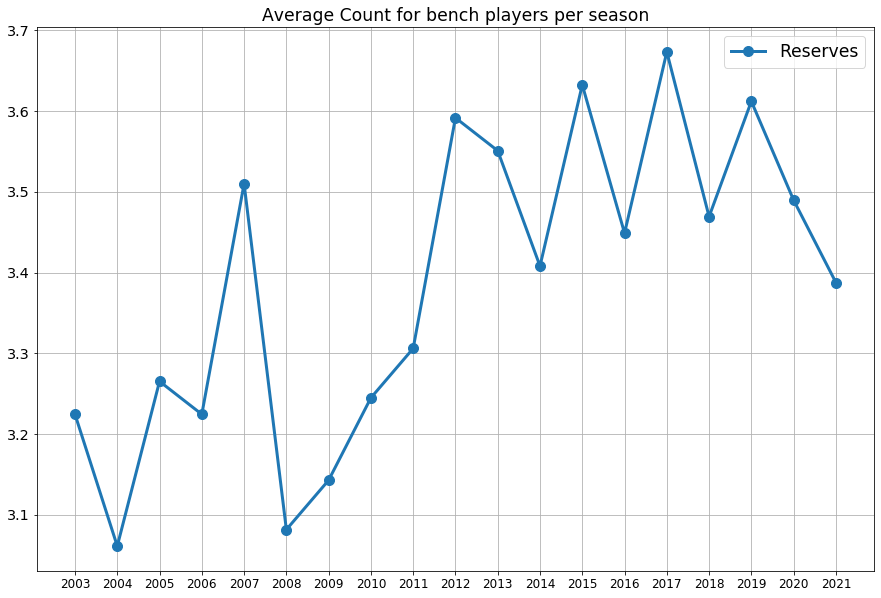

In [26]:


plt.figure(figsize=(15,10))
plt.grid()
plt.plot(SEASONS, bench_avg_per_season["Count"], label="Reserves", lw=3, marker='o', ms=10)
plt.xticks(SEASONS)
plt.title(f"Average {stat} for bench players per season")
plt.legend()
plt.show()

In [27]:
bench_corr = pd.read_excel("DataCollection/Correlation/Rank_Correlation_bench_Players_Stats.xlsx")
bench_corr.set_index("Stat", inplace=True)
bench_corr

2003      2004      2005      2006      2007      2008      2009  \
Stat                                                                           
Age     0.612315  0.540394  0.252948  0.539043  0.448276  0.117686  0.062514   
G       0.128079  0.336946  0.122581  0.227141  0.375306  0.138598  0.440712   
GS     -0.365517 -0.573399 -0.425139 -0.466073 -0.305451 -0.692547 -0.521691   
MP     -0.322167 -0.345813 -0.484316 -0.412236 -0.104783 -0.474527 -0.325028   
FG     -0.244828 -0.092611 -0.473192 -0.349499 -0.166185 -0.281869 -0.192436   
FGA    -0.385714 -0.214286 -0.503448 -0.354394 -0.136819 -0.393548 -0.188877   
FG%     0.240394  0.170936  0.273860 -0.097664 -0.038932  0.397998  0.114572   
3P     -0.118719  0.024631 -0.241379  0.174638  0.361513 -0.034483  0.196440   
3PA    -0.187685 -0.007389 -0.224027  0.211123  0.357953 -0.058954  0.167075   
3P%     0.263054 -0.017241 -0.250723  0.154616  0.263626  0.078977  0.231146   
2P     -0.154680 -0.128571 -0.440267 -0.475862 -0.344605 -0.320578 -0.288098   
2PA    -0.257635 -0.171921 -0.474082 -0.464739 -0.393993 -0.417575 -0.341935   
2P%     0.224138  0.234975  0.319689  0.015350  0.046051  0.322803 -0.034483   
eFG%    0.368966  0.305419  0.156841  0.107453  0.270745  0.497664  0.423359   
FT     -0.061084 -0.125123 -0.233370 -0.552836 -0.348165 -0.127030 -0.051390   
FTA    -0.154680 -0.226108 -0.258732 -0.564850 -0.381090 -0.195106 -0.053615   
FT%     0.426108  0.141379  0.000667 -0.237375  0.087430 -0.058065 -0.199555   
ORB    -0.159606 -0.108867  0.009566 -0.255617 -0.076752 -0.220912 -0.043382   
DRB    -0.316256 -0.197044 -0.303671 -0.280089  0.159511 -0.249833  0.091435   
TRB    -0.264039 -0.128079 -0.334372 -0.316129  0.126585 -0.279199  0.058954   
AST    -0.028571 -0.144828 -0.393103  0.025139 -0.290323 -0.222247 -0.277864   
STL    -0.054680 -0.045813 -0.159511 -0.442047 -0.174194  0.064294 -0.067853   
BLK    -0.147291 -0.106897  0.069188 -0.128365  0.074082  0.104783 -0.038932   
TOV    -0.642857 -0.253695 -0.389989 -0.479422 -0.512347 -0.385095 -0.315239   
PF     -0.291626 -0.186700 -0.374861 -0.684983 -0.397108 -0.361958 -0.278754   
PTS    -0.203941 -0.110345 -0.432258 -0.347275 -0.164850 -0.256952 -0.086541   
PER     0.319212  0.235468  0.022914  0.087430  0.253393  0.366852  0.248498   
TS%     0.394089  0.409852  0.196885 -0.052280  0.122136  0.479422  0.422469   
3PAr    0.005911  0.103941  0.043382  0.297887  0.446051  0.170189  0.320133   
FTr    -0.009852 -0.086700  0.269855 -0.437597 -0.430033 -0.023359  0.122581   
ORB%   -0.050246  0.090640  0.231591  0.016685  0.063849  0.079422  0.322803   
DRB%   -0.391626 -0.055665 -0.123915 -0.150612  0.248943 -0.036707  0.349944   
TRB%   -0.198522  0.028079  0.032258 -0.009566  0.242714  0.094994  0.402892   
AST%   -0.049261  0.027586 -0.337931  0.288098 -0.198220 -0.038487 -0.339711   
STL%   -0.014286  0.260591  0.116796 -0.074082 -0.075417  0.368187  0.194216   
BLK%   -0.114286  0.026601  0.243604 -0.027809  0.058065  0.269410  0.097664   
TOV%   -0.481281  0.006897  0.009566 -0.223582 -0.486541 -0.206674 -0.119021   
USG%   -0.225123  0.001478 -0.375751 -0.084316 -0.044716 -0.080311 -0.006897   
OWS     0.533498  0.394089  0.208009  0.122581  0.297442  0.487875  0.314349   
DWS     0.500000  0.584236  0.455395  0.584427  0.705451  0.684093  0.894105   
WS      0.699507  0.718719  0.440267  0.525695  0.670745  0.686763  0.692992   
WS/48   0.771429  0.808867  0.650278  0.729032  0.790879  0.814461  0.830033   
OBPM    0.381773  0.233498 -0.037152  0.081646  0.309455  0.401112  0.253393   
DBPM    0.490148  0.570443  0.628921  0.487430  0.712570  0.844271  0.722358   
BPM     0.555665  0.637931  0.428699  0.464739  0.701891  0.741046  0.640044   
VORP    0.584729  0.603448  0.397108  0.478532  0.703226  0.712125  0.655617   
Salary  0.288670  0.099261 -0.191546  0.004672  0.164850 -0.254283  0.016685   
Count   0.221675  0.141379  0.062069  0.006452 -0.089210  0.090990  0.373526   

           

In [28]:
starters_corr = pd.read_excel("DataCollection/Correlation/Rank_Correlation_Starters_Stats.xlsx")
starters_corr.set_index("Stat", inplace=True)
starters_corr

2003      2004      2005      2006      2007      2008      2009  \
Stat                                                                           
Age     0.368473  0.376847  0.294772  0.471413  0.537709  0.443382  0.436263   
G       0.117241  0.550739  0.406897  0.338821  0.435373  0.558176  0.245829   
GS      0.397044  0.705911  0.539043  0.531034  0.488765  0.642269  0.632481   
MP      0.198522  0.064039  0.307675  0.255617  0.094994  0.233370 -0.168409   
FG      0.440887 -0.001478  0.347720  0.305451  0.285873  0.305895  0.076307   
FGA     0.222167 -0.149754  0.265406  0.164850  0.138598  0.144828 -0.243604   
FG%     0.458128  0.444828  0.408231  0.511457  0.249833  0.449166  0.567964   
3P      0.364532 -0.081281  0.498999  0.113237  0.066073  0.404227  0.094994   
3PA     0.352217 -0.146305  0.461624  0.125695  0.007341  0.410901 -0.011791   
3P%     0.295074 -0.127586  0.414905 -0.011346  0.101669  0.102113  0.338821   
2P      0.243842  0.085714  0.203560  0.341935  0.271190  0.131034  0.015795   
2PA     0.048276 -0.059606  0.032258  0.171969  0.043826 -0.191101 -0.238710   
2P%     0.591133  0.466010  0.466073  0.535929  0.306340  0.547497  0.574194   
eFG%    0.625123  0.501970  0.647608  0.482091  0.301001  0.601780  0.650723   
FT      0.165025 -0.070936  0.270300  0.208454  0.145717  0.183982 -0.079867   
FTA     0.127094 -0.031527  0.305006  0.231146  0.064294  0.079867 -0.048721   
FT%     0.001478  0.060099  0.000667  0.011791  0.094549  0.242269 -0.107453   
ORB    -0.257635 -0.083744 -0.089655  0.082091 -0.109677 -0.107898 -0.018910   
DRB     0.525616  0.391133  0.368632  0.446496  0.279644  0.170634  0.103448   
TRB     0.350246  0.261576  0.259622  0.416240  0.213348  0.068298  0.063849   
AST     0.431034  0.394581  0.399333  0.205339  0.452725  0.414016  0.168854   
STL     0.247783  0.193103  0.216463  0.299666  0.075862  0.276974  0.190211   
BLK     0.097044  0.295074  0.327253  0.508343  0.174194  0.095884  0.268076   
TOV    -0.076355 -0.382266  0.115462 -0.065184 -0.131034 -0.261846 -0.422024   
PF     -0.464039 -0.350246 -0.158621 -0.014905 -0.173749 -0.070523 -0.365517   
PTS     0.405419 -0.066995  0.409121  0.284093  0.219132  0.305451  0.028254   
PER     0.689655  0.608867  0.649833  0.682314  0.560845  0.705895  0.708120   
TS%     0.590148  0.404926  0.544828  0.551057  0.363293  0.589766  0.555951   
3PAr    0.452217  0.073399  0.549277  0.095884  0.147497  0.473192  0.113237   
FTr     0.027094 -0.029557  0.002447  0.174638  0.069633 -0.001112  0.135039   
ORB%   -0.268966 -0.133005 -0.228476 -0.192436 -0.119911 -0.074972  0.084761   
DRB%    0.316256  0.573892  0.029588  0.171079  0.125695 -0.150612  0.049611   
TRB%    0.085714  0.330049  0.042492  0.160845  0.086541 -0.063849  0.185762   
AST%    0.325616  0.368966  0.326363  0.145273  0.543938  0.389989  0.236040   
STL%    0.234483  0.169458  0.132369  0.252058  0.087875  0.276974  0.236040   
BLK%   -0.050739  0.278325  0.276085  0.387319  0.118576  0.018910  0.245384   
TOV%   -0.190148 -0.400985 -0.325473 -0.345495 -0.253393 -0.258732 -0.298776   
USG%    0.169951 -0.334975  0.243159  0.100334  0.086986 -0.044271 -0.097664   
OWS     0.645813  0.578325  0.616908  0.644494  0.543048  0.757063  0.826919   
DWS     0.653202  0.628571  0.709010  0.791324  0.771301  0.881646  0.851835   
WS      0.883744  0.896059  0.816240  0.878977  0.859399  0.912347  0.934149   
WS/48   0.900000  0.933990  0.896774  0.890545  0.890990  0.930145  0.929700   
OBPM    0.684729  0.535468  0.625806  0.535929  0.451390  0.697442  0.732592   
DBPM    0.533990  0.695567  0.691657  0.773971  0.789099  0.804227  0.841602   
BPM     0.861576  0.882266  0.878977  0.818465  0.834928  0.909232  0.871858   
VORP    0.884236  0.868966  0.849611  0.839377  0.831813  0.932814  0.898999   
Salary -0.330542 -0.171921 -0.135039  0.306785  0.265406  0.151502  0.286318   

            2010      2011      2012      2013      2014      2015      2016  \
Stat       

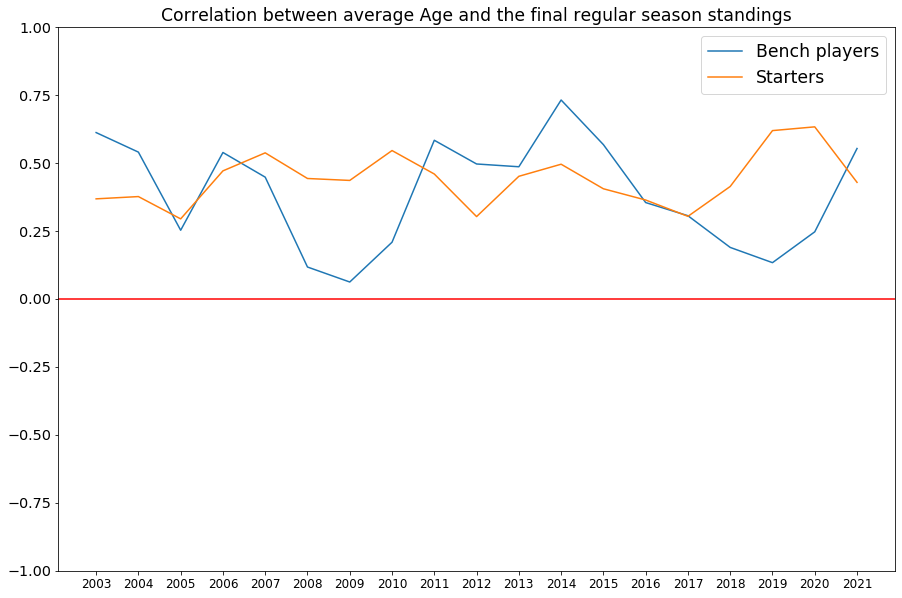

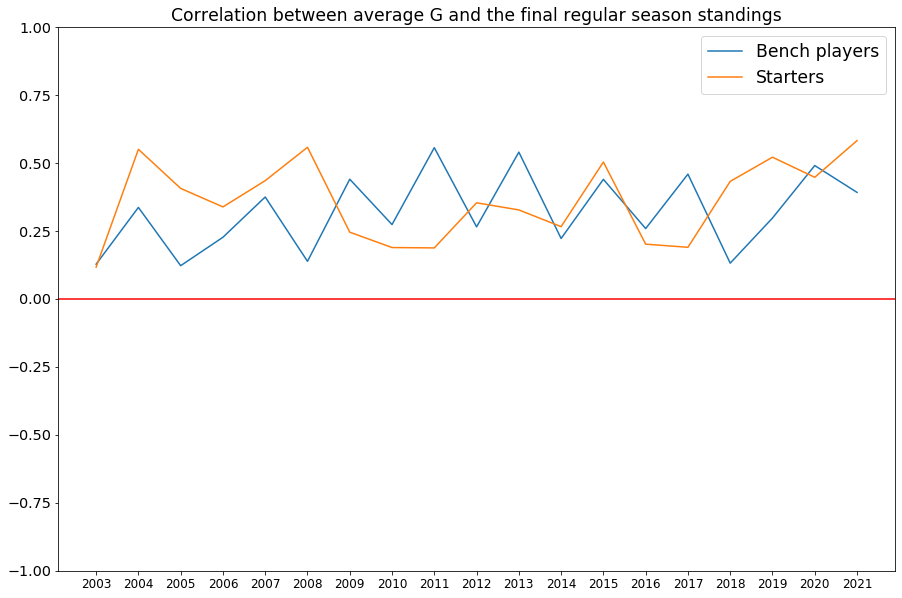

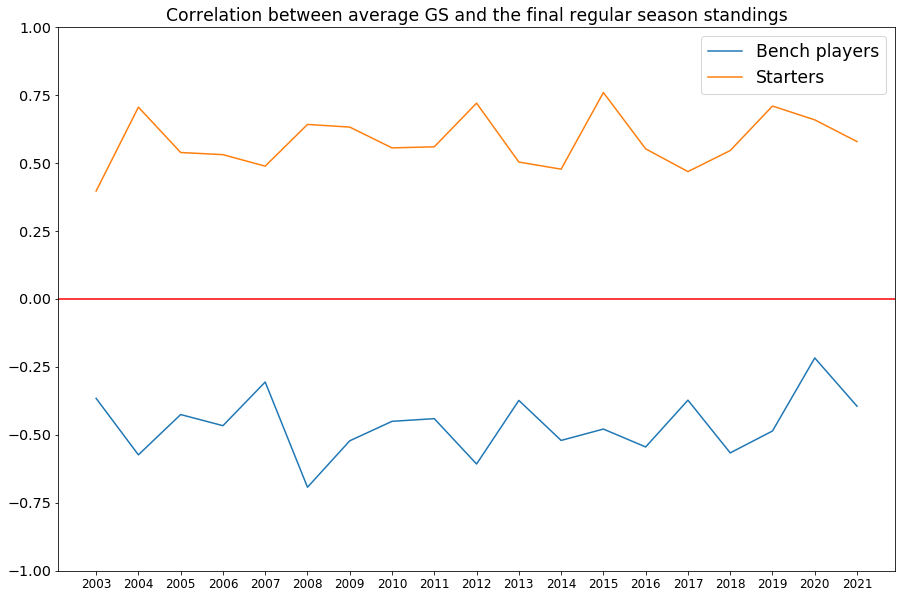

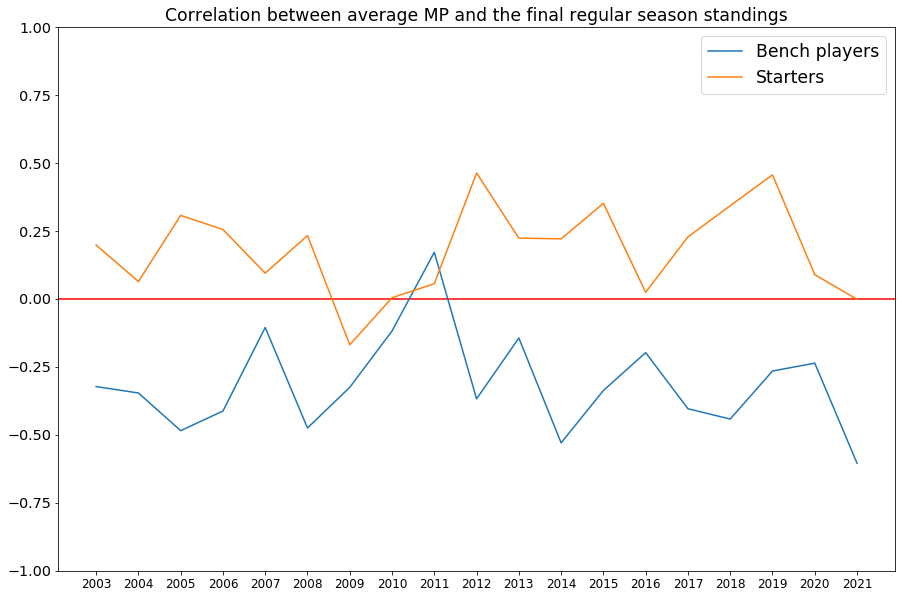

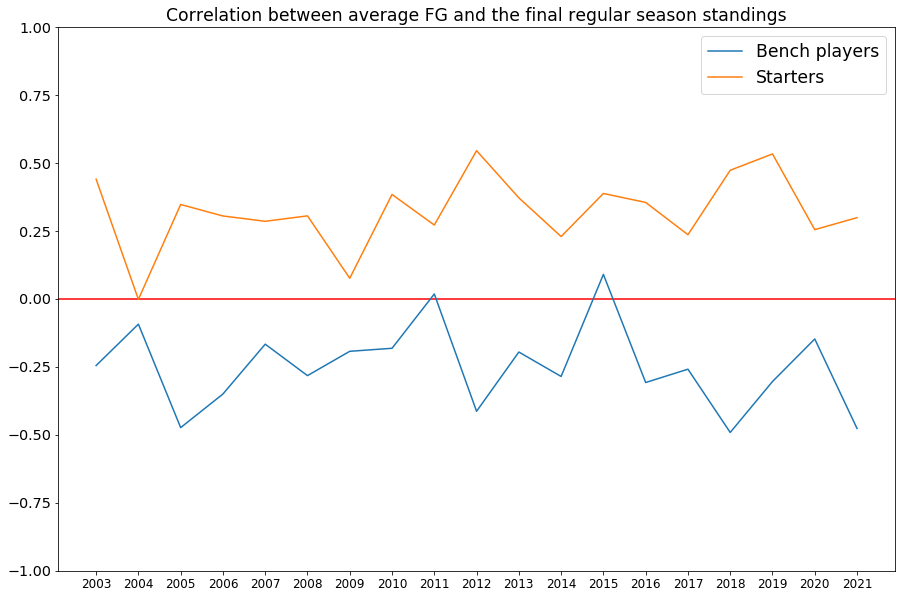

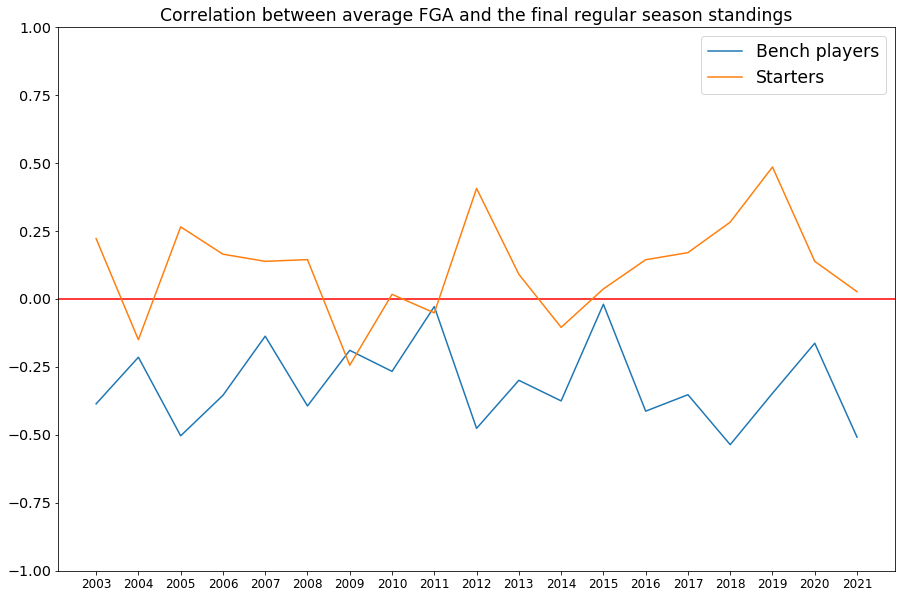

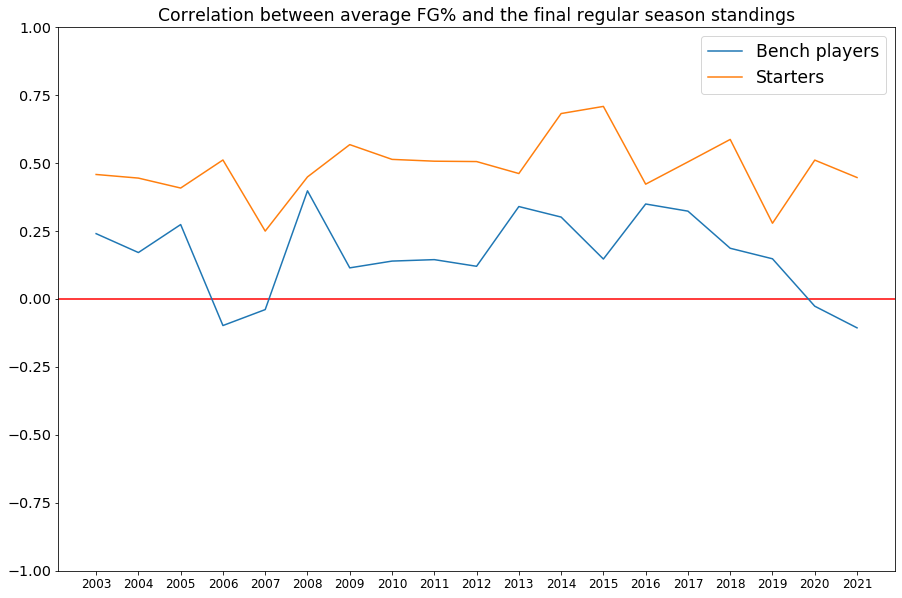

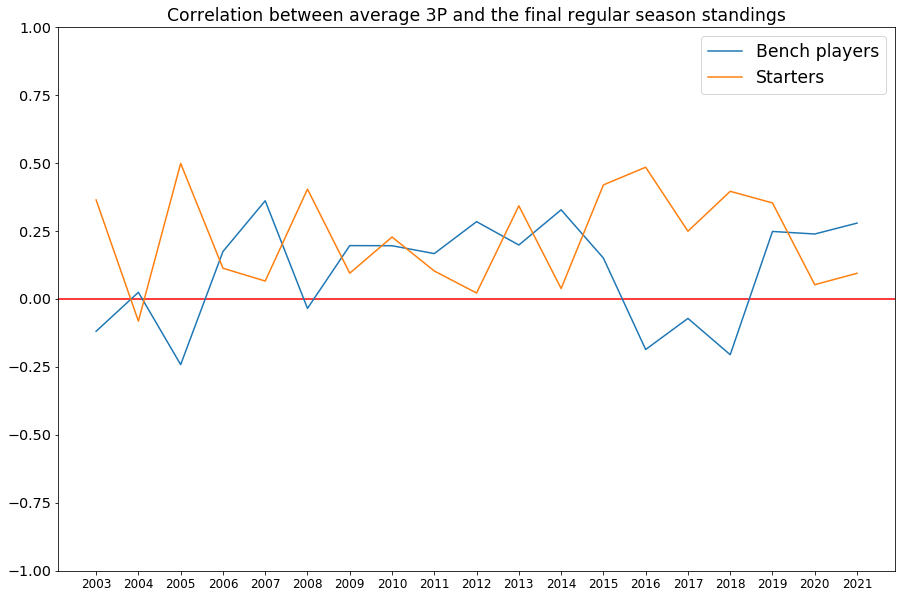

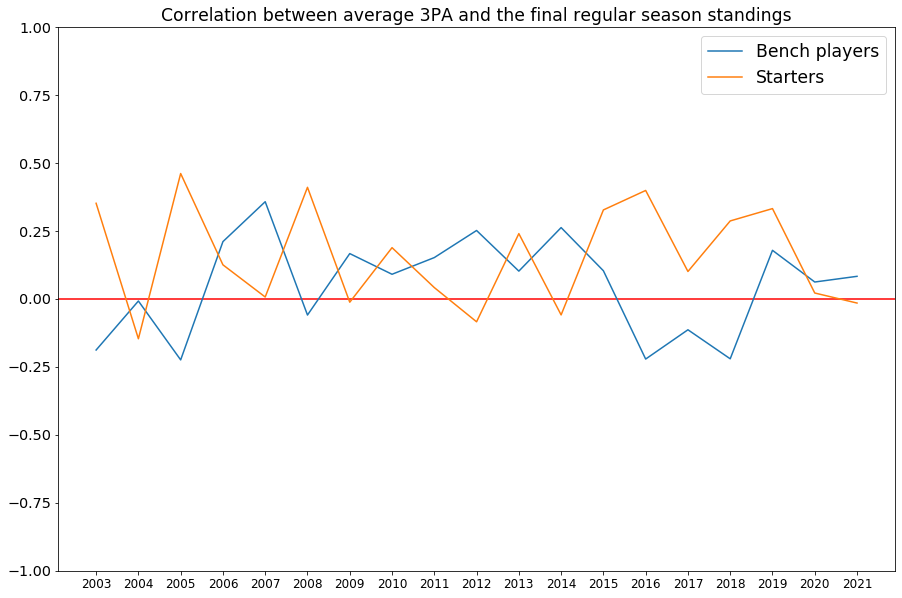

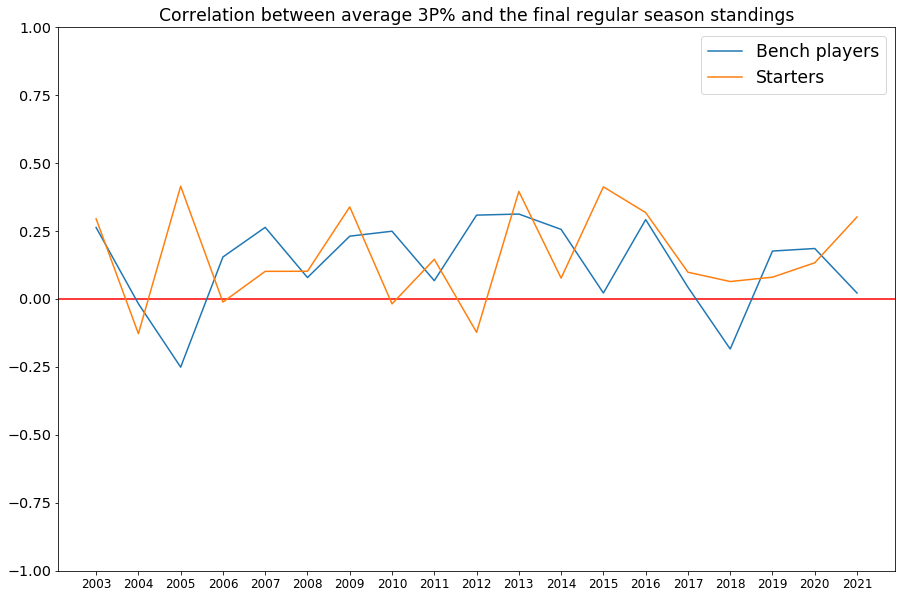

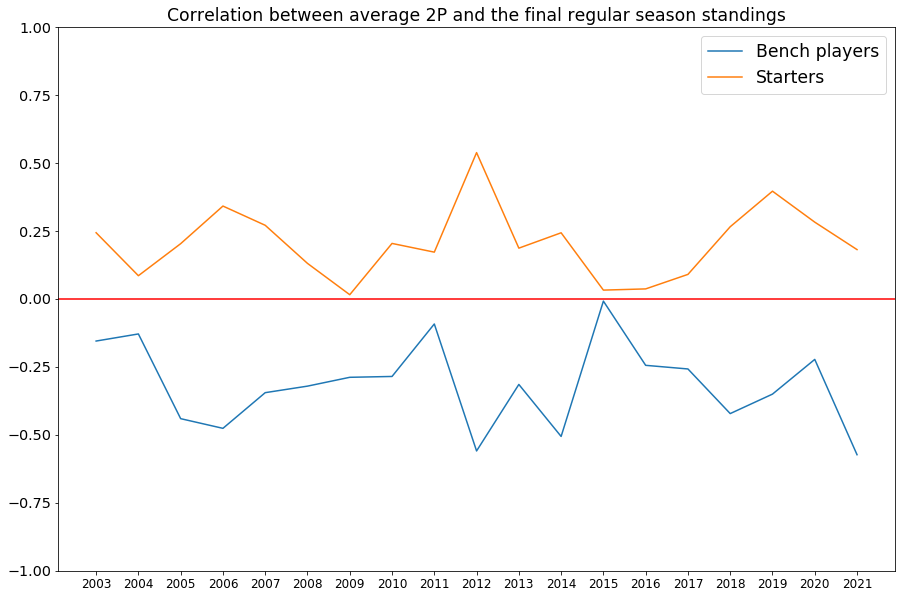

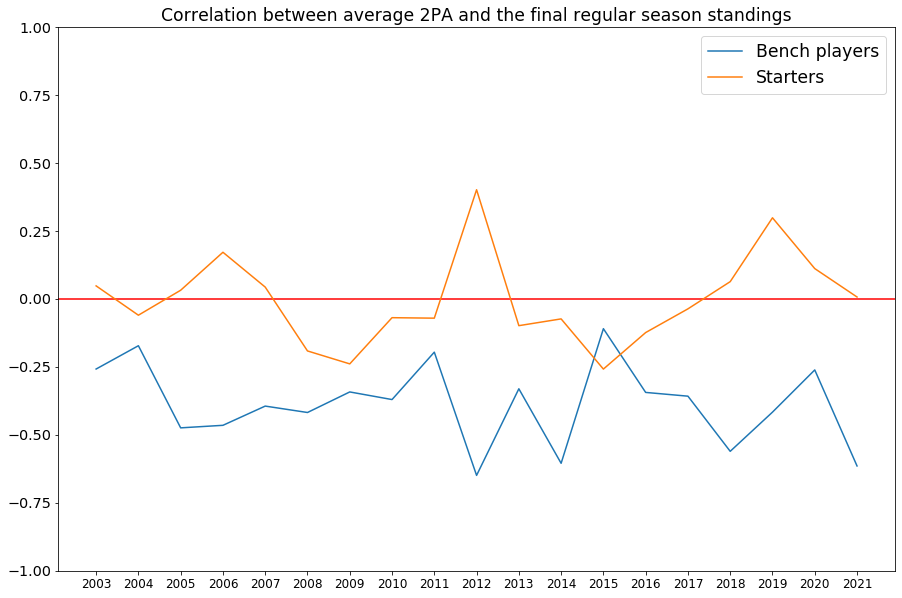

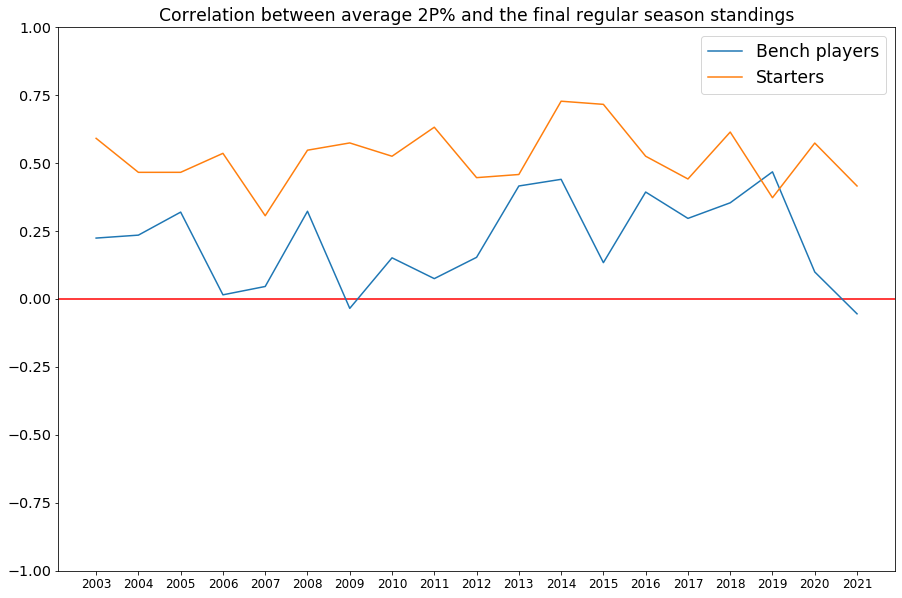

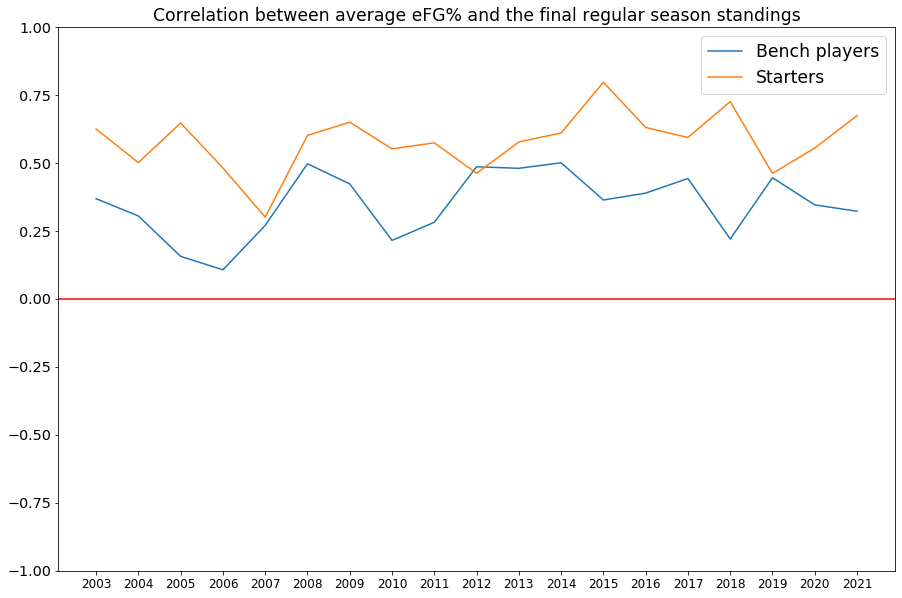

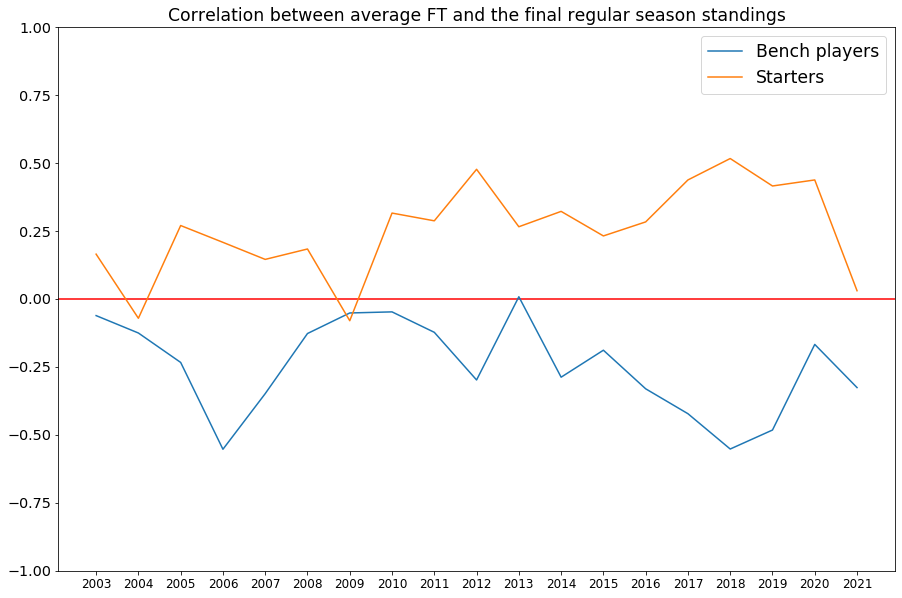

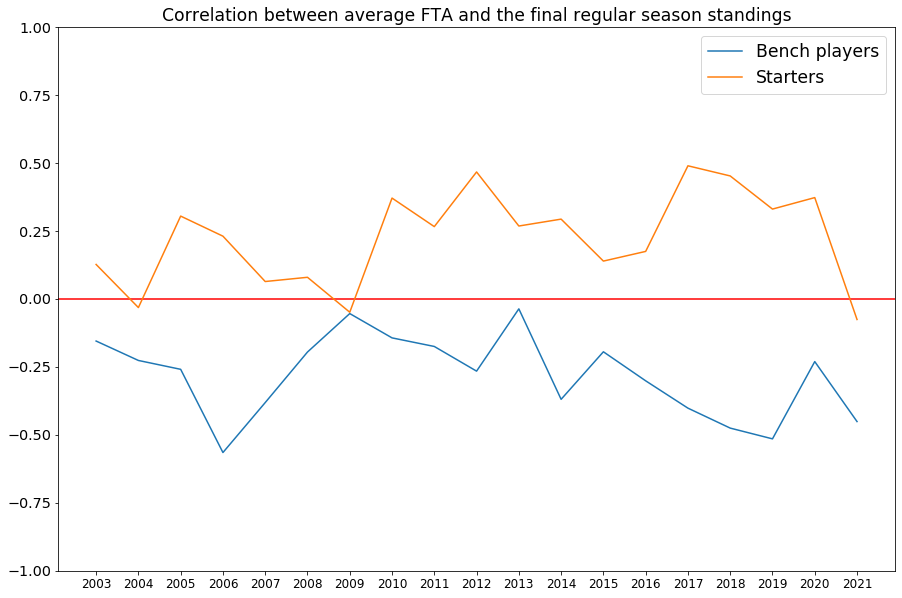

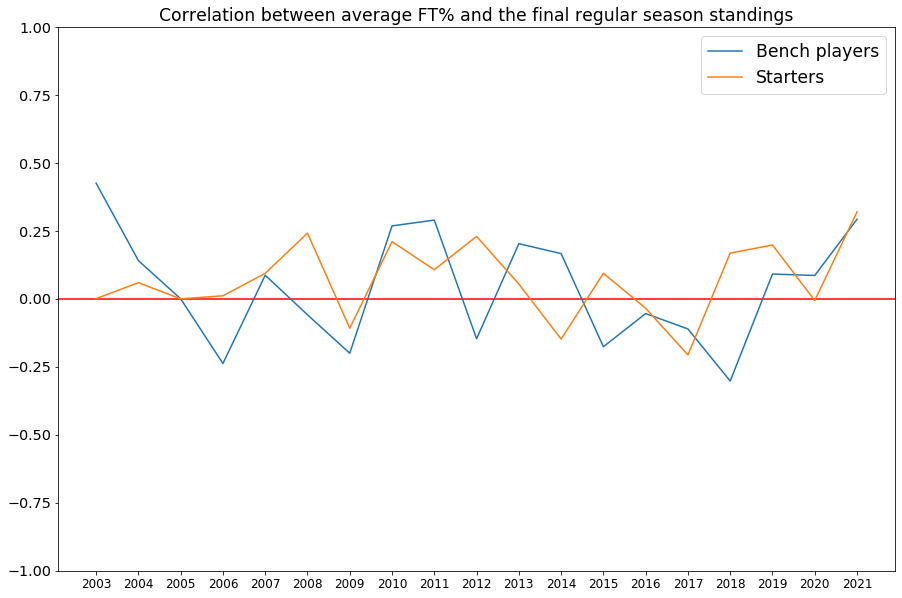

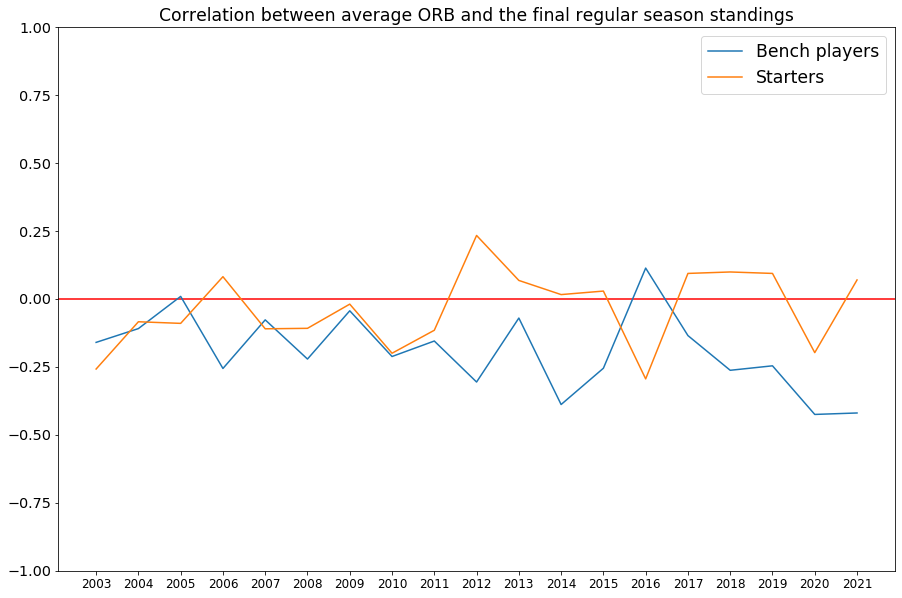

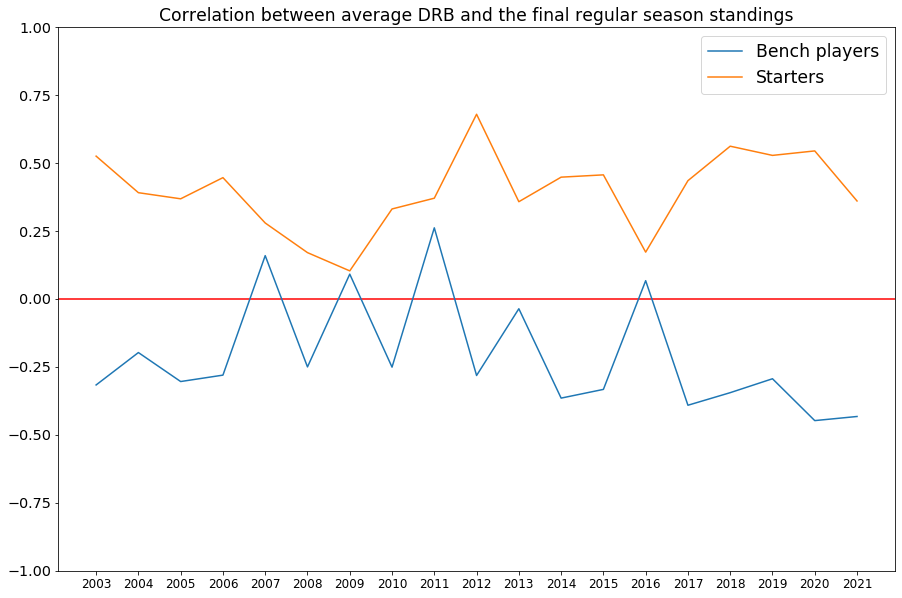

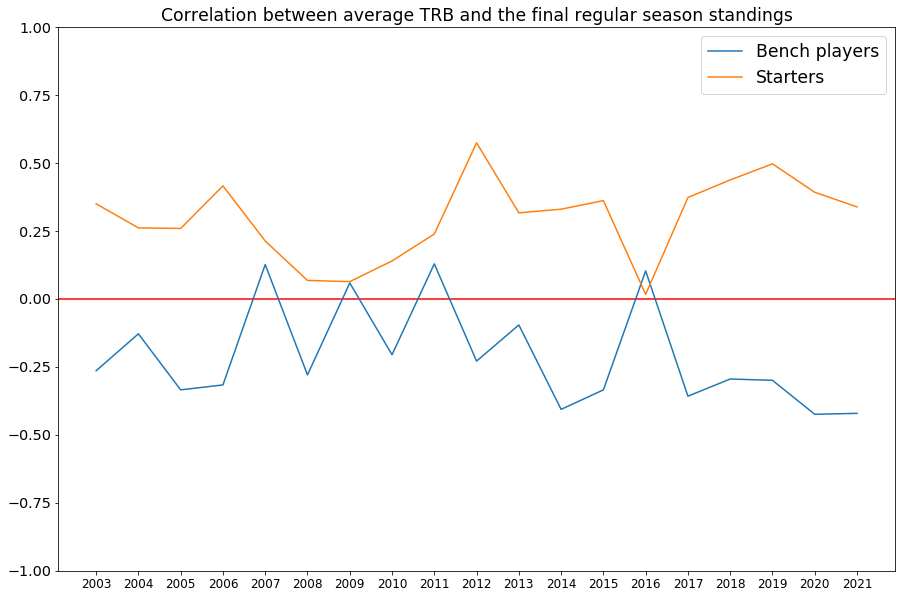

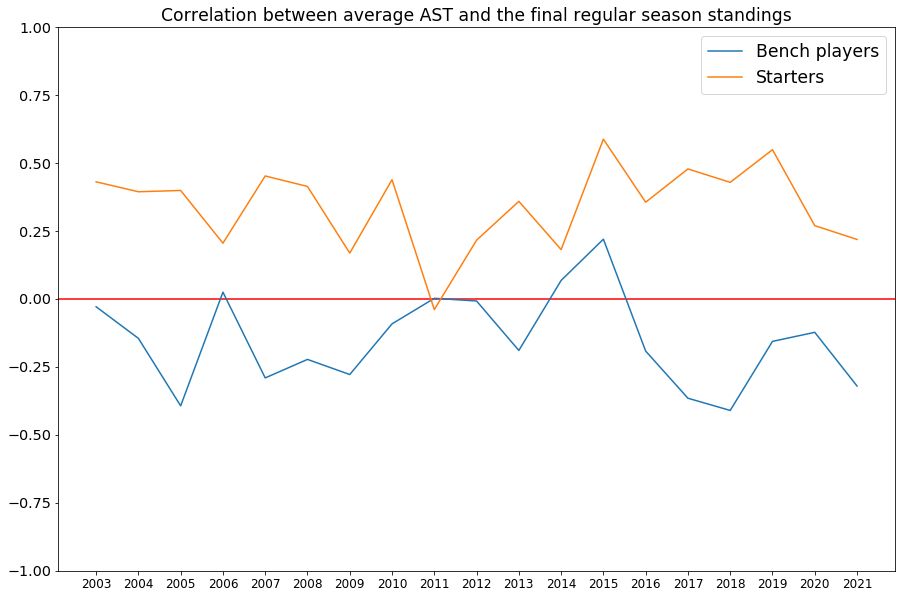

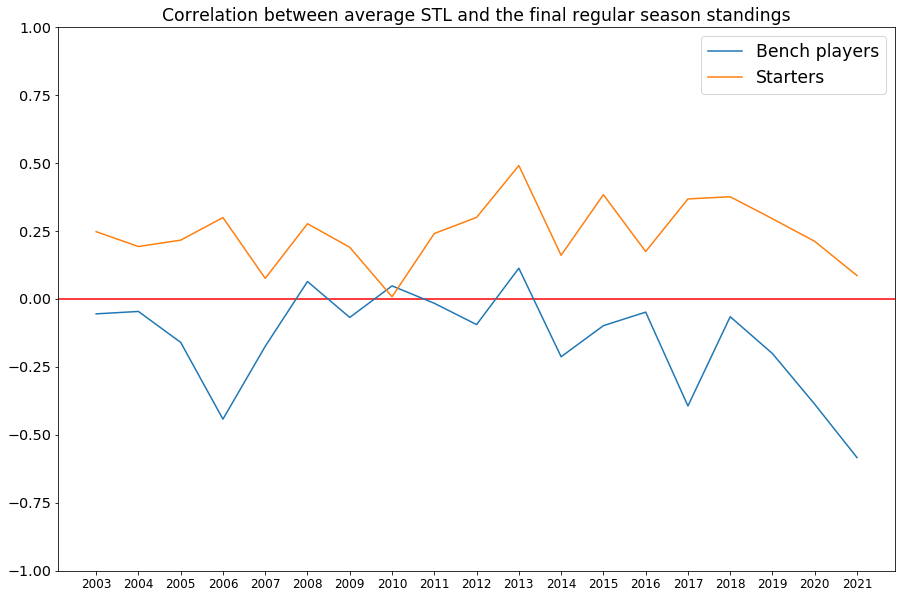

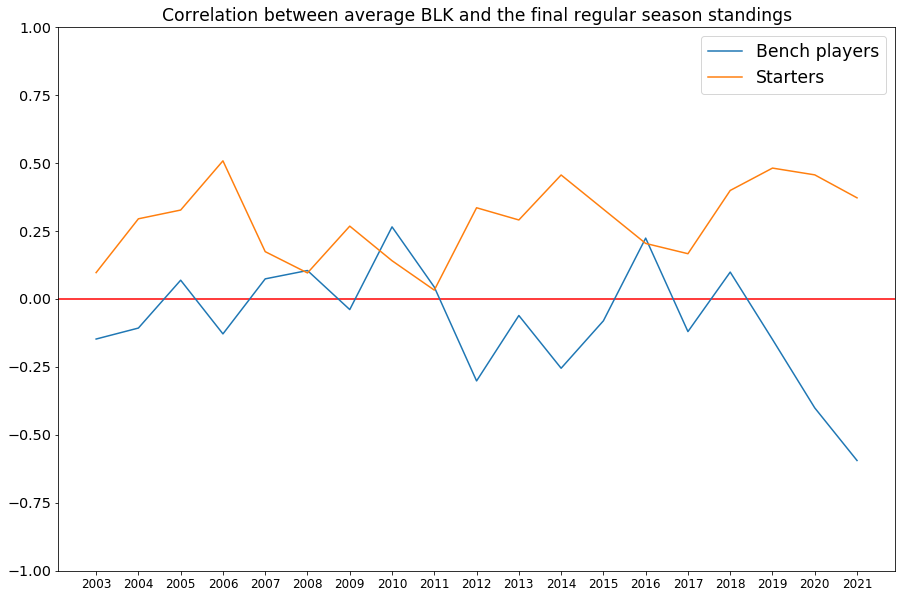

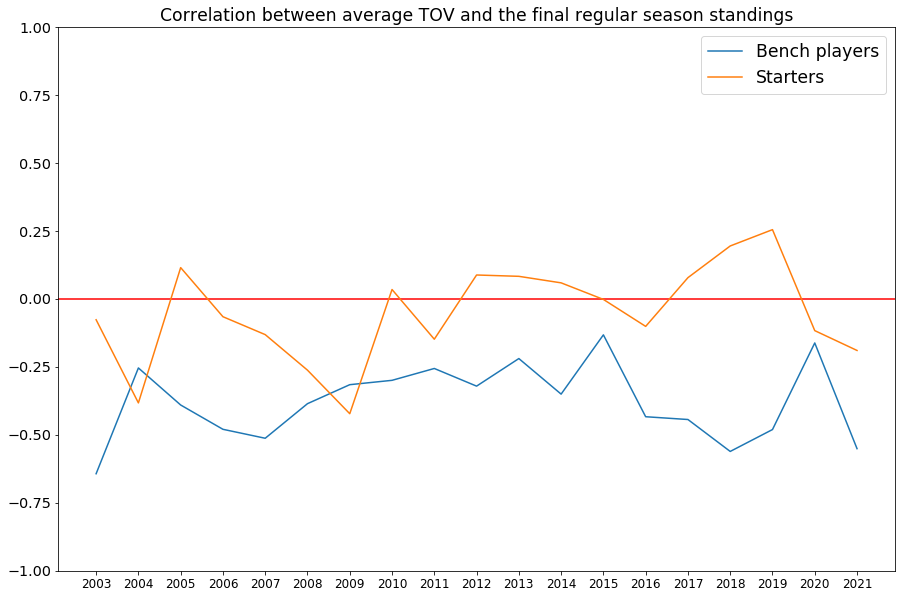

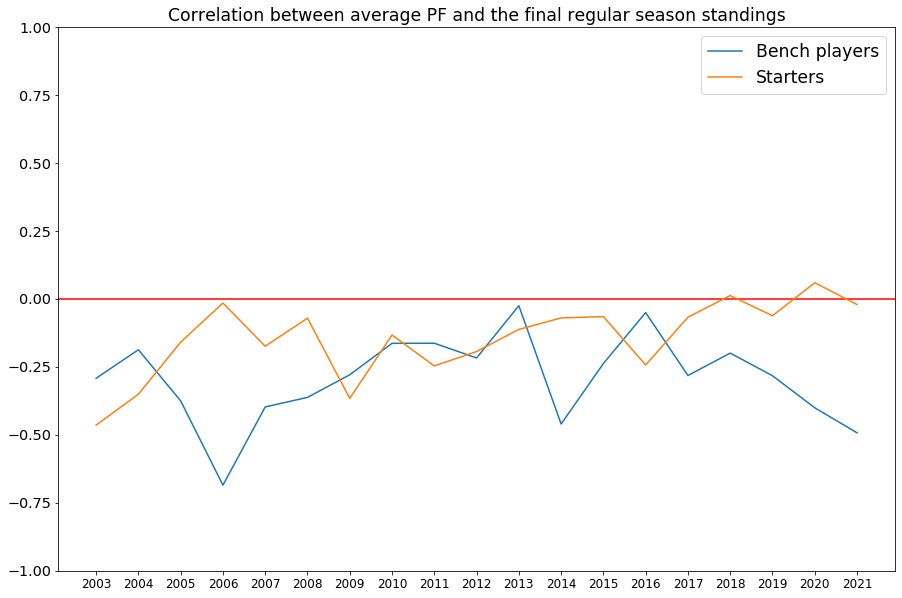

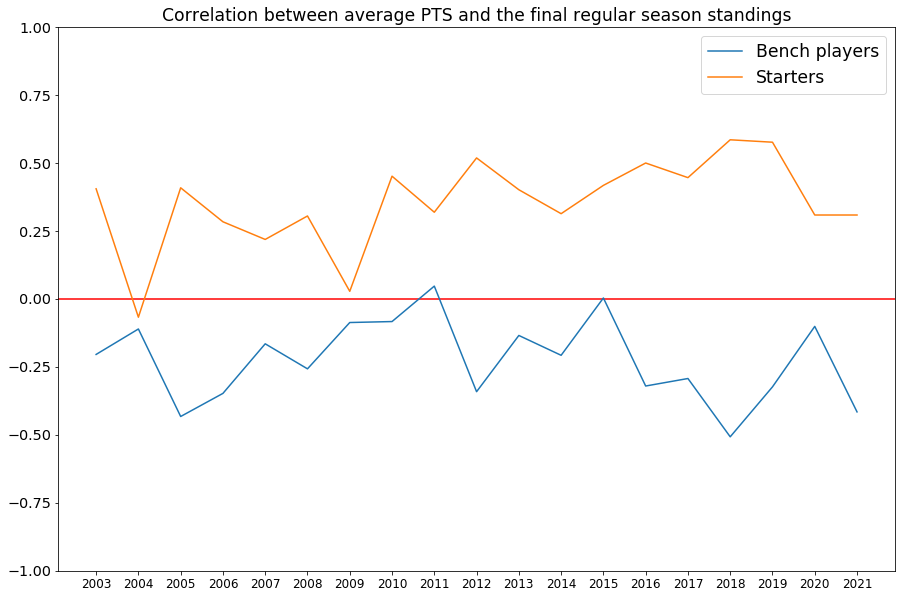

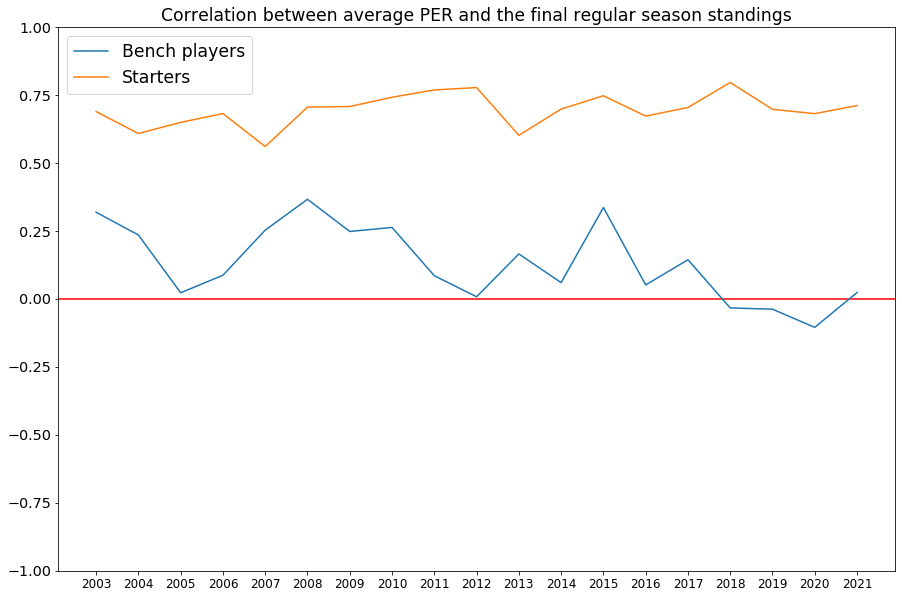

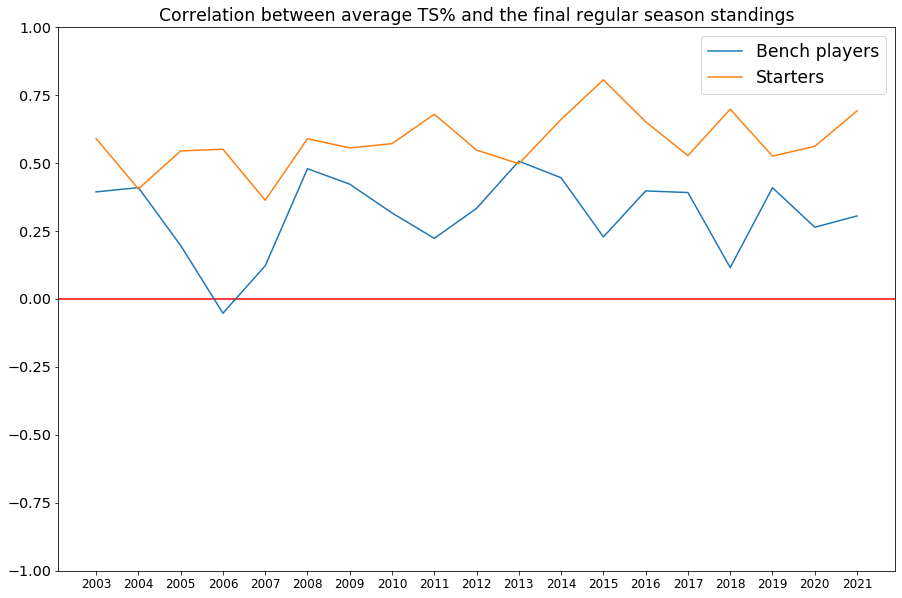

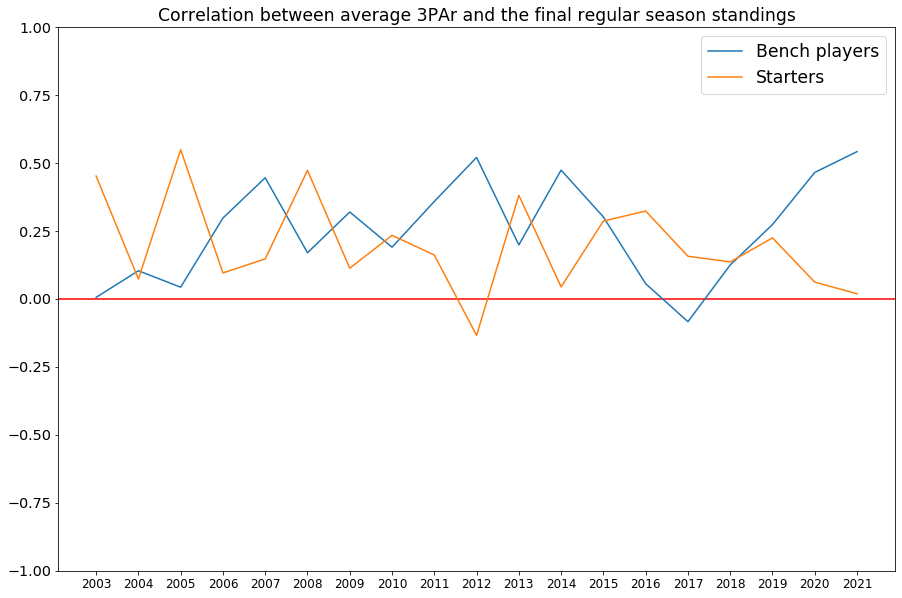

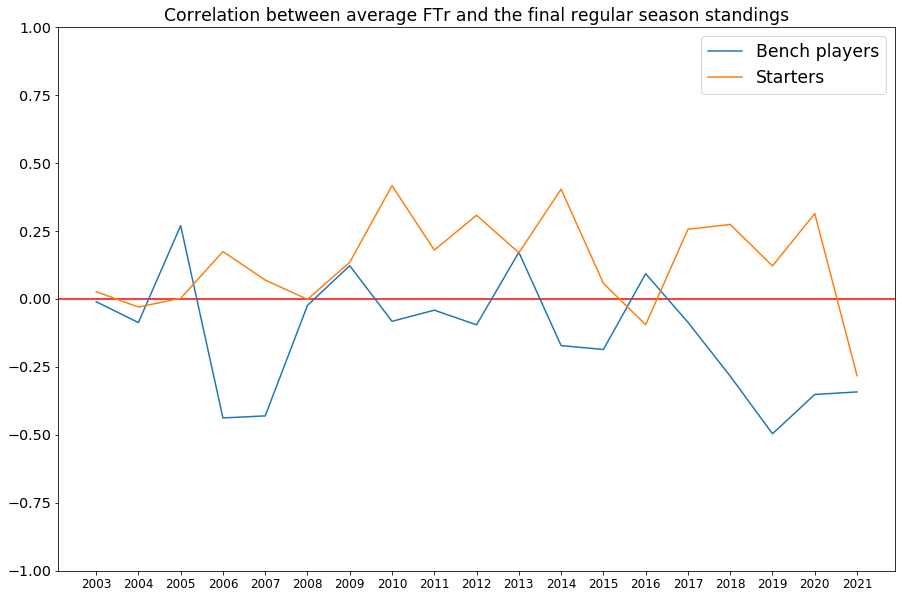

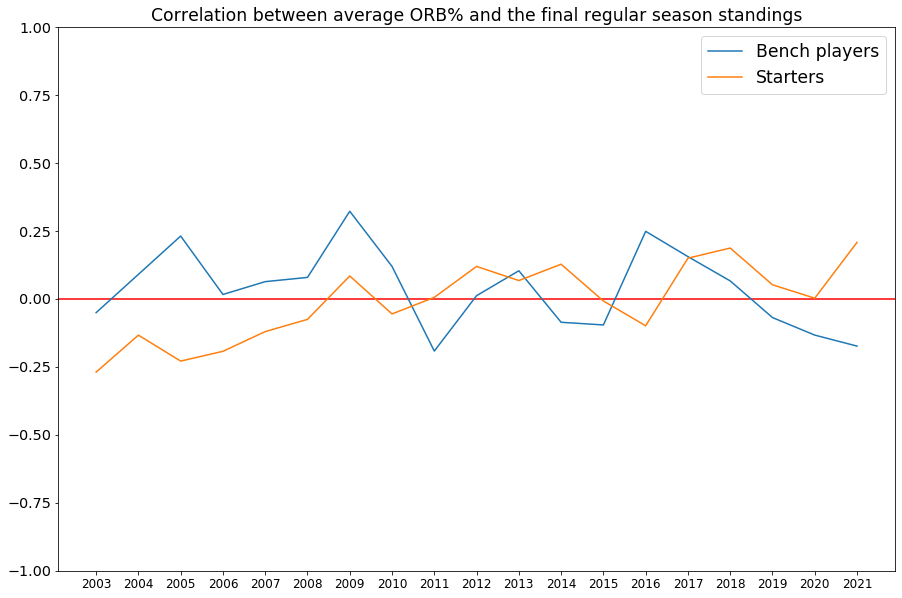

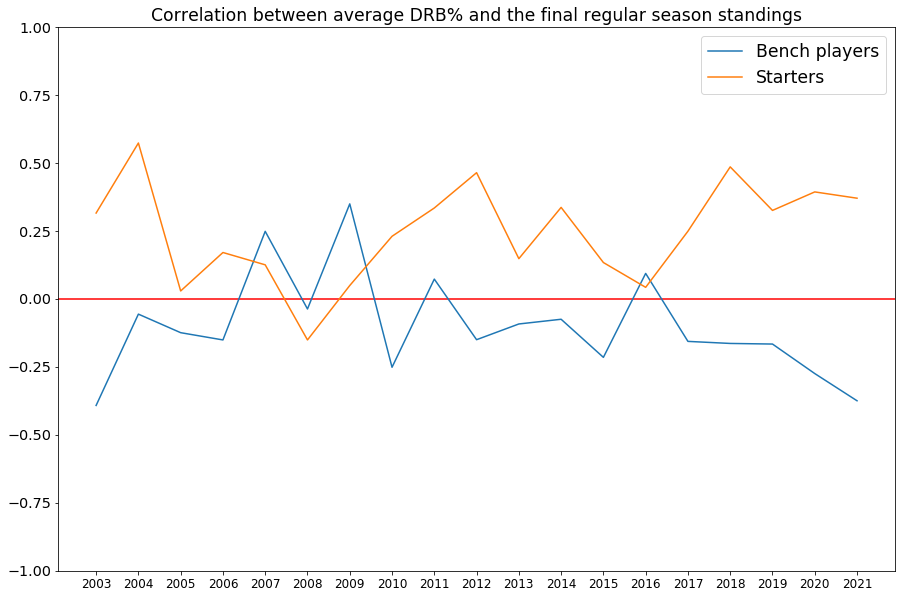

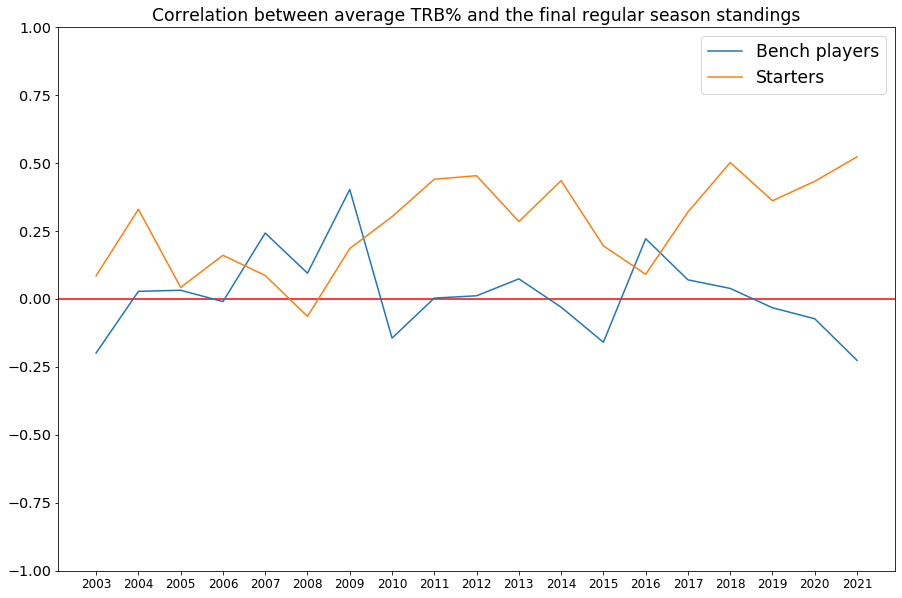

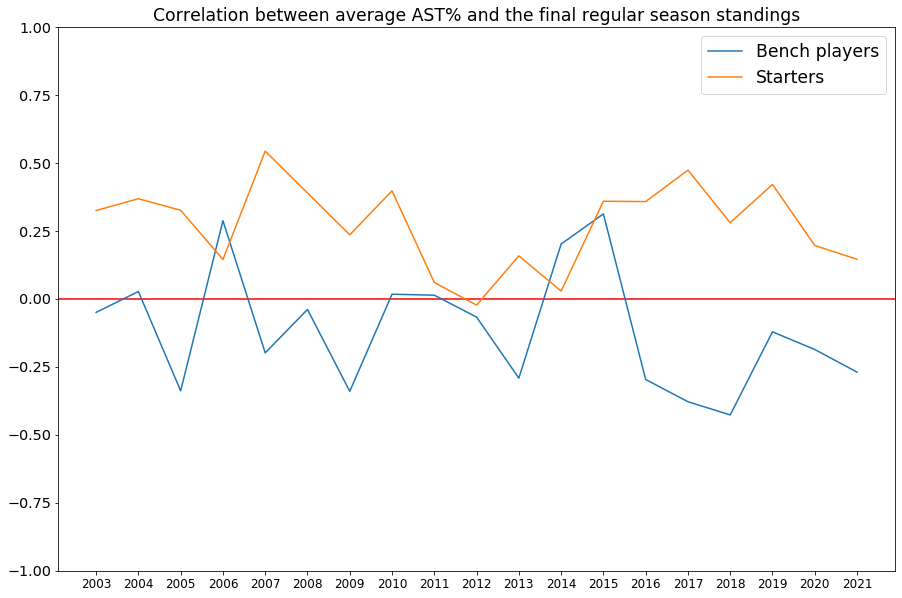

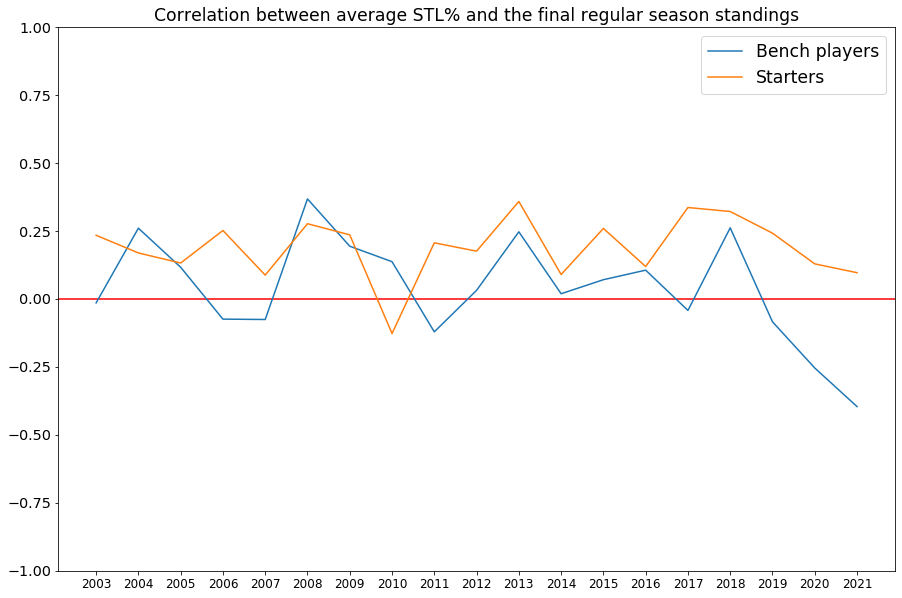

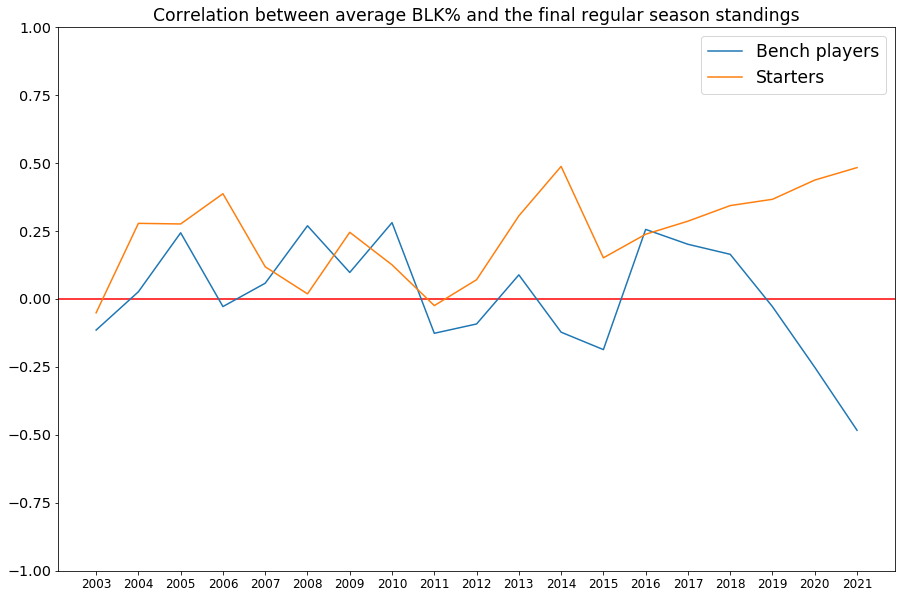

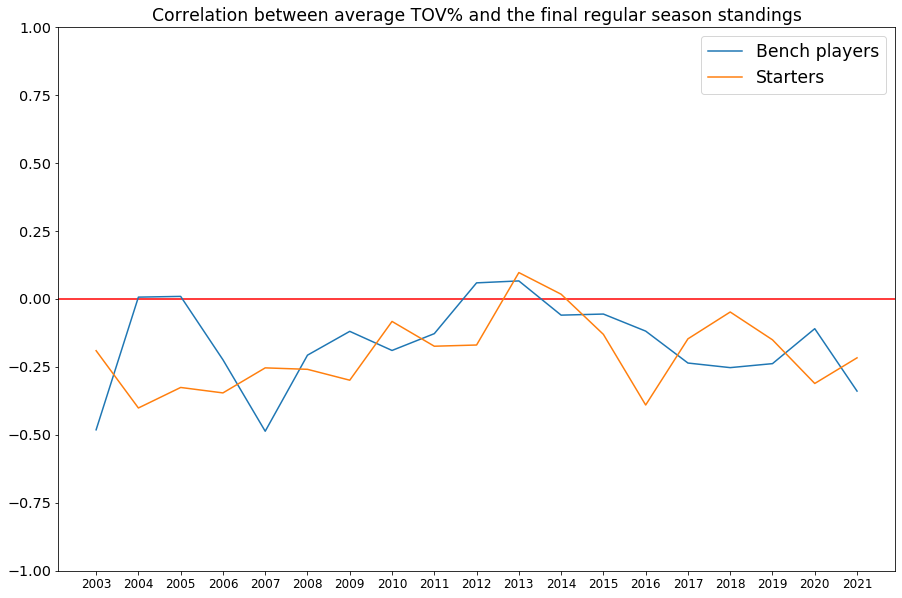

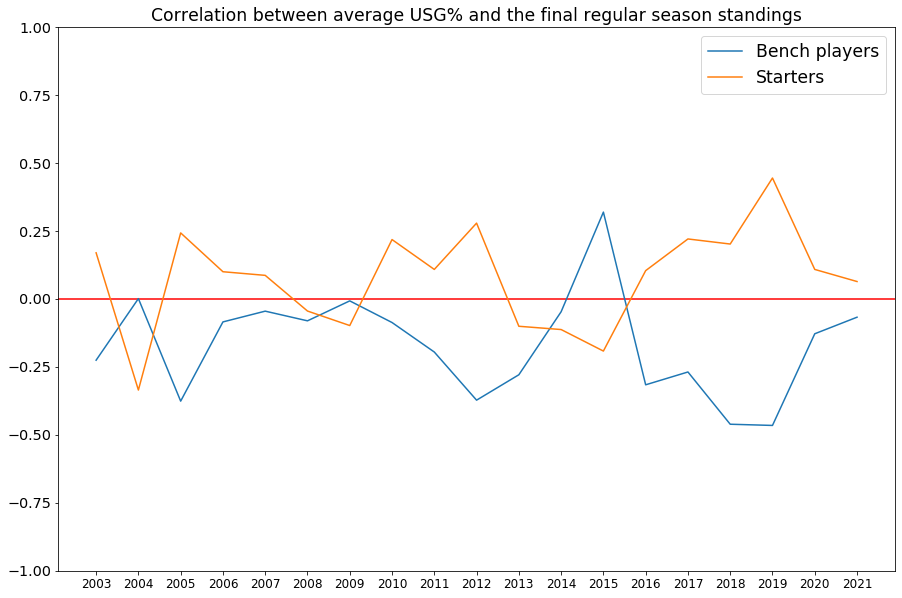

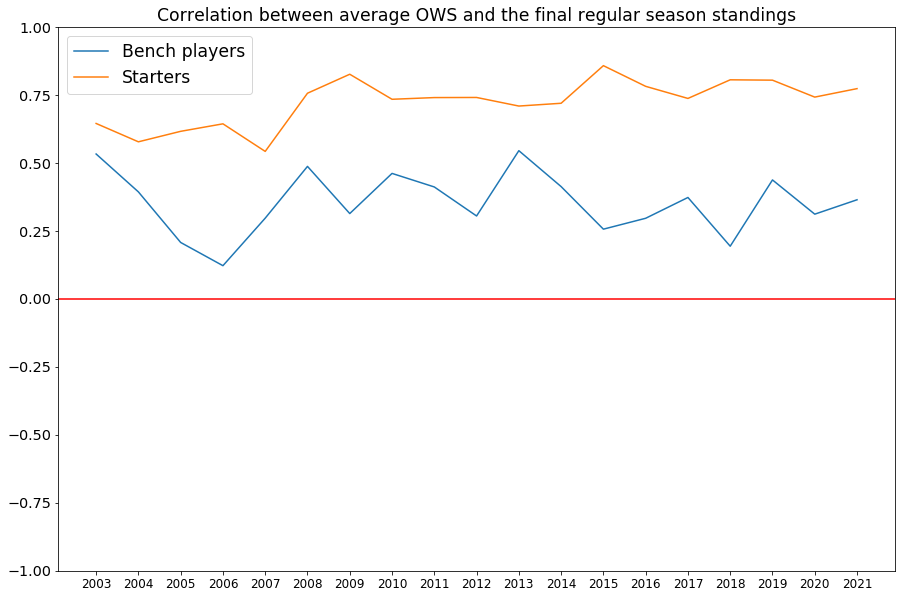

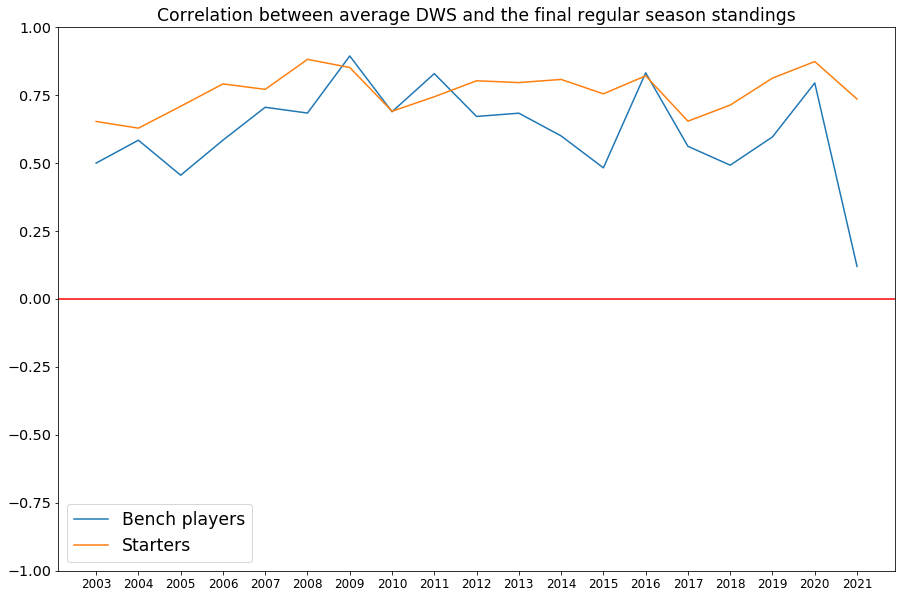

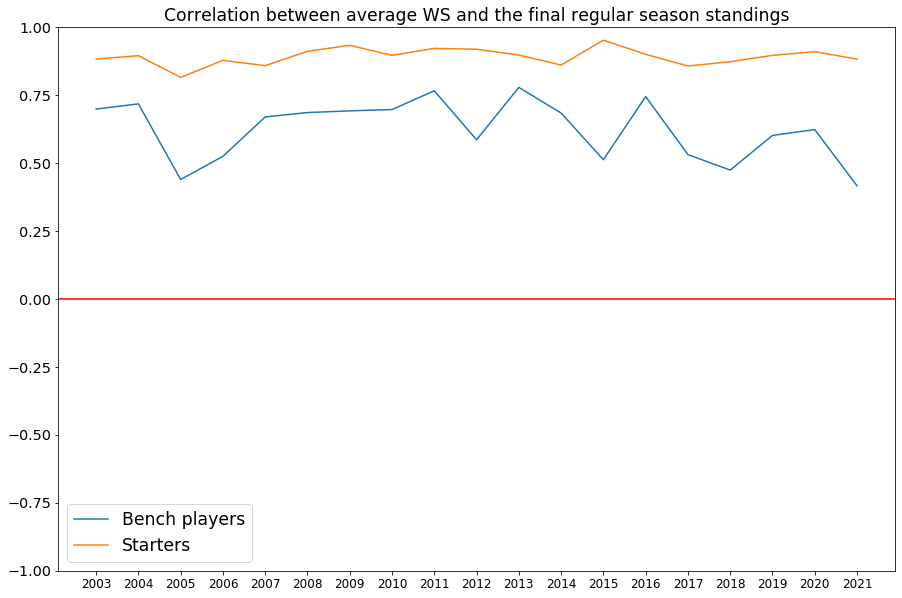

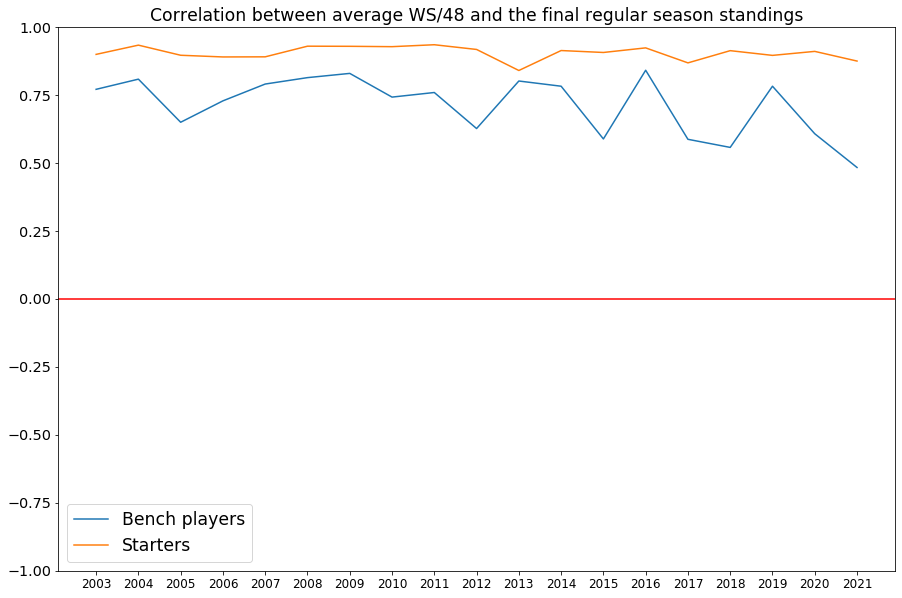

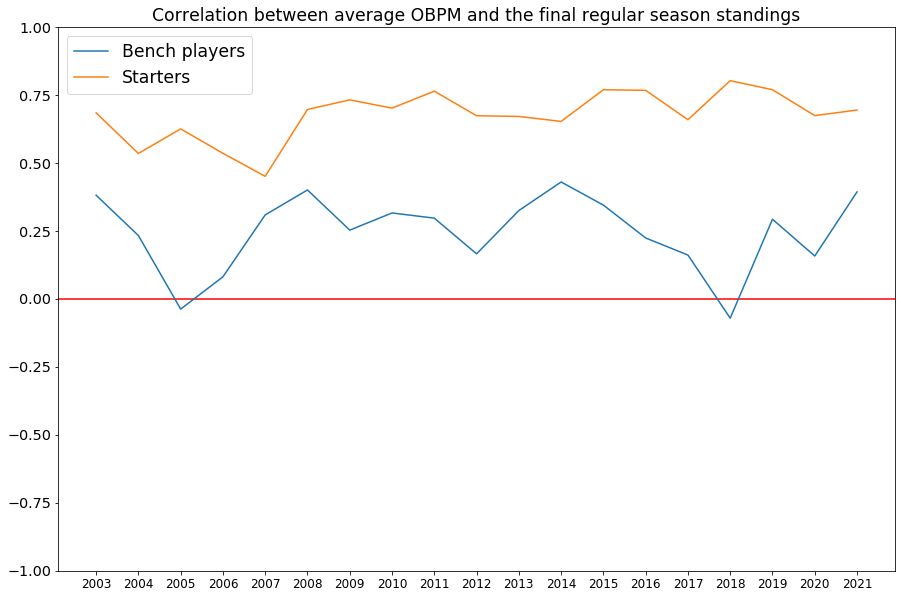

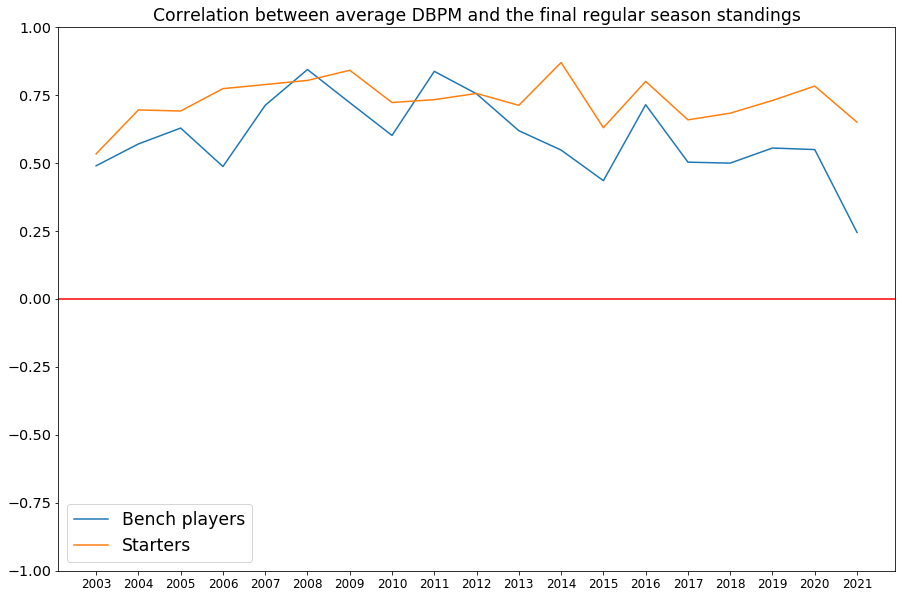

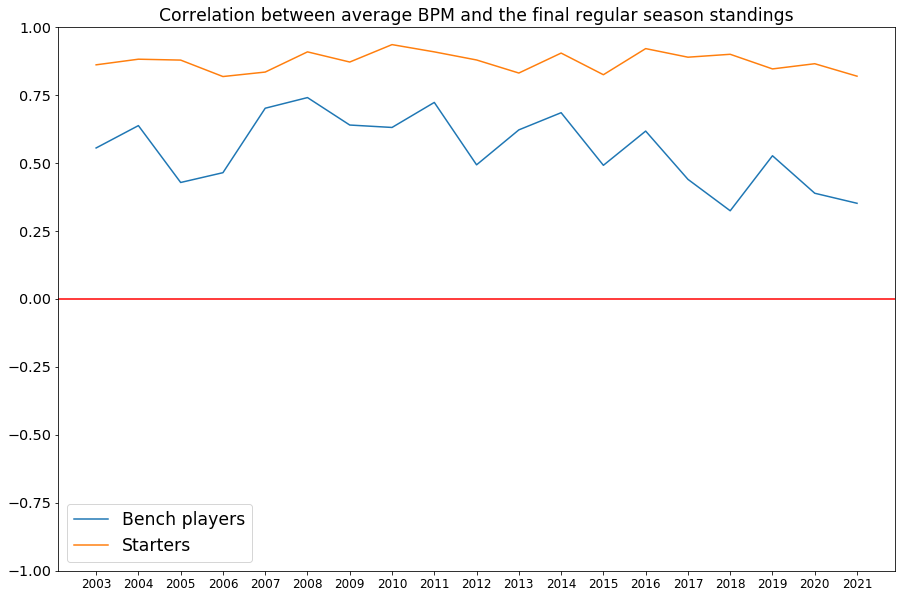

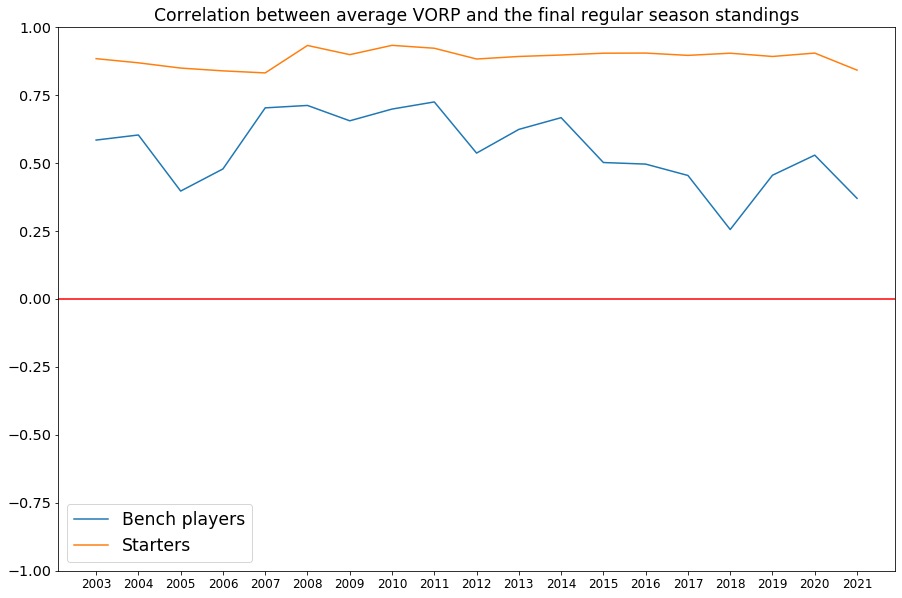

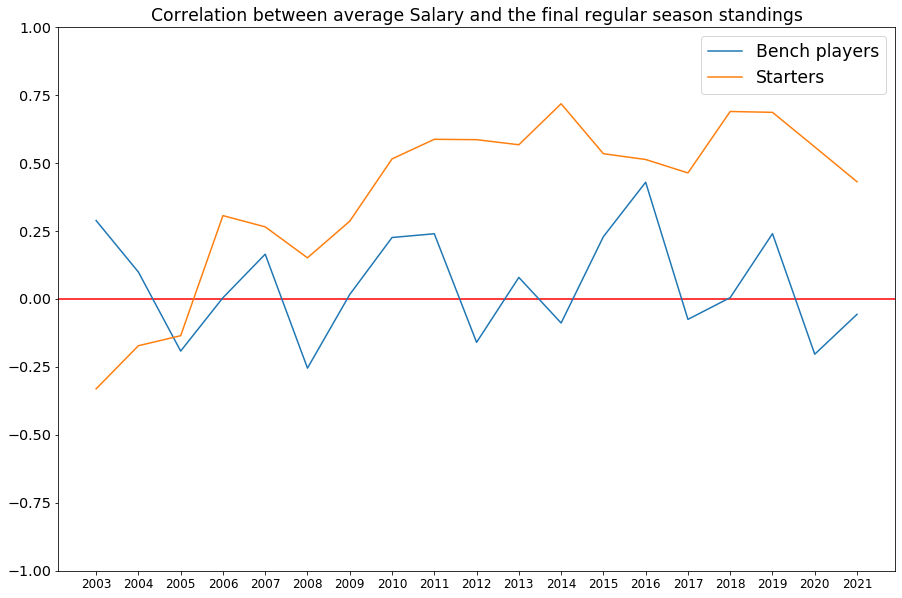

In [29]:
for stat in starters_corr.index:
    plt.figure(figsize=(15,10))
    plt.axhline(y=0.0, color='r', linestyle='-')
    plt.plot(SEASONS, bench_corr.loc[stat], label="Bench players")
    plt.plot(SEASONS, starters_corr.loc[stat], label="Starters")
    plt.xticks(SEASONS)
    plt.yticks([-1, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1.0])
    plt.title(f"Correlation between average {stat} and the final regular season standings")
    plt.legend()
    plt.show()
    

# Starter Analysys

In [30]:
starters_per_season = []

for i in range(len(SEASONS)):    
    df = player_dfs[i].sort_values(by=['Tm', 'GS'], ascending=[True, False])
    cols = df.columns    
    starters_df = pd.DataFrame(columns = cols)
    for team in TEAMS:
        starters = pd.DataFrame(df[df["Tm"] == team][:5])
        starters = starters.mean()
        starters_df.loc[team] = starters

    starters_df.drop(["Player", "Pos", "Tm"], axis=1, inplace=True)
    starters_df.index.names = ["Team"]
    starters_per_season.append(starters_df)

In [31]:
starter_stats = ['Age', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P',
       '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST',
       'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%',
       'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS',
       'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP', 'Salary']

starter_avg_per_season = {}


for stat in starter_stats:
    starter_avg_per_season[stat] = []
    for df in starters_per_season:
        starter_avg_per_season[stat].append(df[stat].mean())

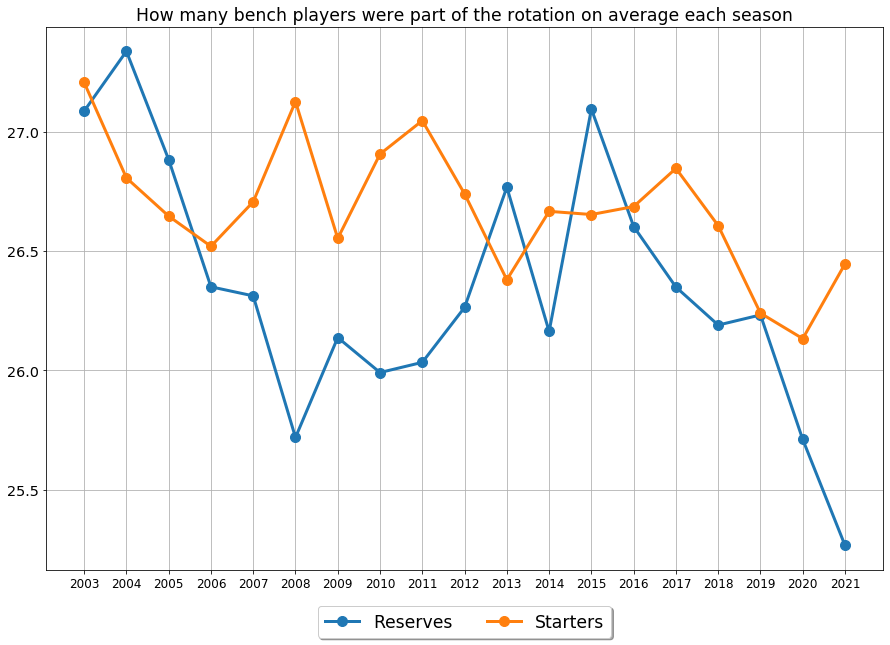

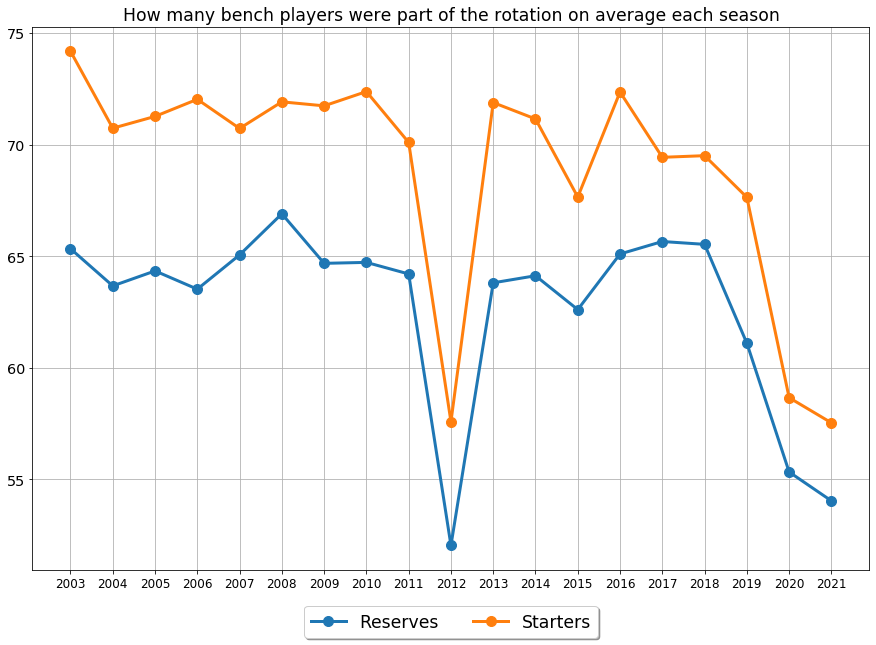

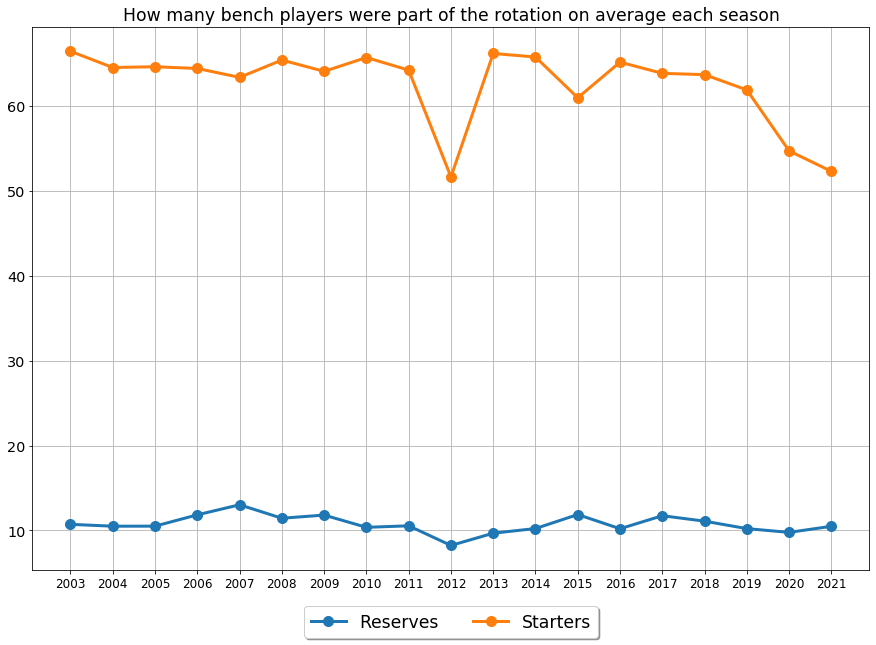

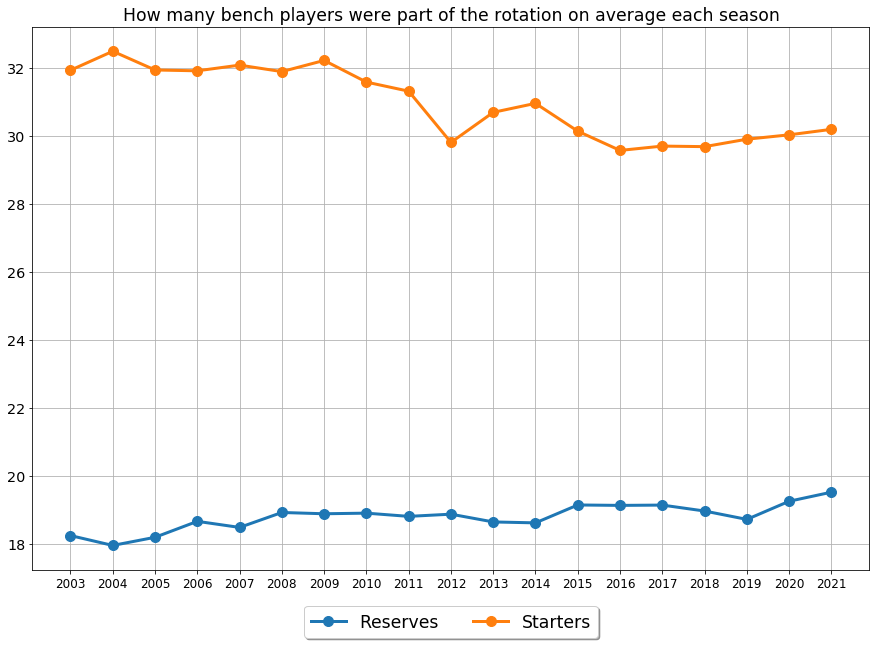

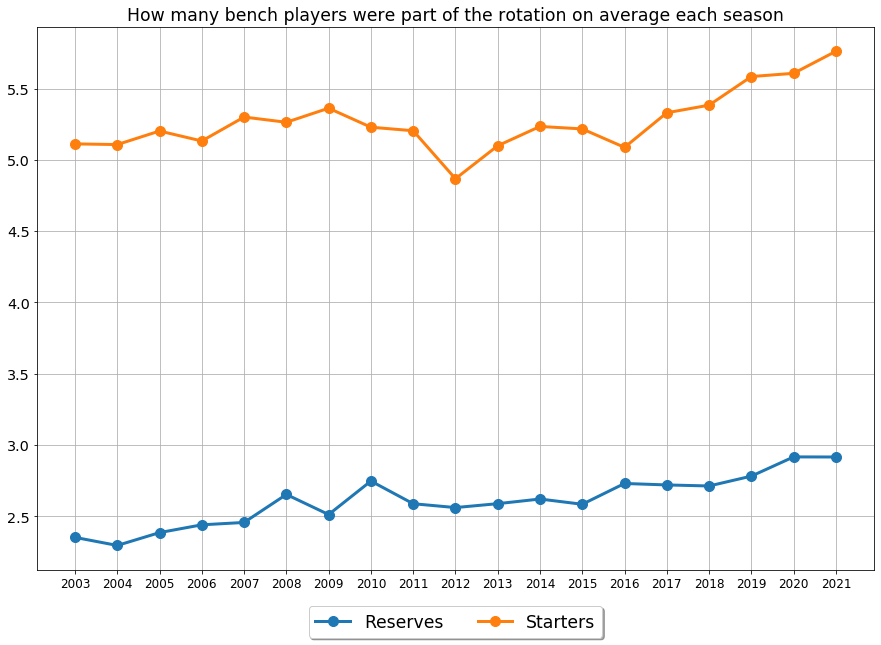

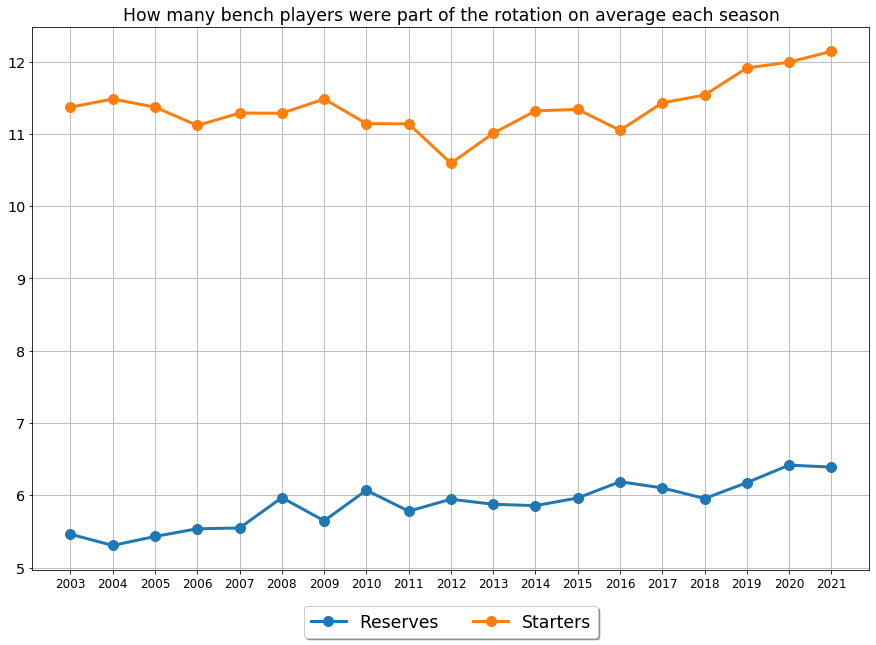

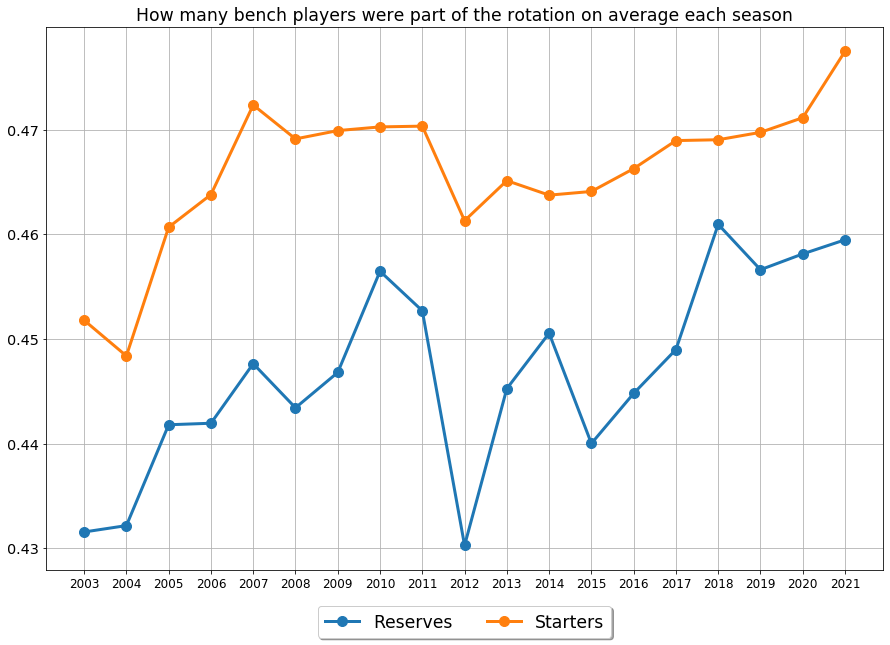

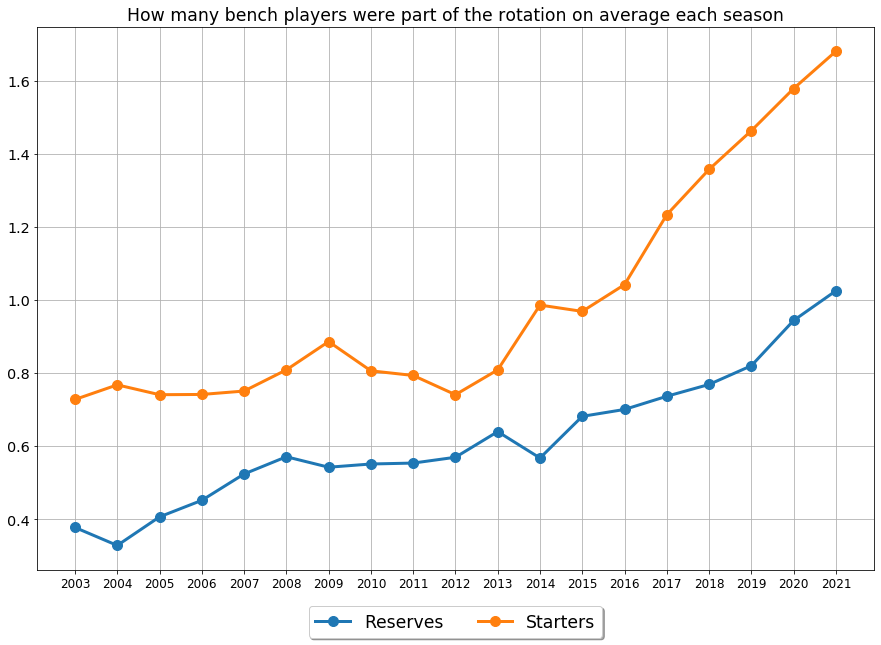

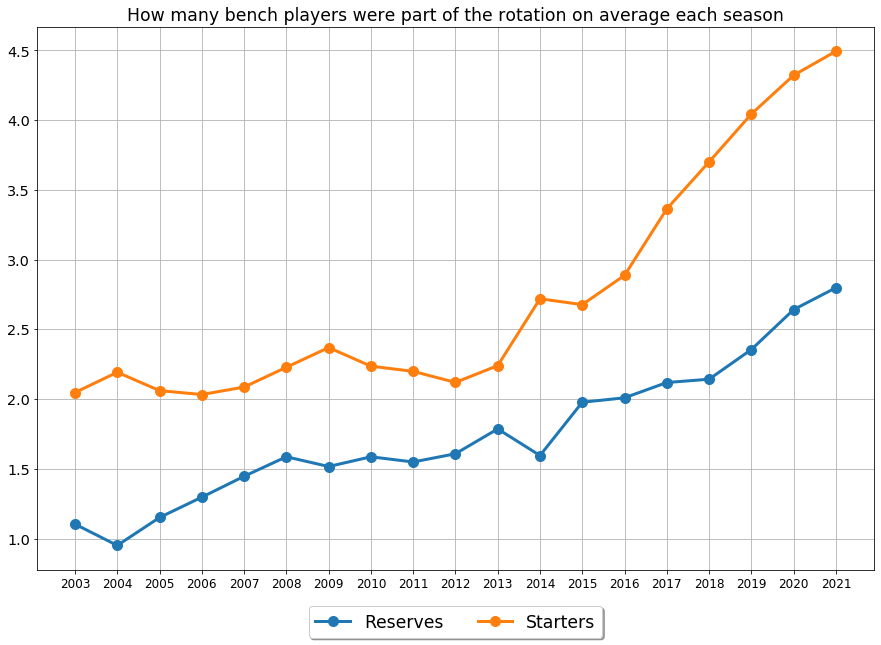

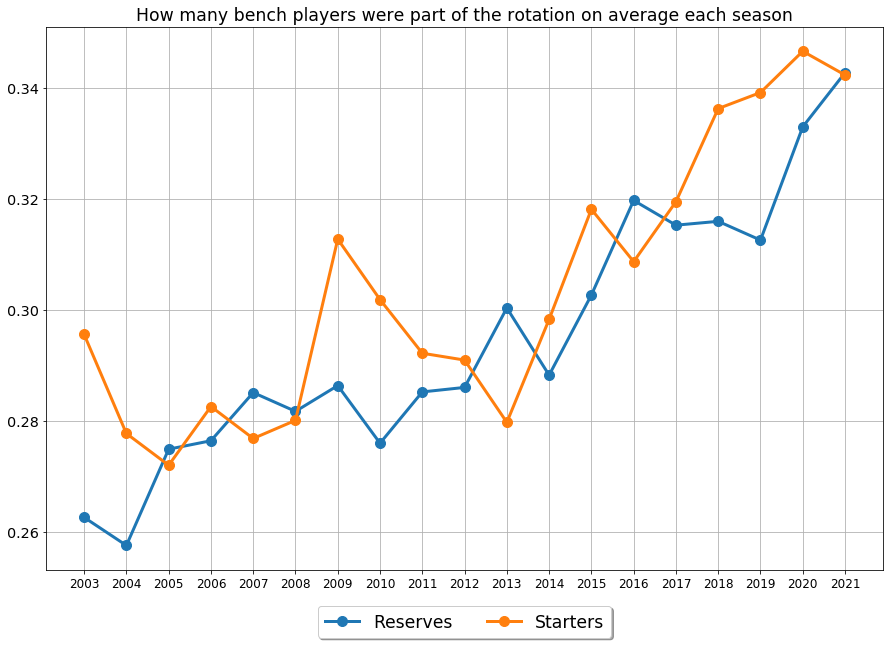

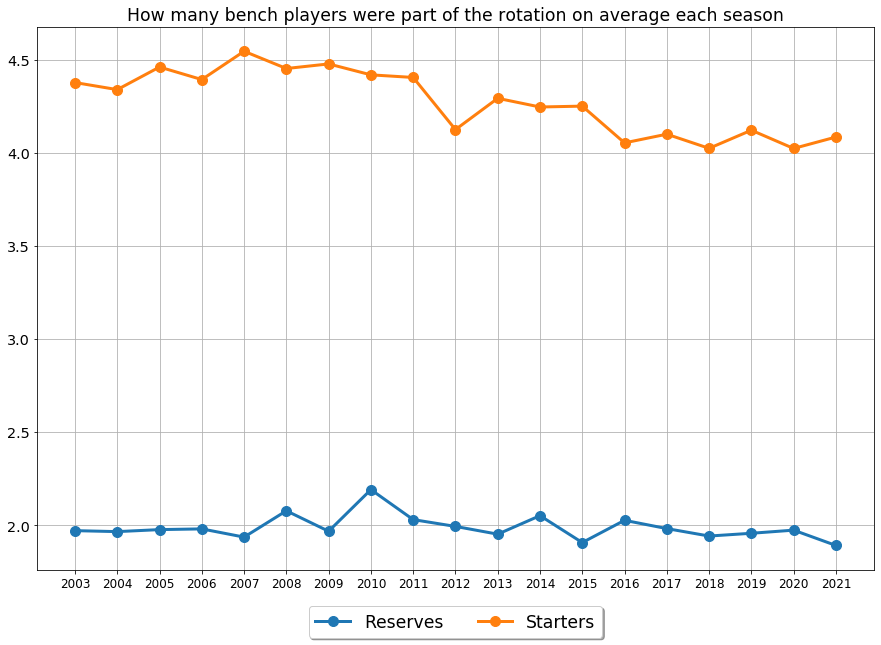

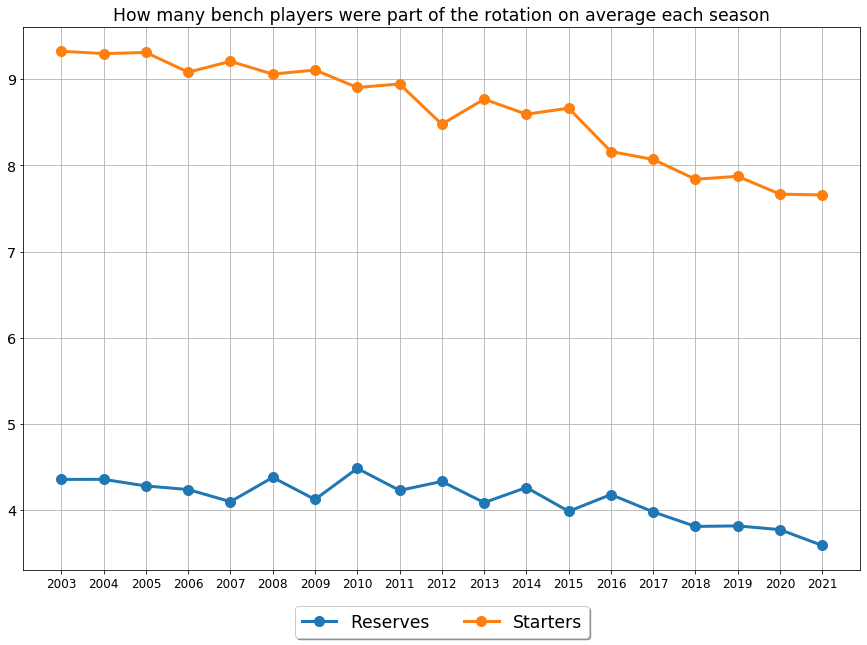

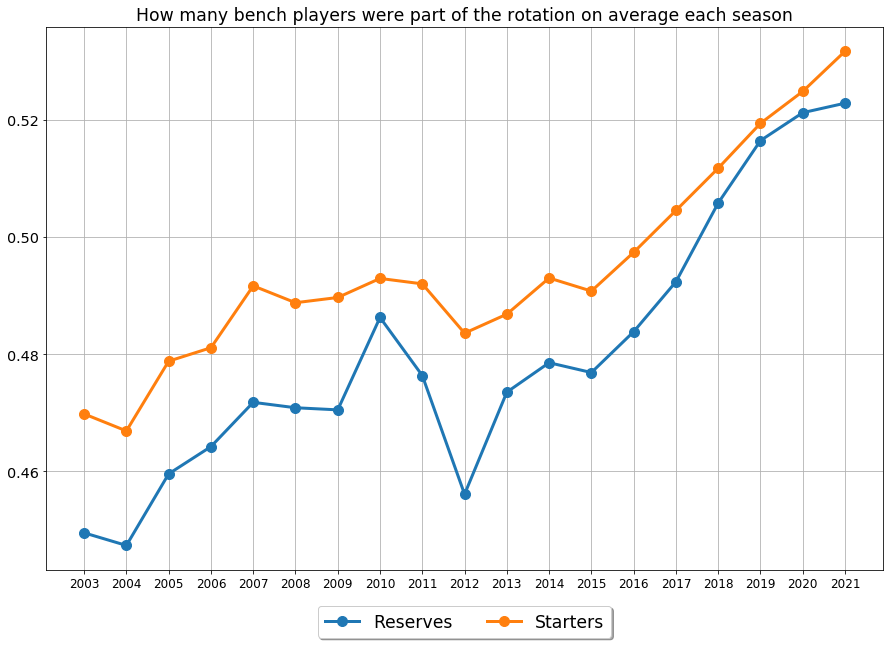

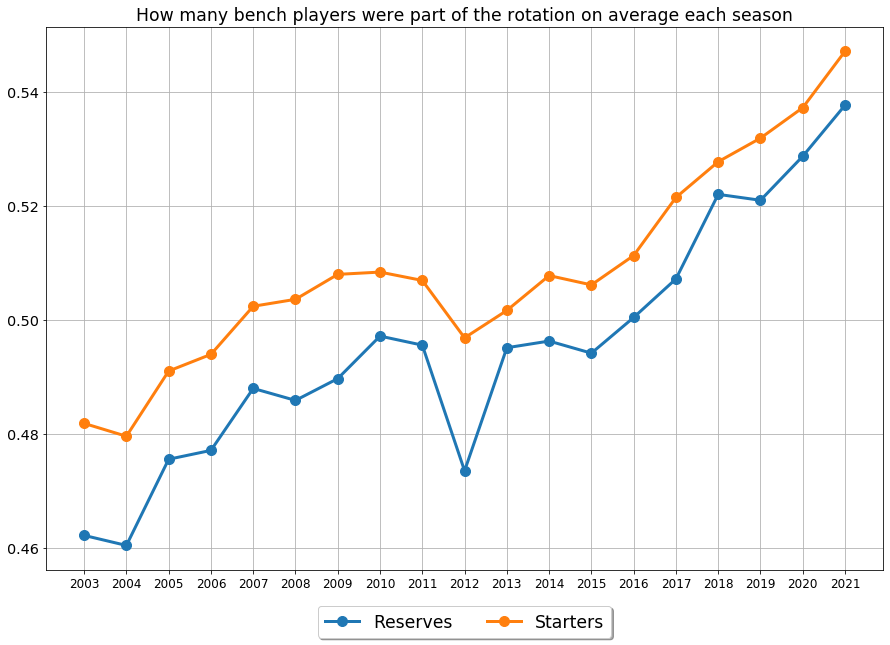

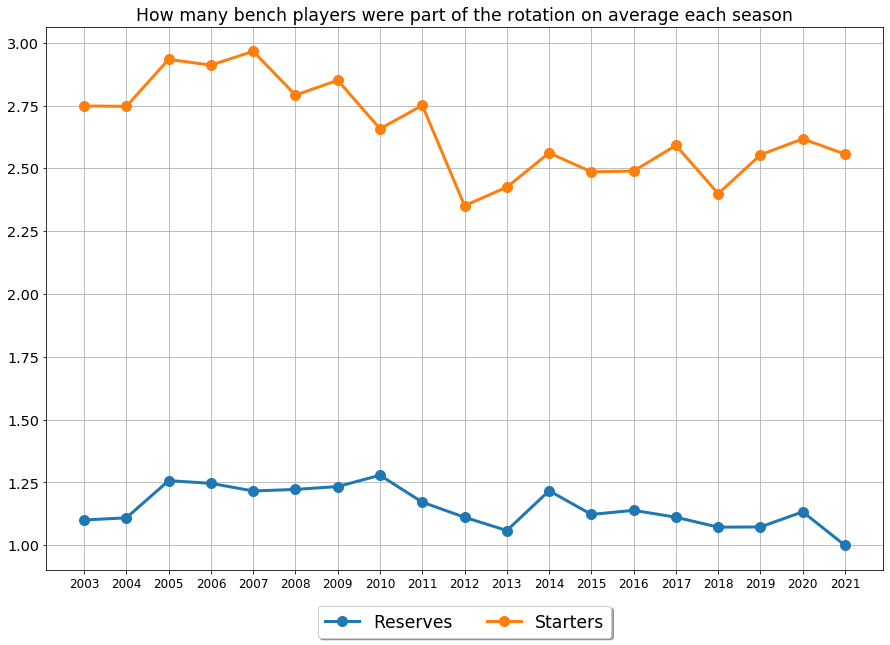

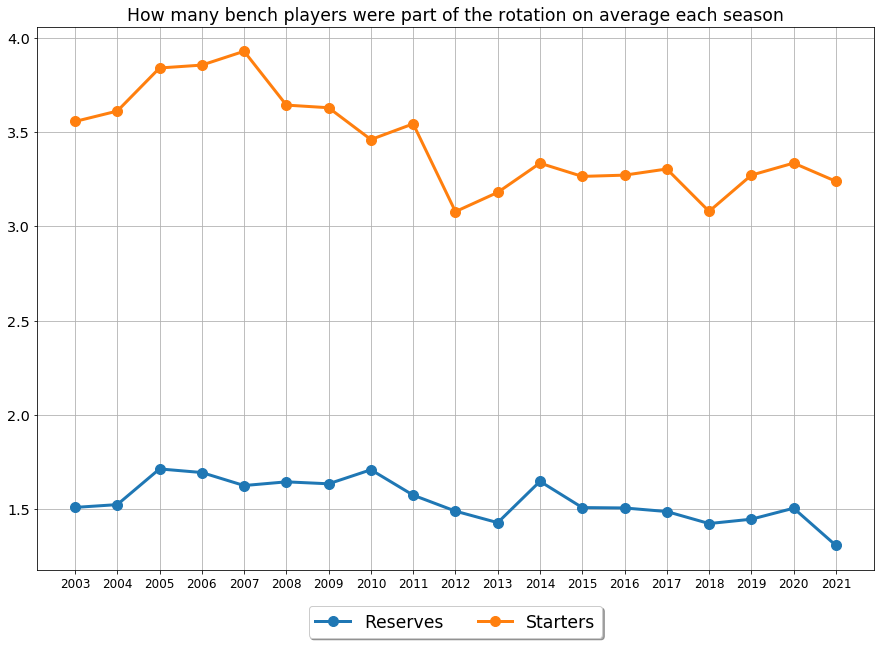

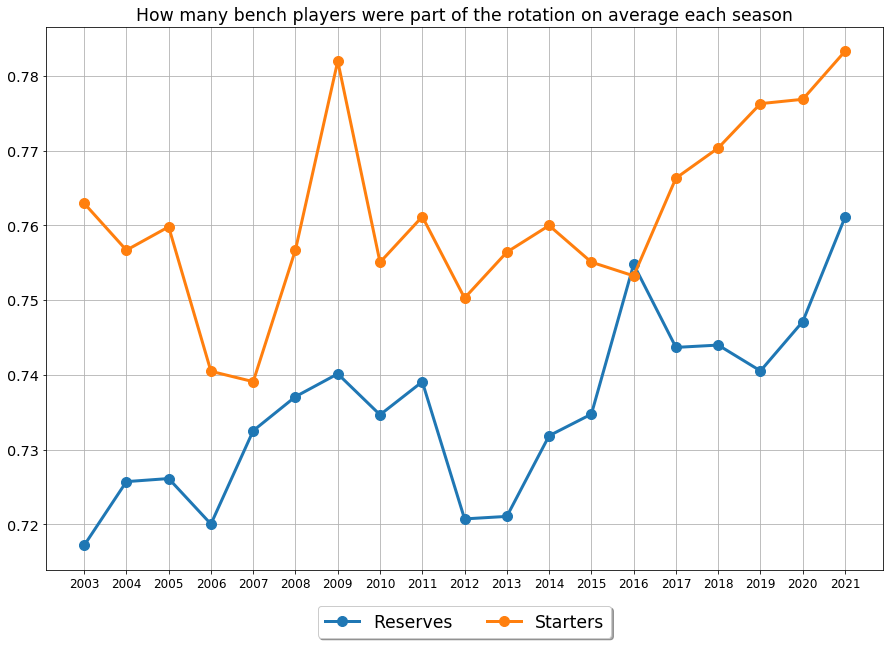

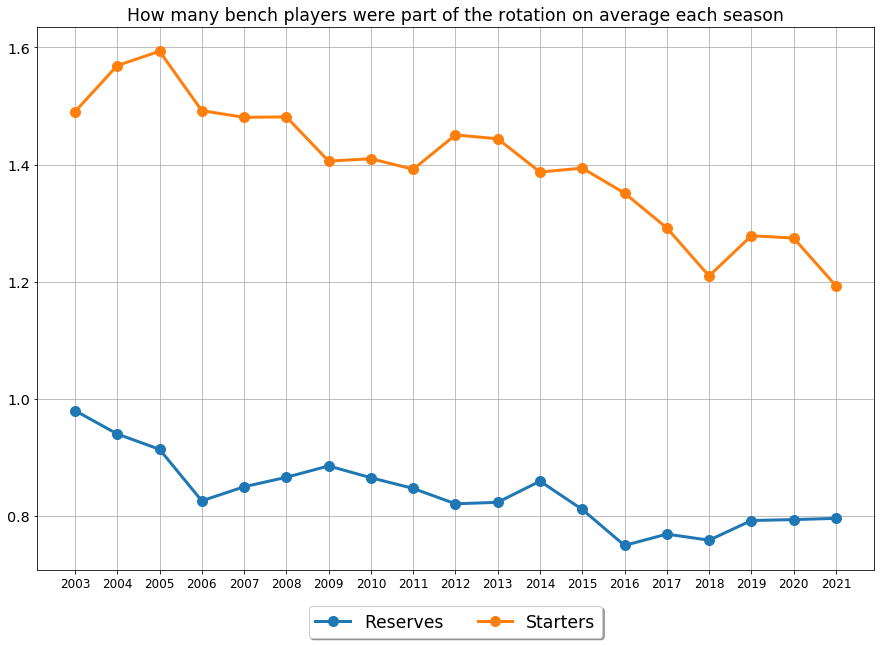

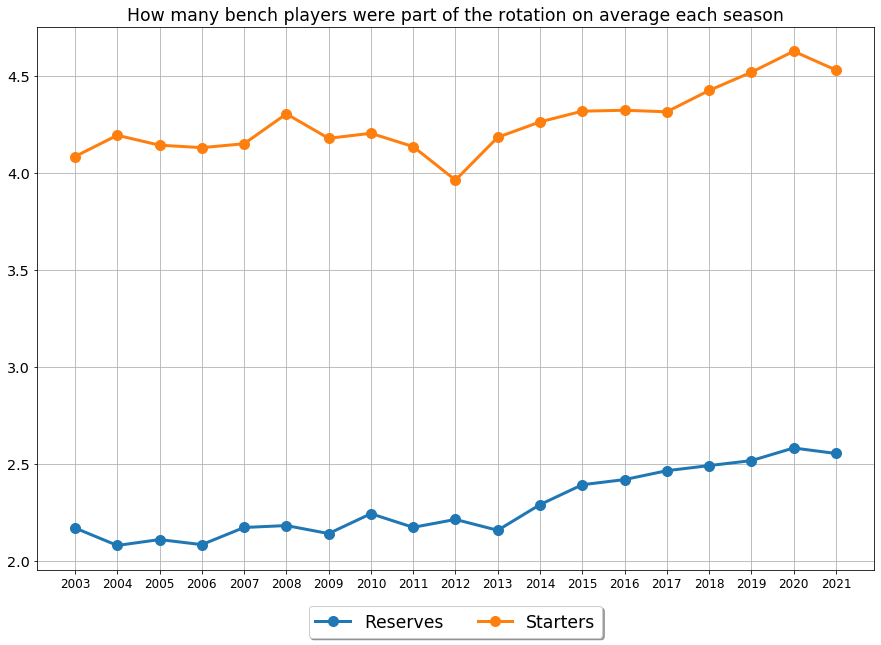

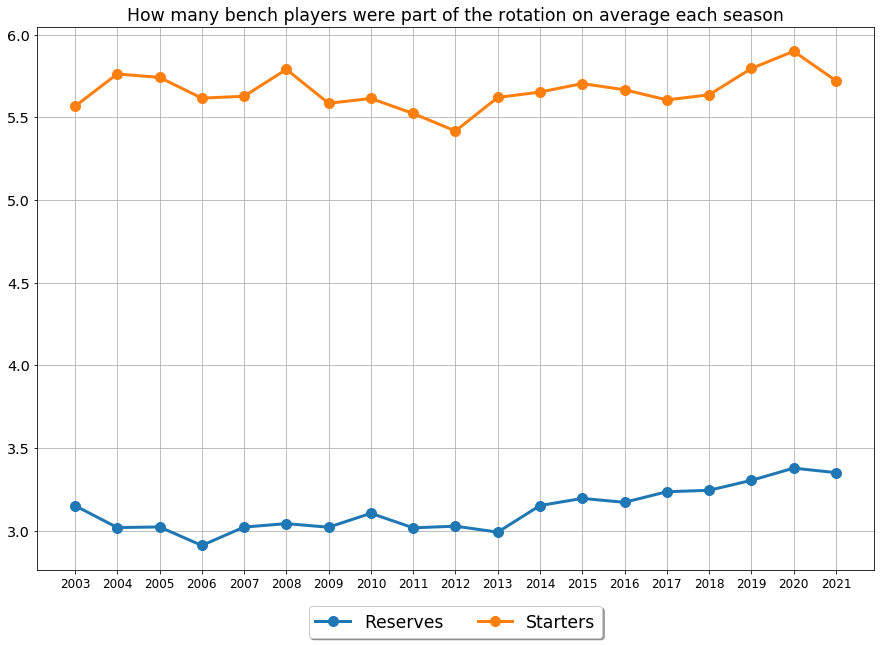

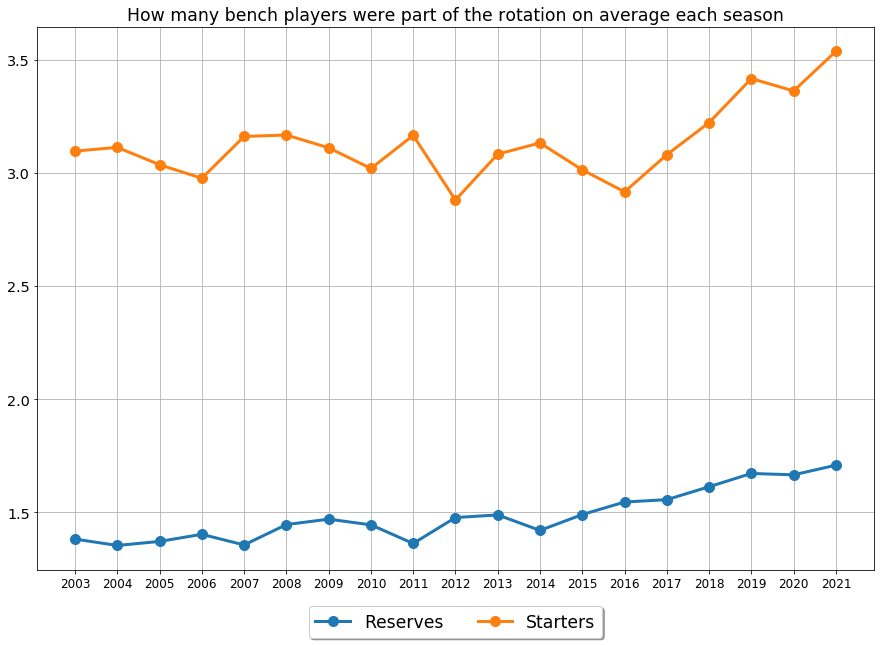

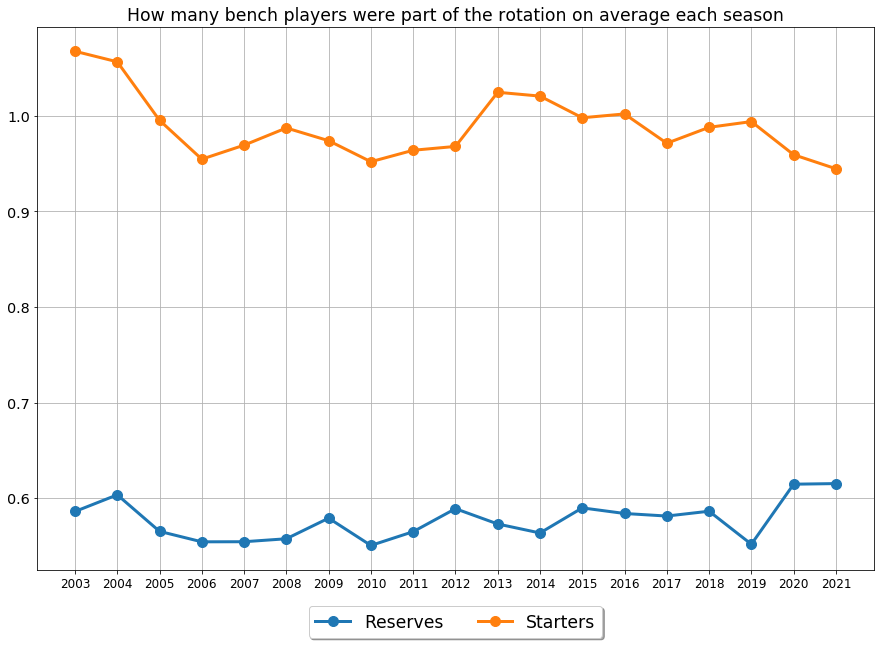

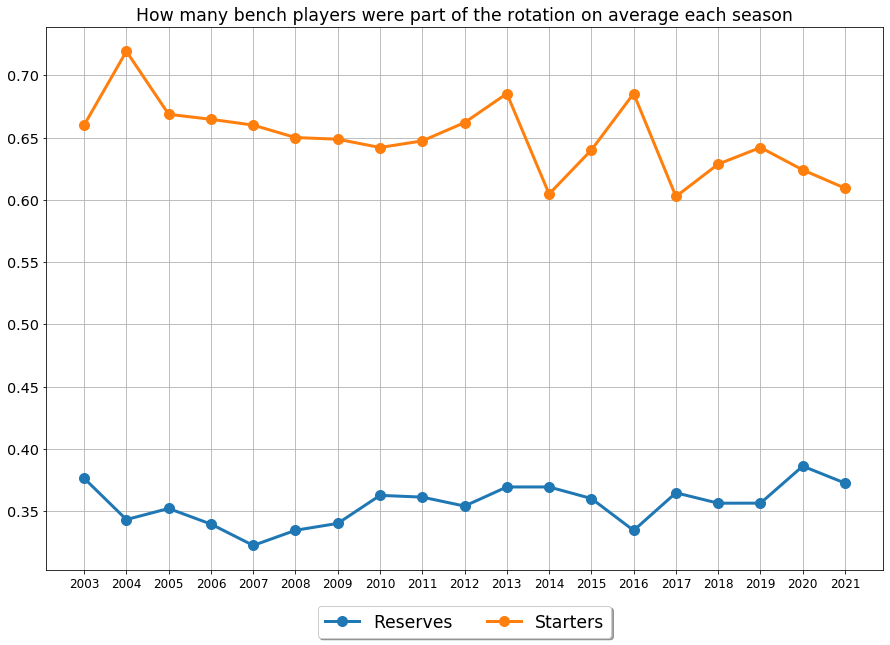

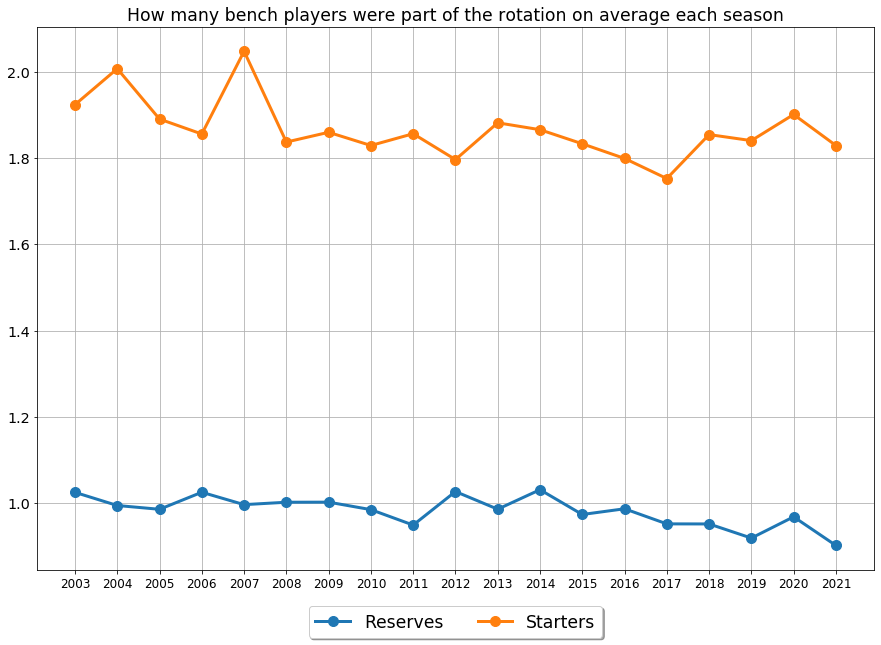

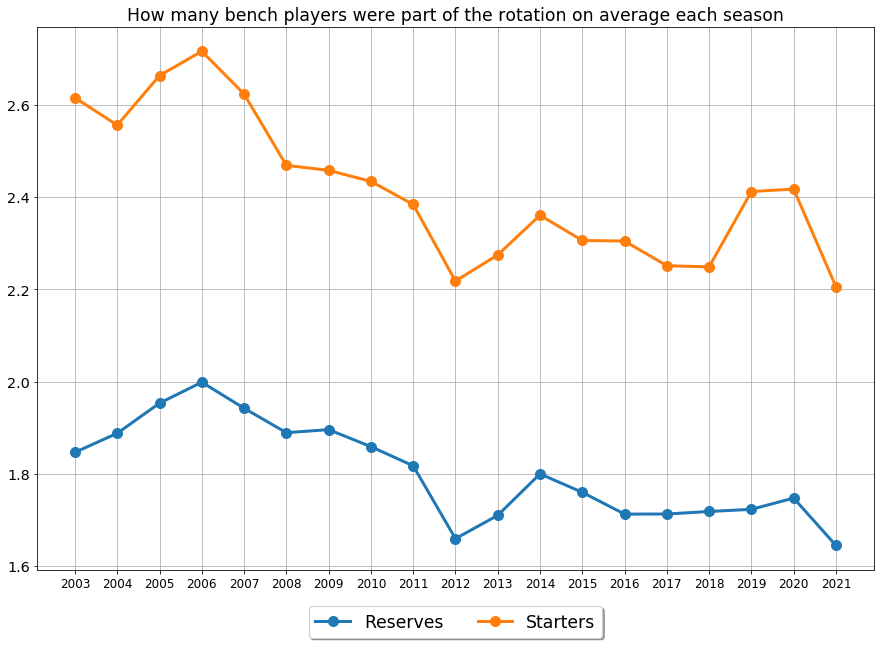

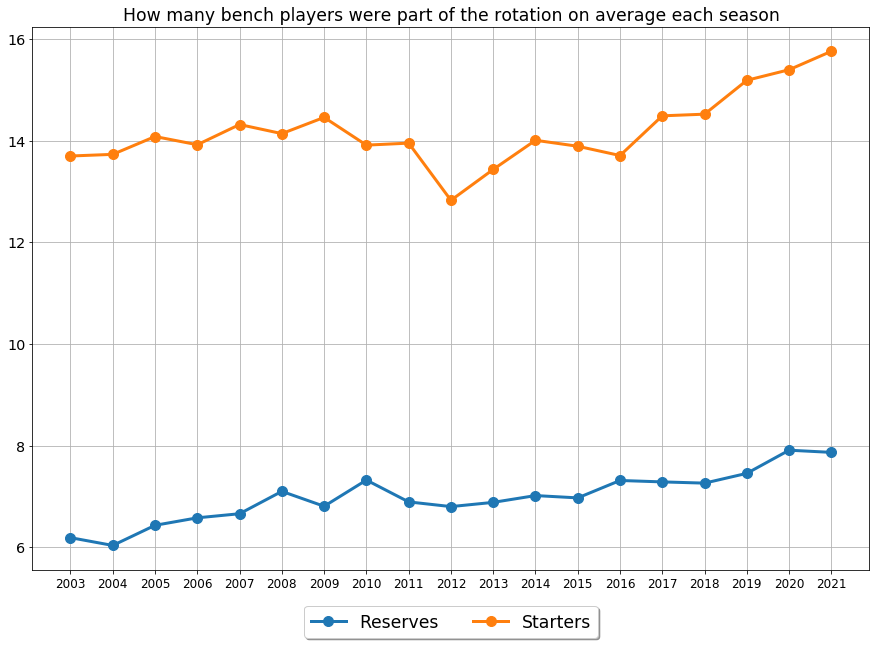

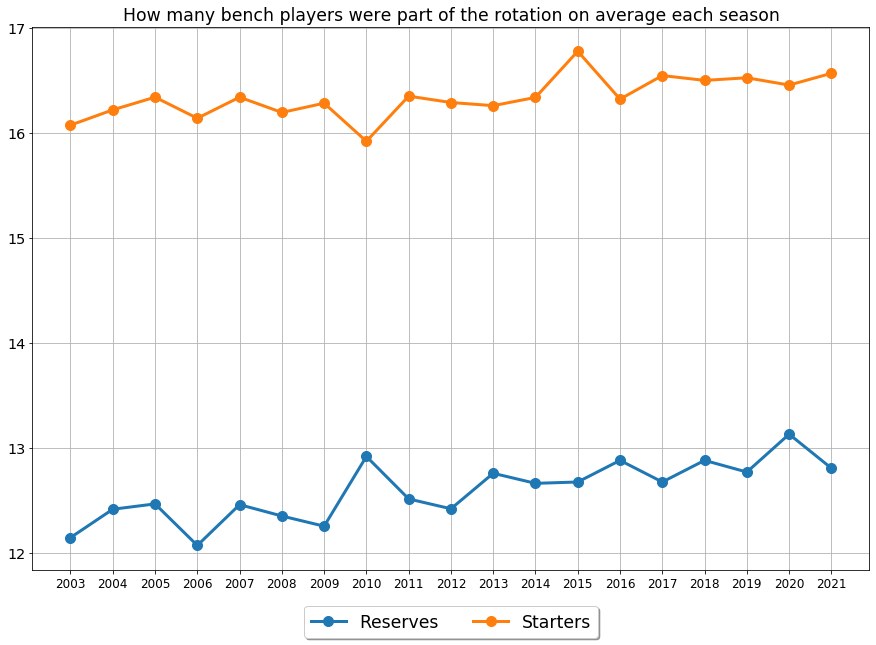

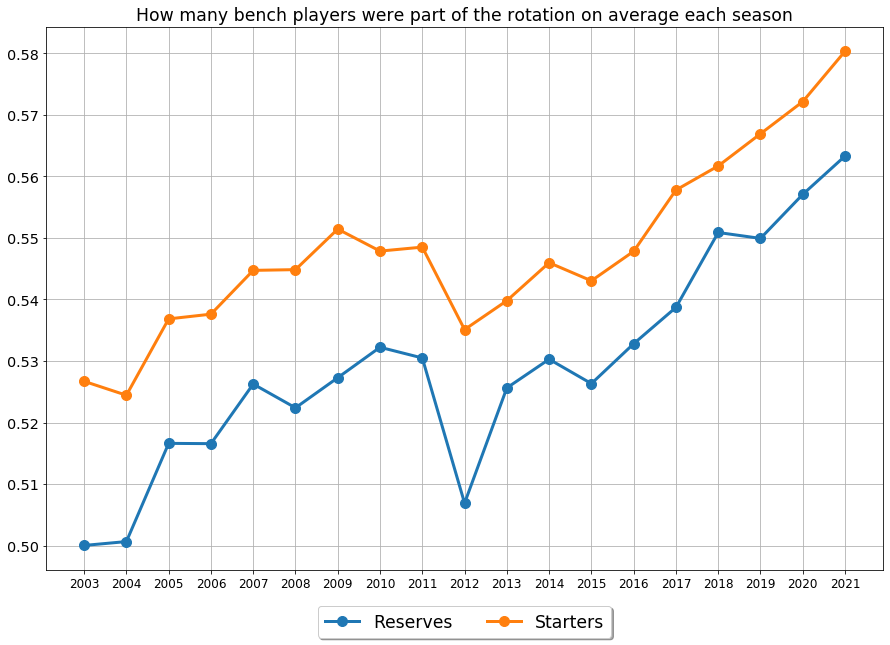

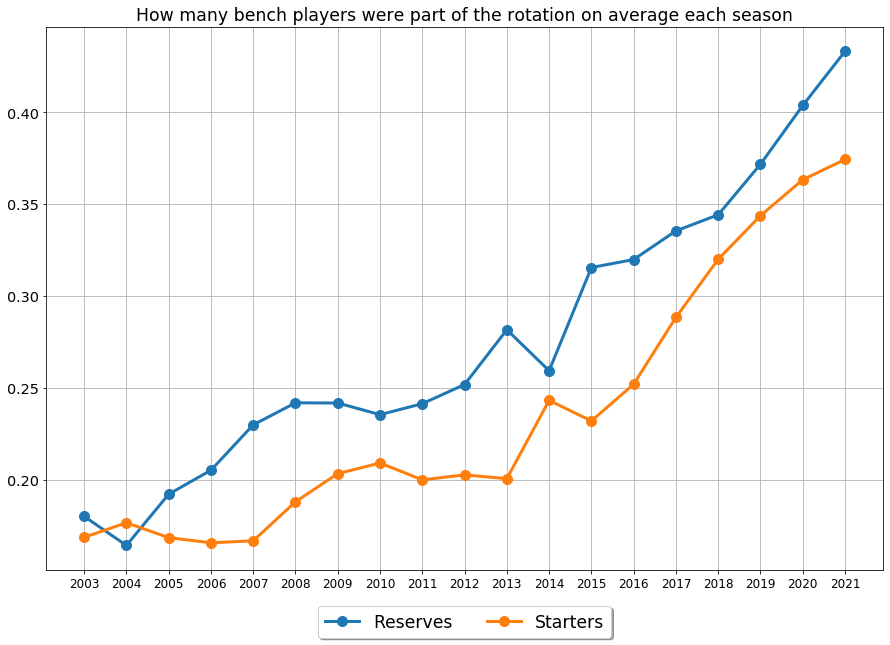

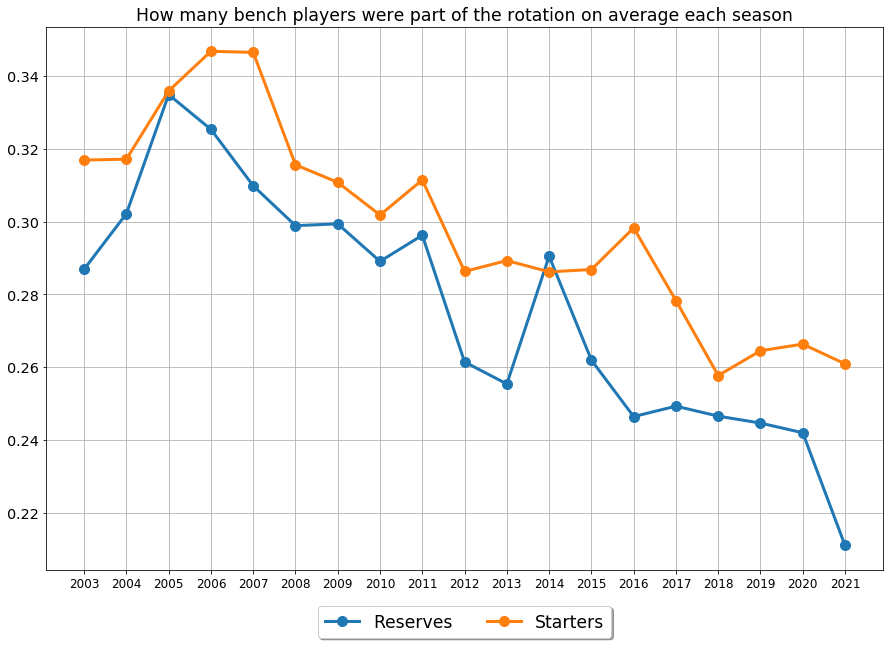

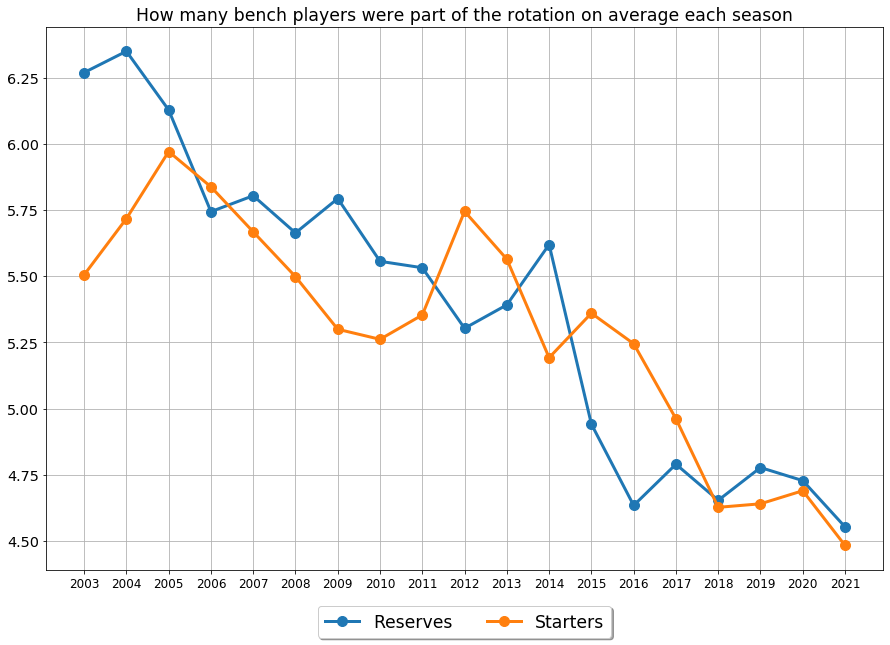

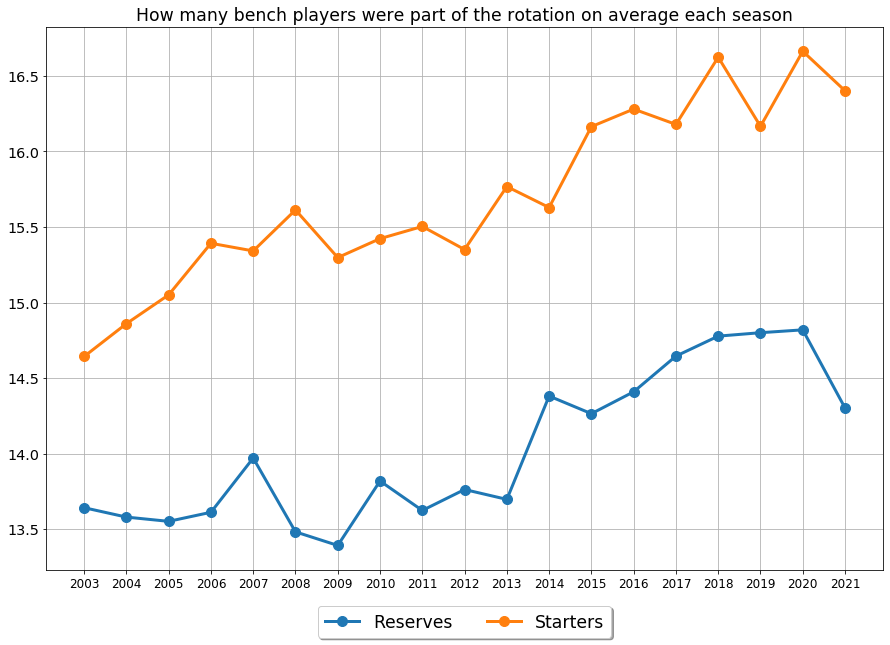

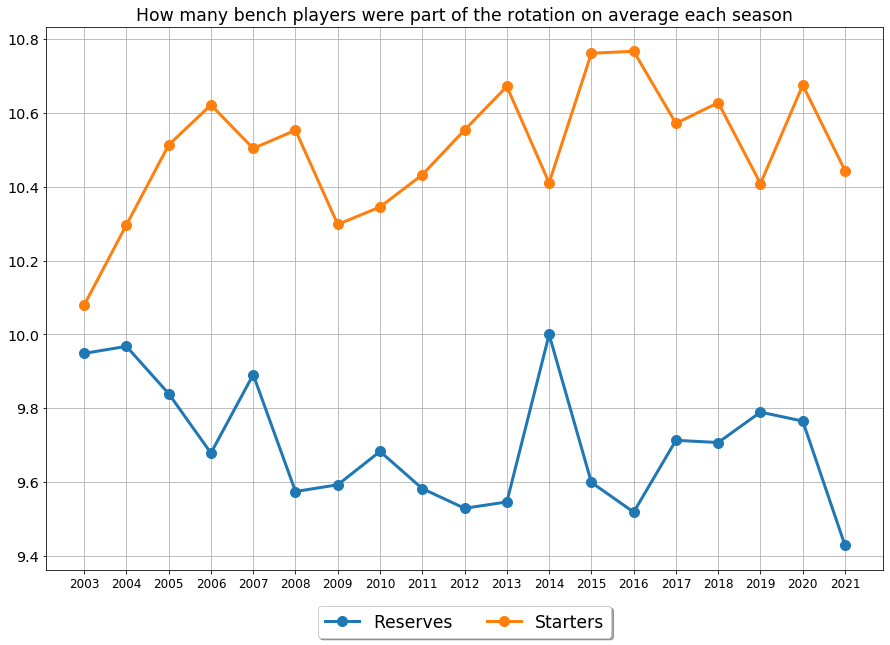

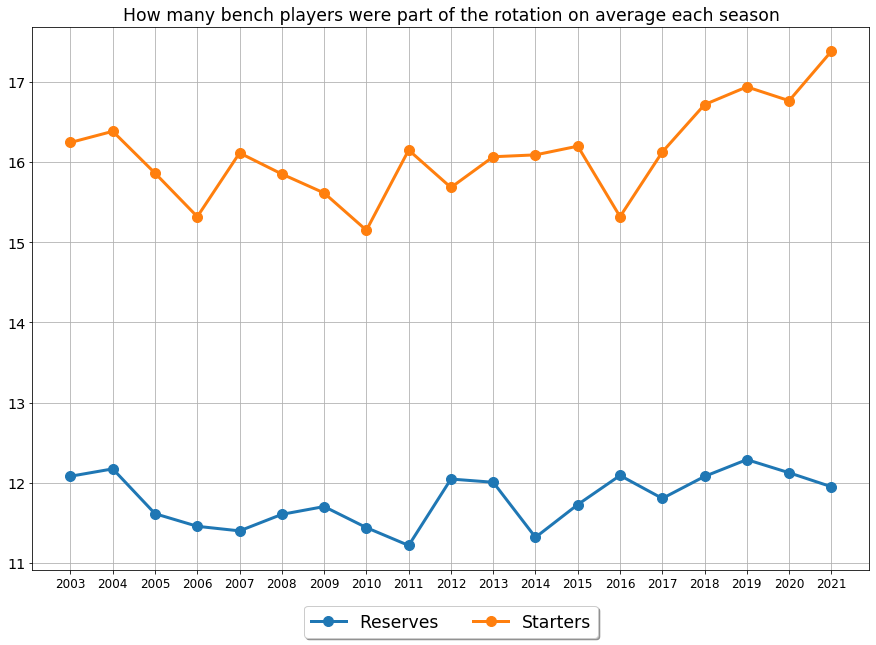

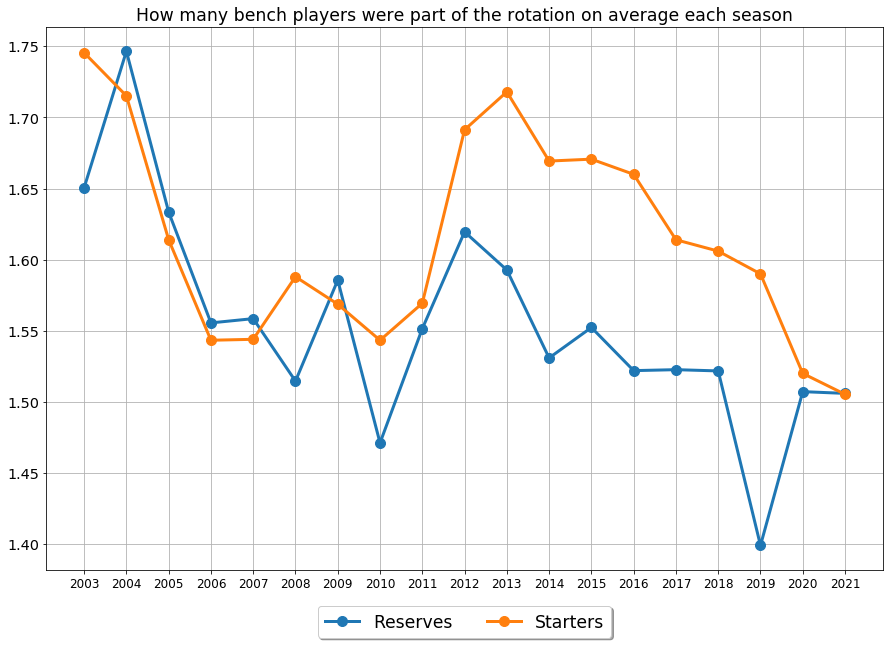

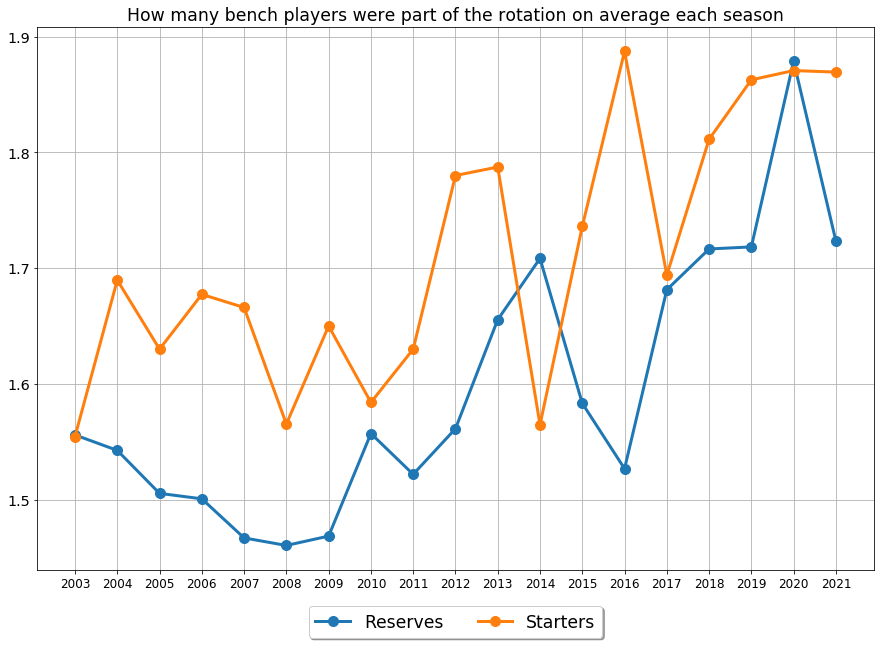

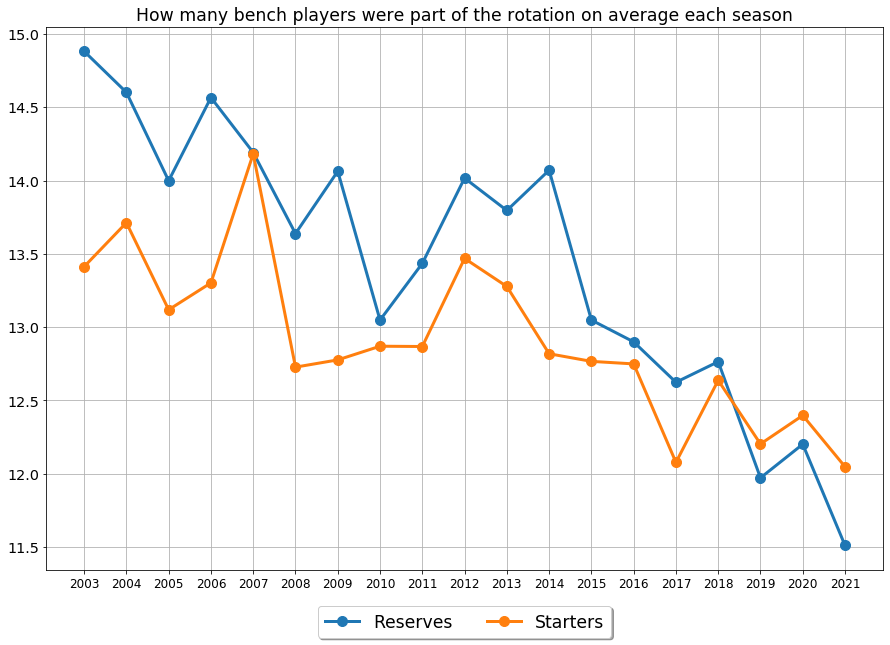

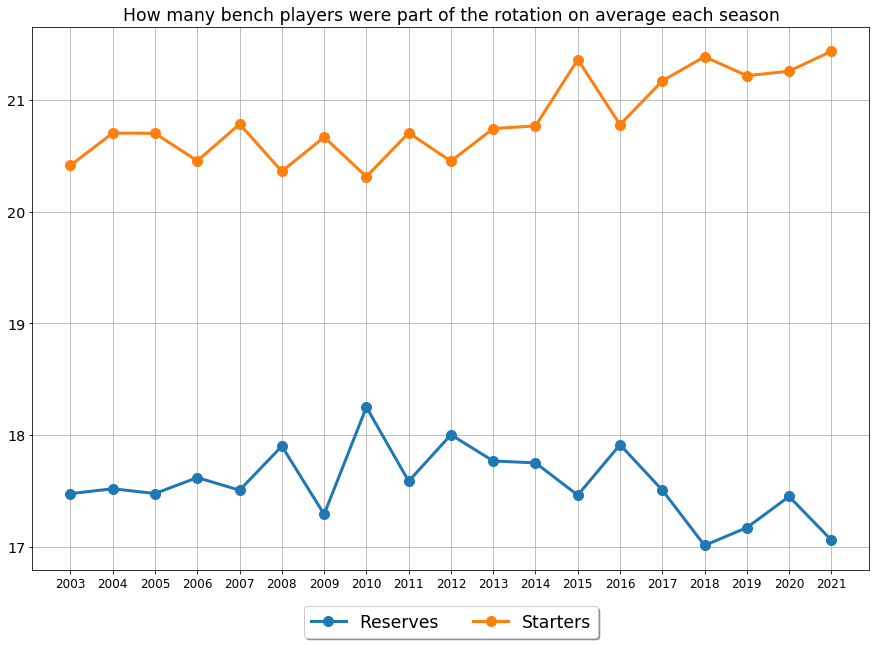

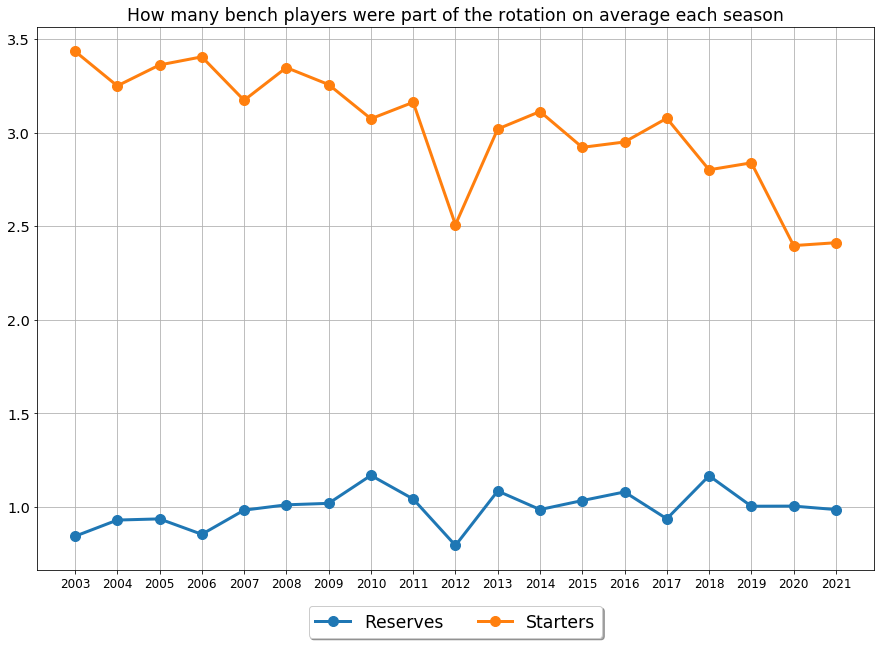

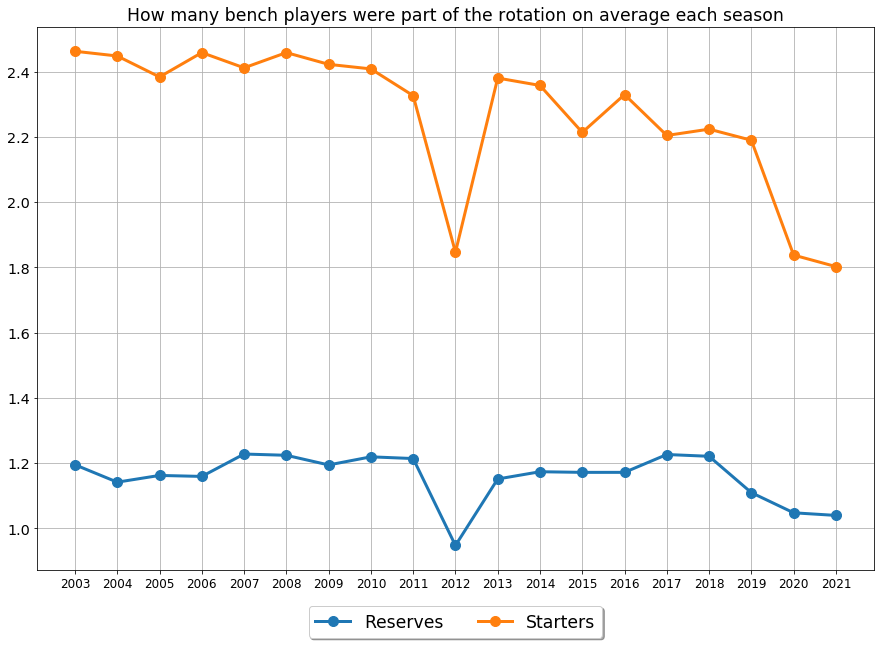

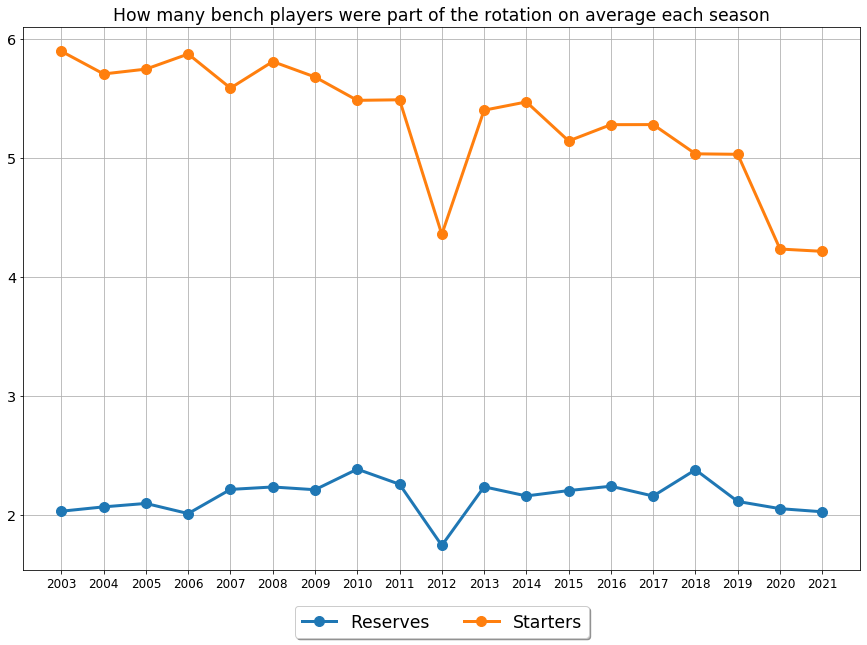

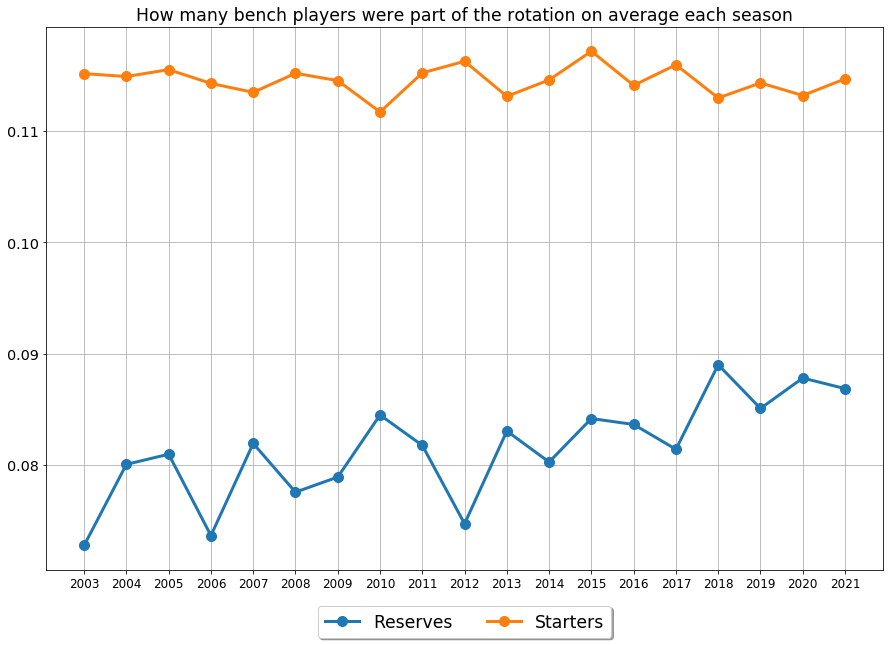

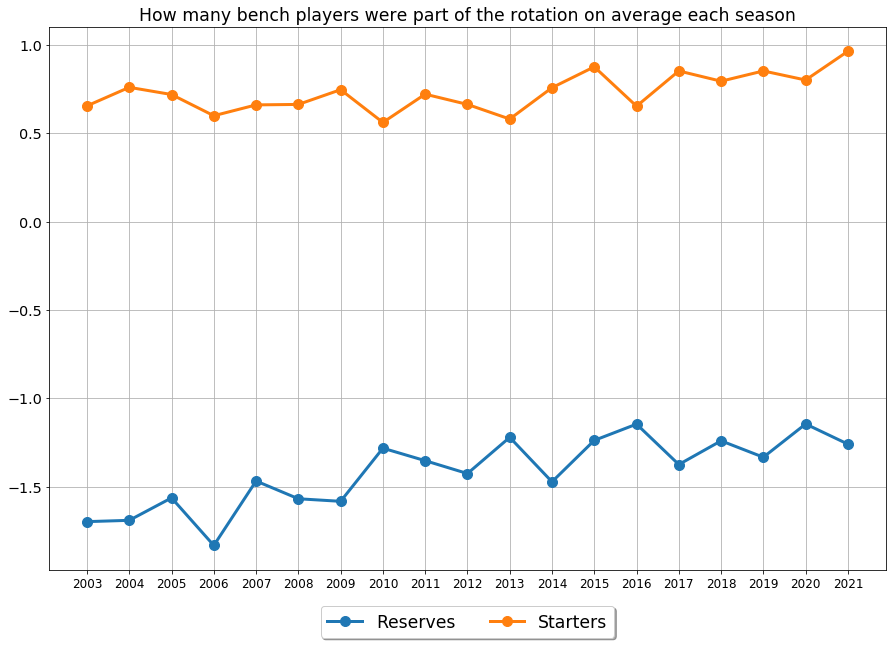

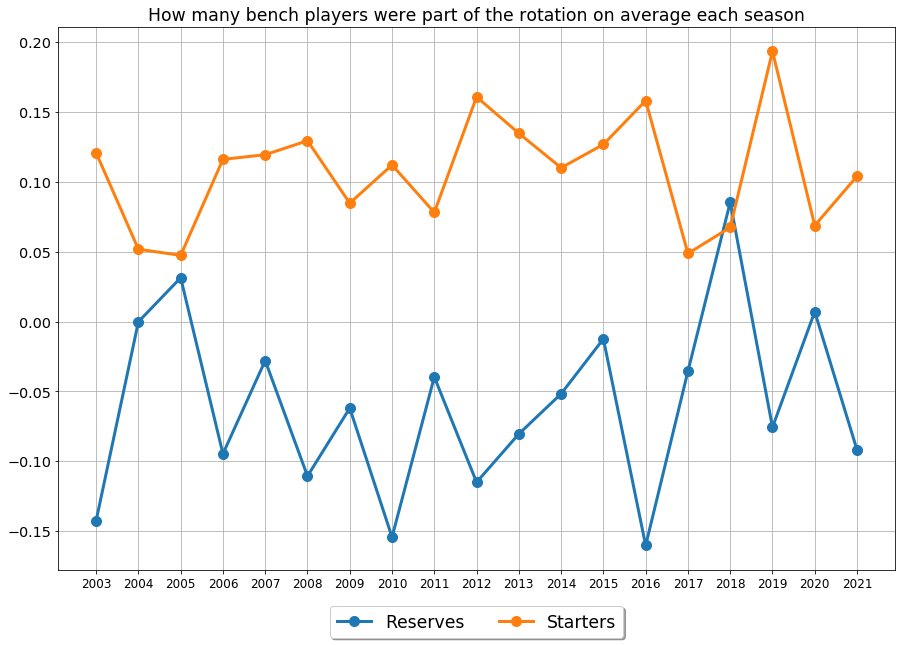

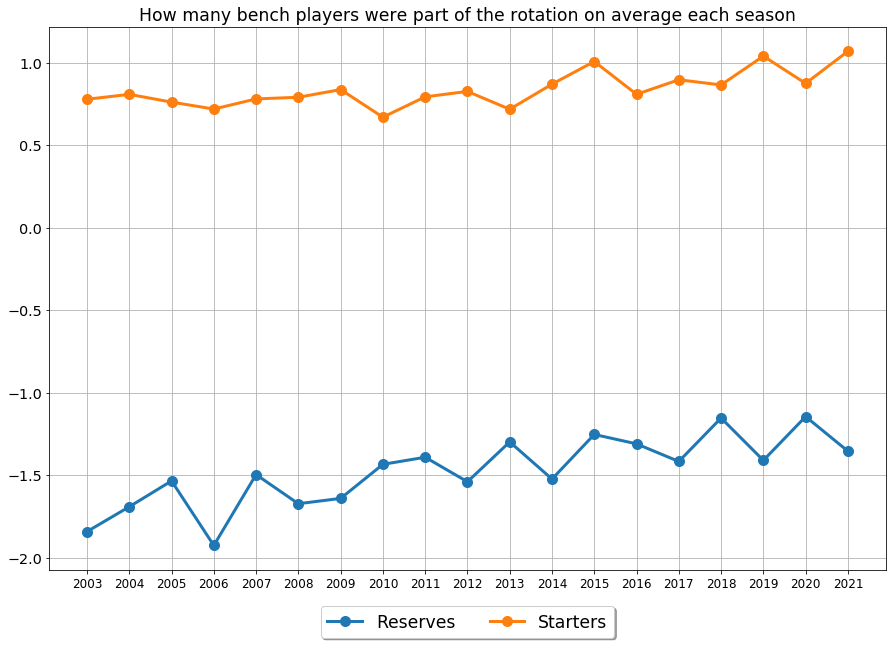

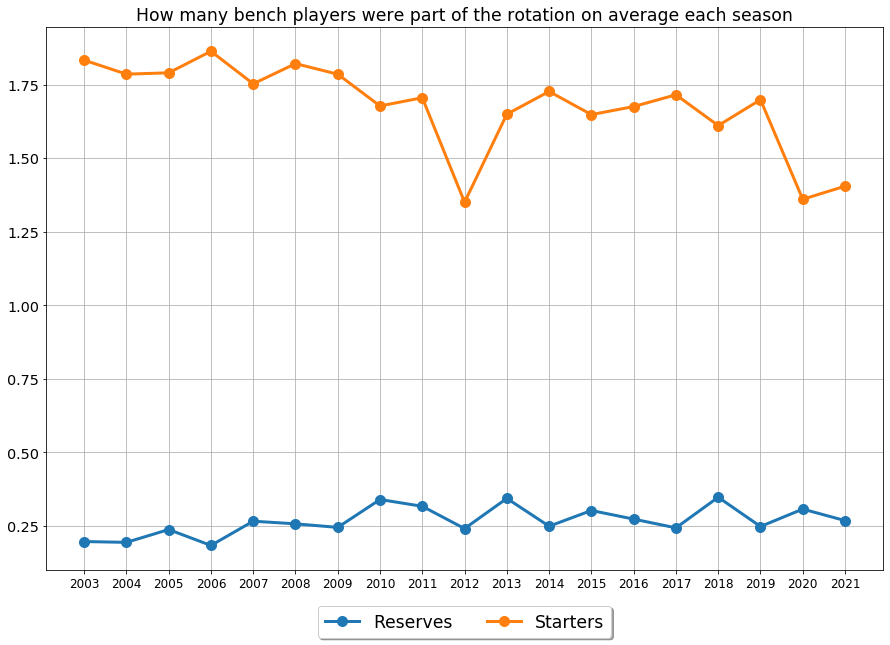

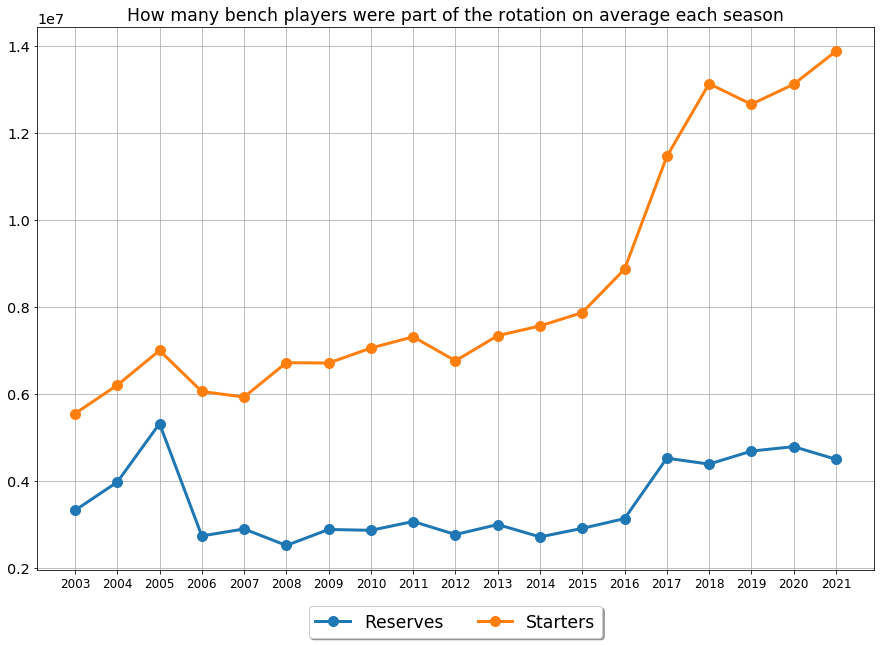

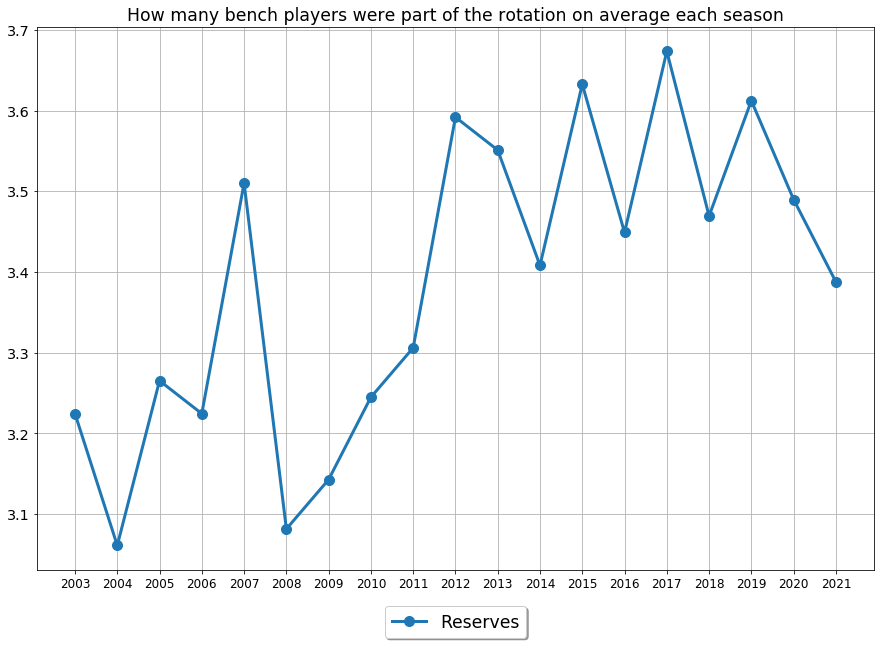

In [32]:
for stat in bench_avg_per_season:
    plt.figure(figsize=(15,10))
    plt.grid()
    plt.plot(SEASONS, bench_avg_per_season[stat], label="Reserves", lw=3, marker='o', ms=10)
    if stat != "Count":
        plt.plot(SEASONS, starter_avg_per_season[stat], label="Starters", lw=3, marker='o', ms=10)
    plt.xticks(SEASONS)
        
    if '/' in stat:
        stat = stat.replace('/', '_')
    plt.title(f"How many bench players were part of the rotation on average each season")
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=2)
    if stat == 'Count':
        plt.savefig(f"Results/DepthEvolution/{stat}_starters_and_reserves_each_season")
    plt.show()

# From now on, the analysys will focus on playoff stats

In [33]:
playoff_player_dfs = []

for season in SEASONS:
    playoff_player_df = get_playoff_csvs_by_season(season)
    playoff_player_dfs.append(playoff_player_df)
#     playoff_standings_dfs.append(playoff_standings_df)
    

In [34]:
bench_per_playoff = []

for i in range(len(SEASONS)):    
    df = playoff_player_dfs[i].sort_values(by=['Tm', 'GS'], ascending=[True, False])
    df.insert(len(df.columns), "Count", 0)
    cols = df.columns    
    bench = pd.DataFrame(columns = cols)
    for team in TEAMS:
        bench_players = pd.DataFrame(df[df["Tm"] == team][5:])
        bench_players = bench_players[bench_players["G"] >= 2]
        number_of_qualifying_reserves = bench_players.shape[0]
        bench_players = bench_players.mean()
        if number_of_qualifying_reserves > 0:
            bench_players["Count"] = number_of_qualifying_reserves
        bench.loc[team] = bench_players

    bench.drop(["Player", "Pos", "Tm"], axis=1, inplace=True)
    bench.dropna(how='all', inplace=True)
    bench.index.names = ["Team"]
    bench_per_playoff.append(bench)

In [35]:
bench_stats_playoffs = ['Age', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P',
       '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST',
       'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%',
       'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS',
       'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP', 'Count']

bench_avg_per_playoff = {}


for stat in bench_stats_playoffs:
    bench_avg_per_playoff[stat] = []
    for df in bench_per_playoff:
        bench_avg_per_playoff[stat].append(df[stat].mean())

In [36]:
starters_per_playoff = []

for i in range(len(SEASONS)):    
    df = playoff_player_dfs[i].sort_values(by=['Tm', 'GS'], ascending=[True, False])
    cols = df.columns    
    starters_df = pd.DataFrame(columns = cols)
    for team in TEAMS:
        starters = pd.DataFrame(df[df["Tm"] == team][:5])
        starters = starters.mean()
        starters_df.loc[team] = starters

    starters_df.drop(["Player", "Pos", "Tm"], axis=1, inplace=True)
    starters_df.dropna(how='all', inplace=True)
    starters_df.index.names = ["Team"]
    starters_per_playoff.append(starters_df)

In [37]:
starter_stats_playoffs = ['Age', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P',
       '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST',
       'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%',
       'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS',
       'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP']

starter_avg_per_playoff = {}


for stat in starter_stats_playoffs:
    starter_avg_per_playoff[stat] = []
    for df in starters_per_playoff:
        starter_avg_per_playoff[stat].append(df[stat].mean())

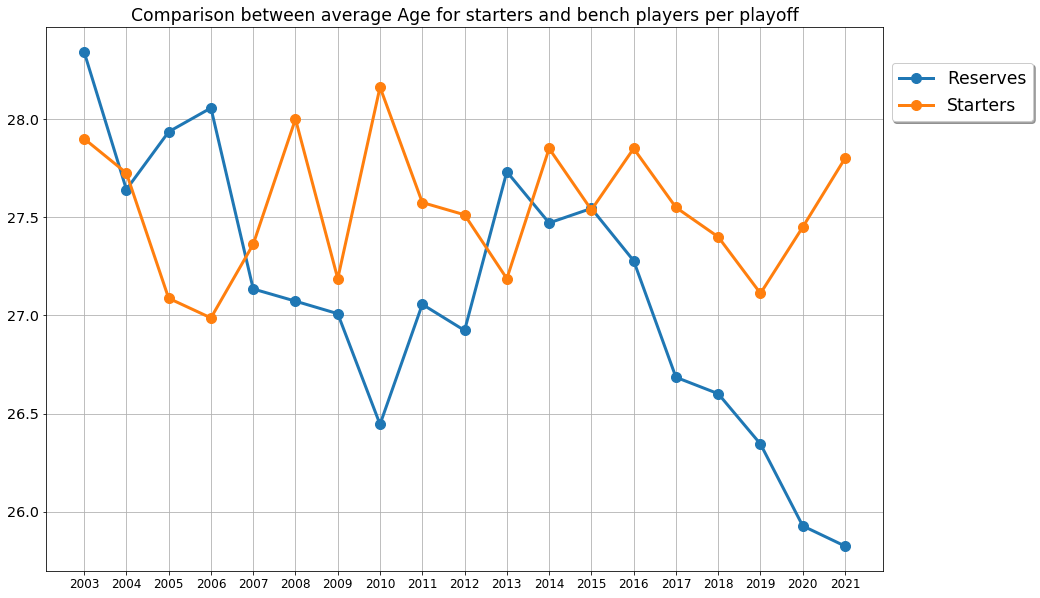

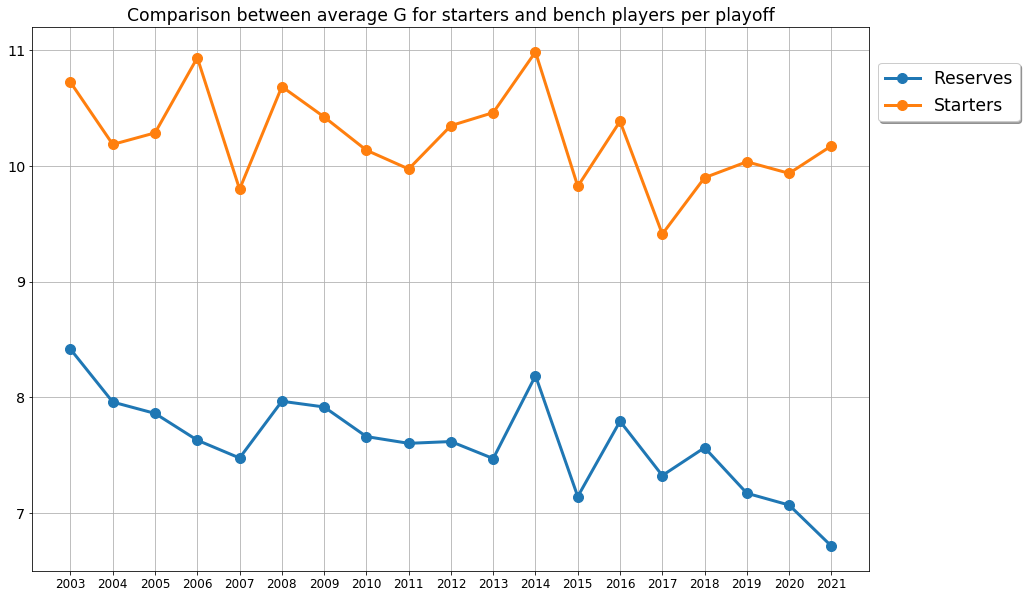

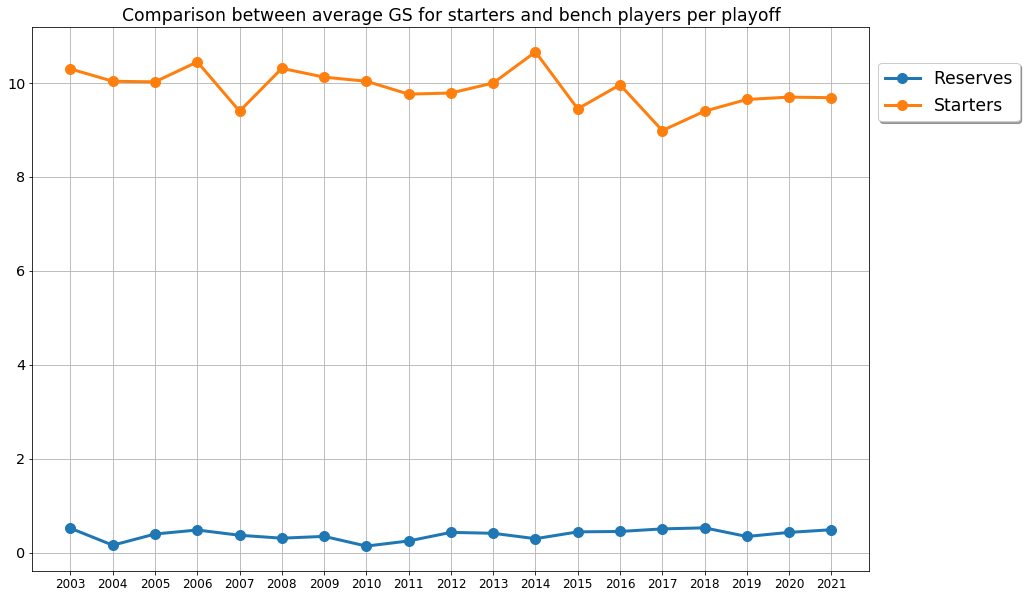

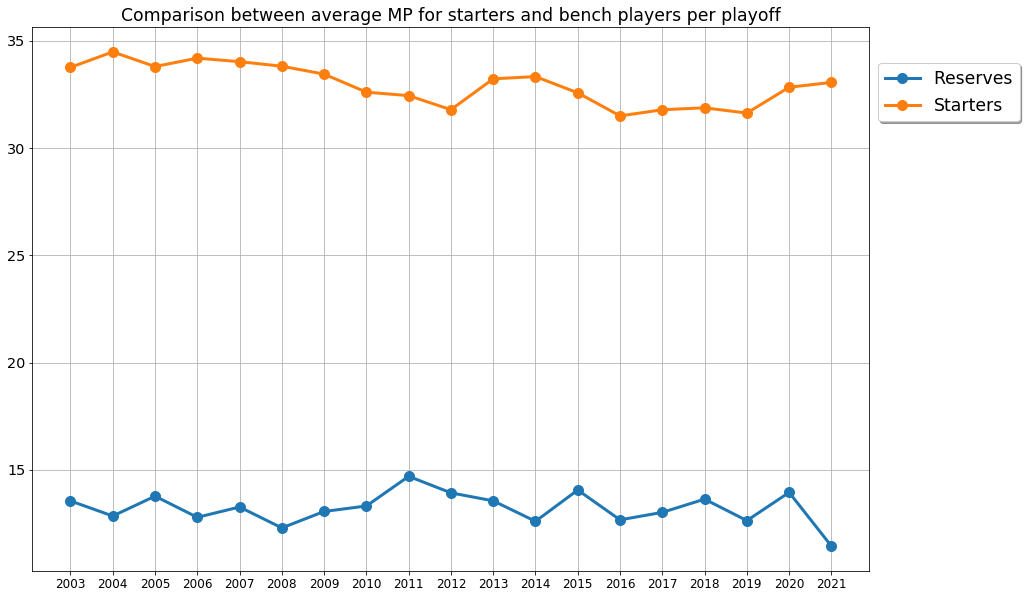

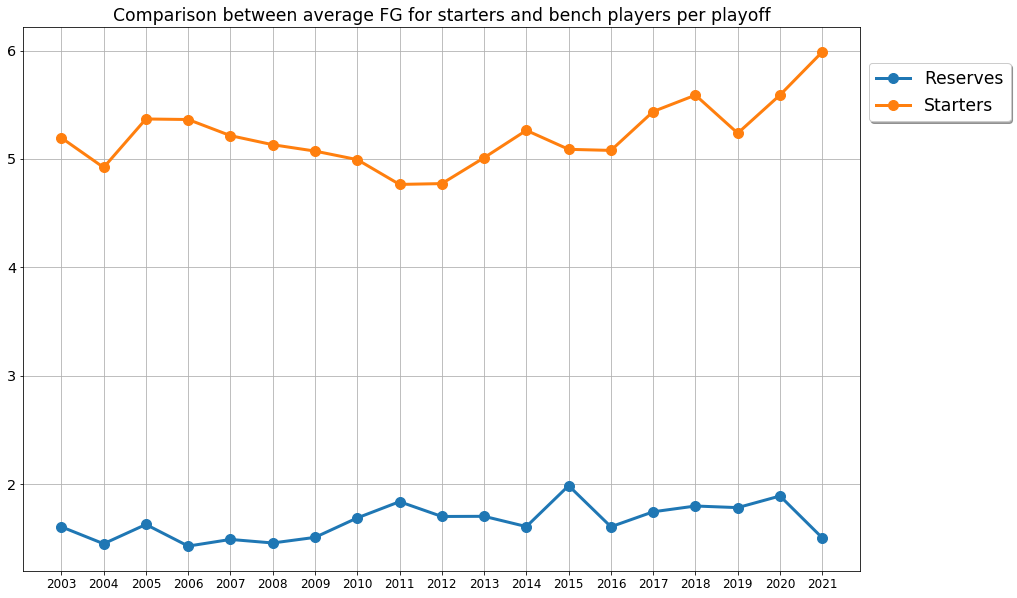

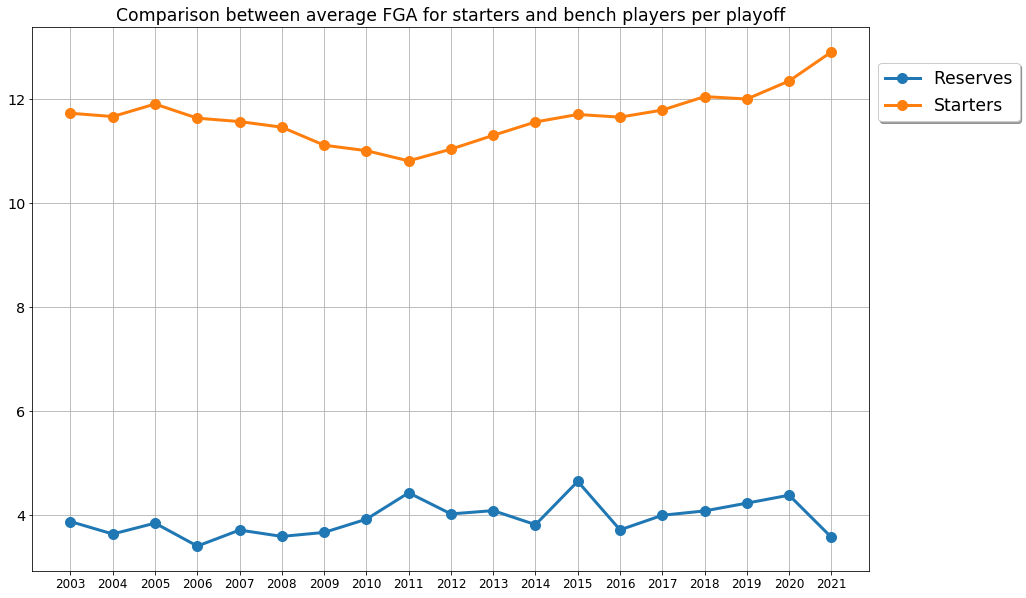

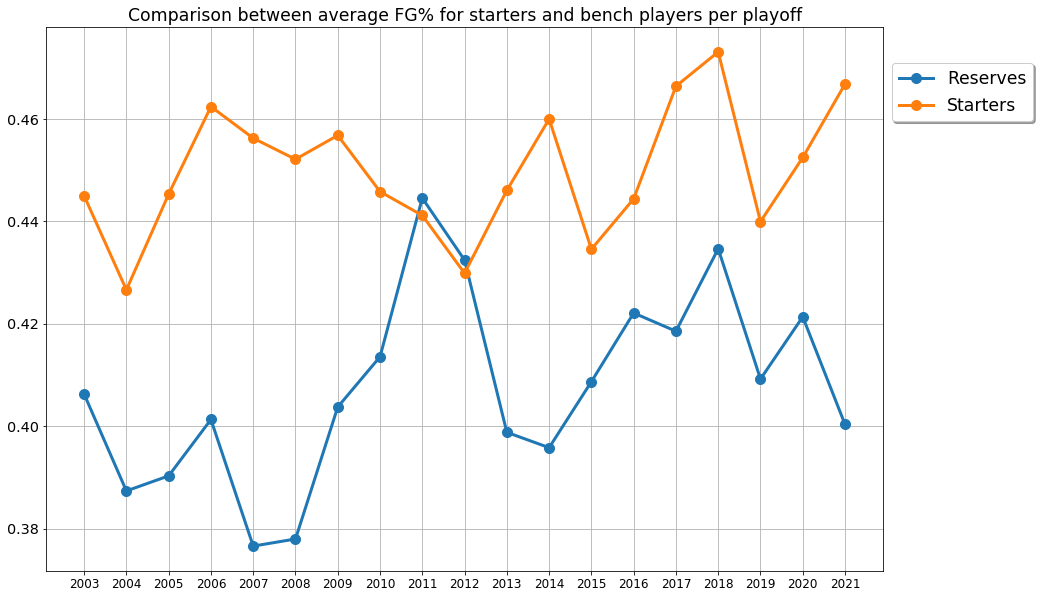

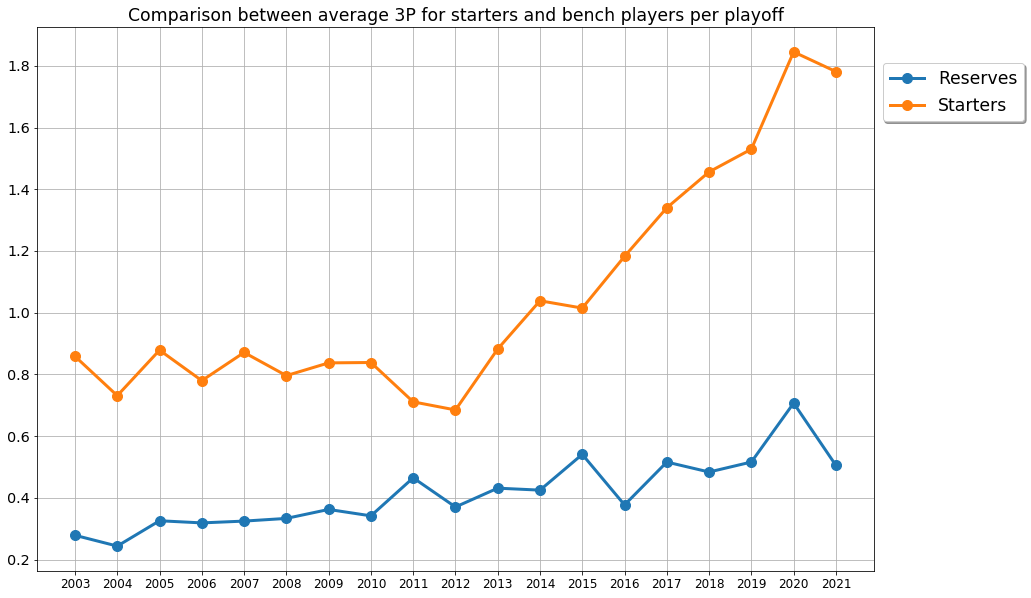

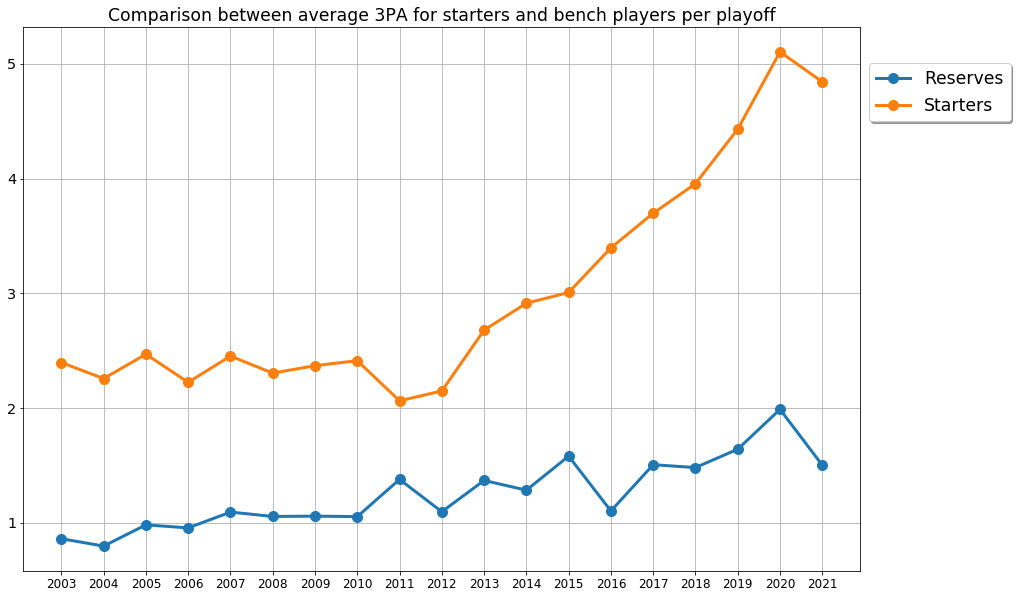

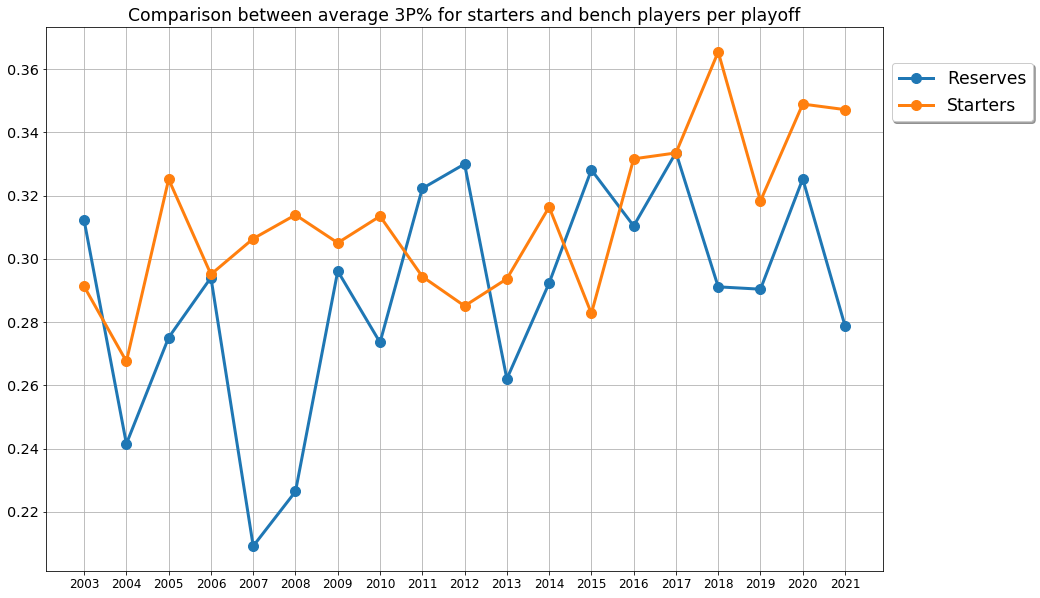

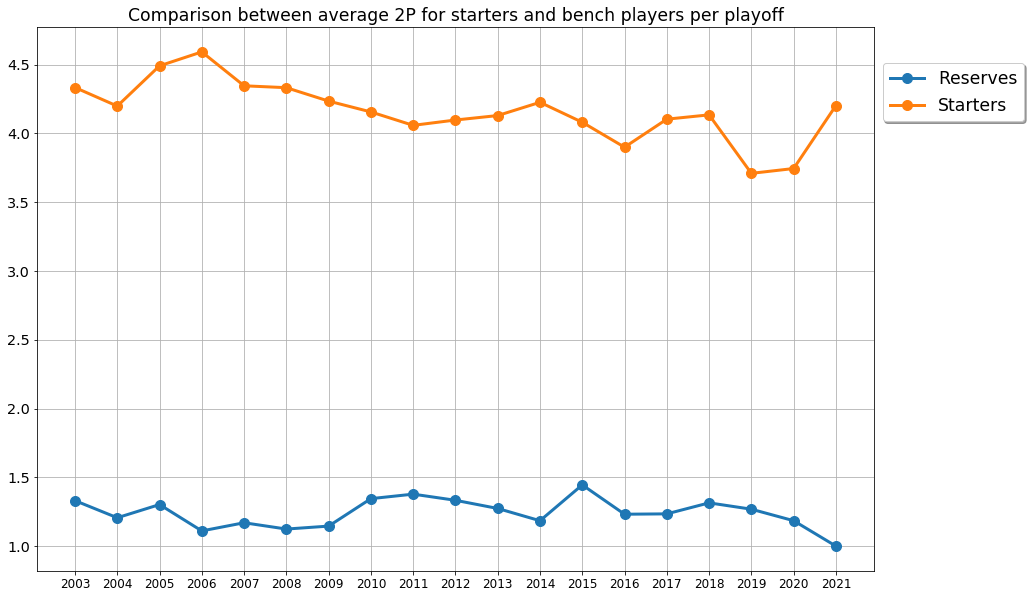

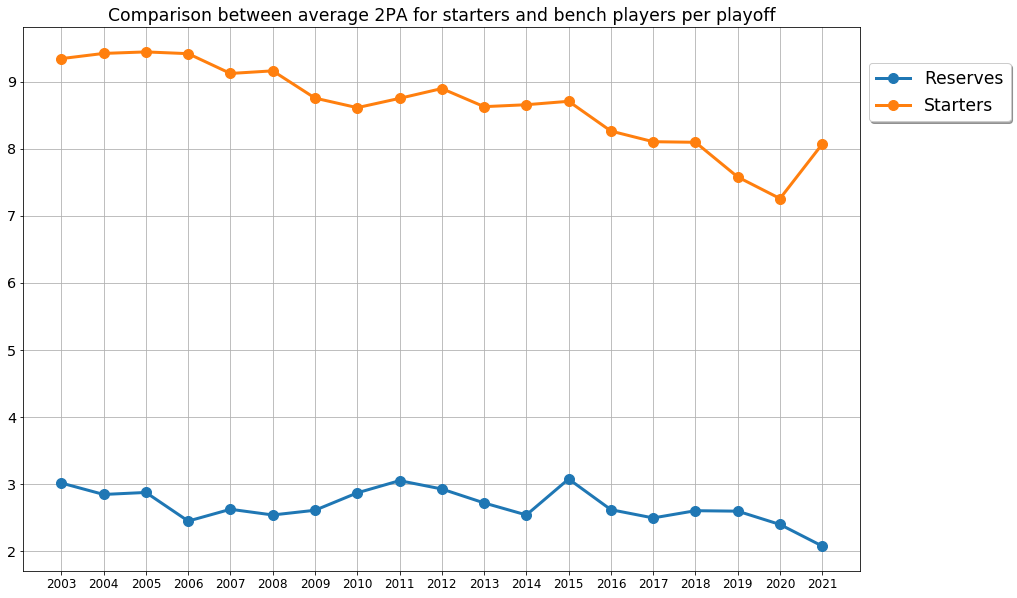

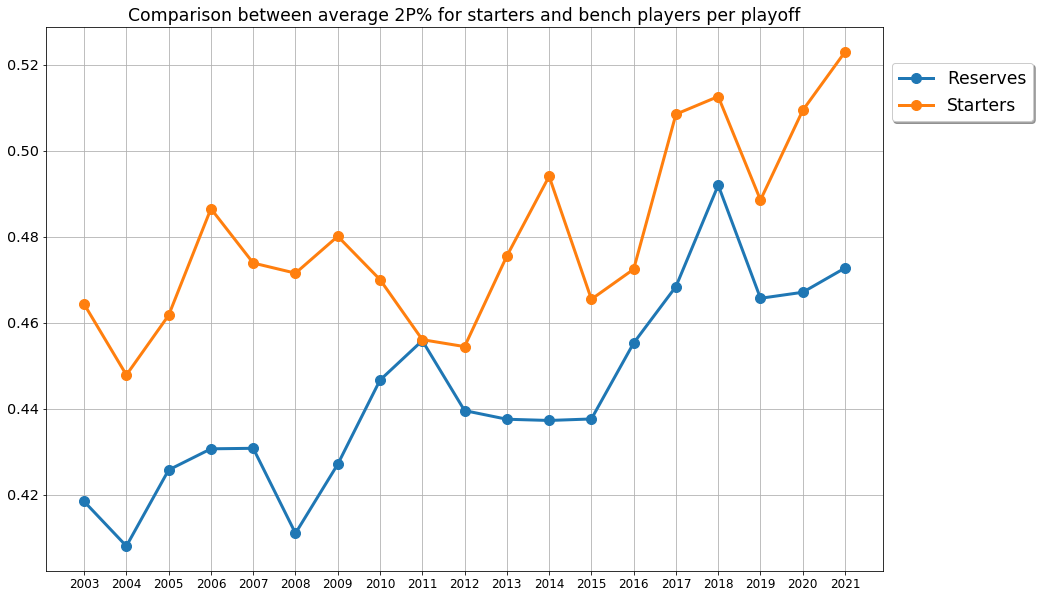

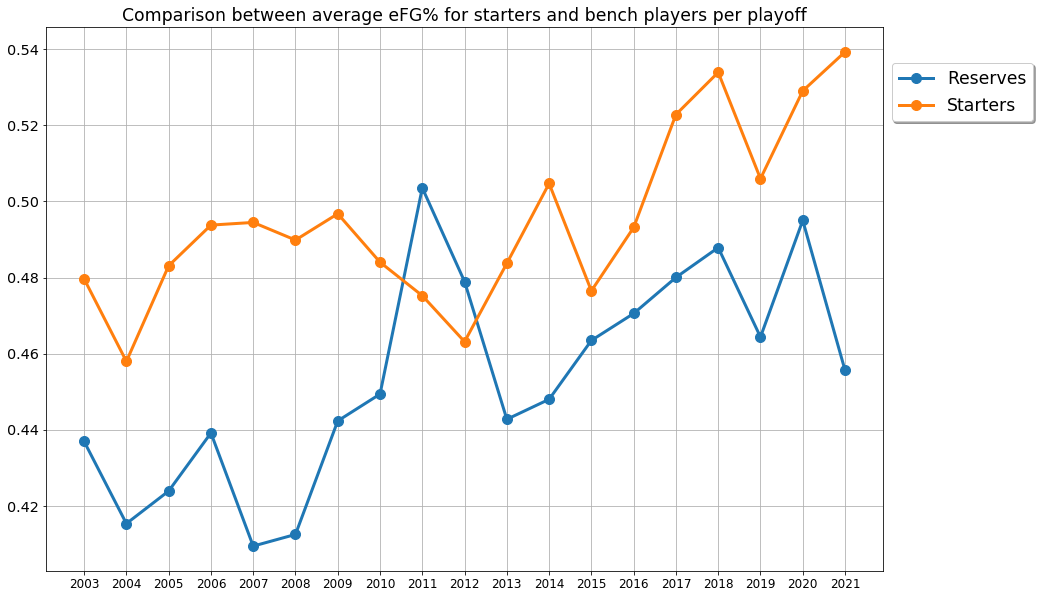

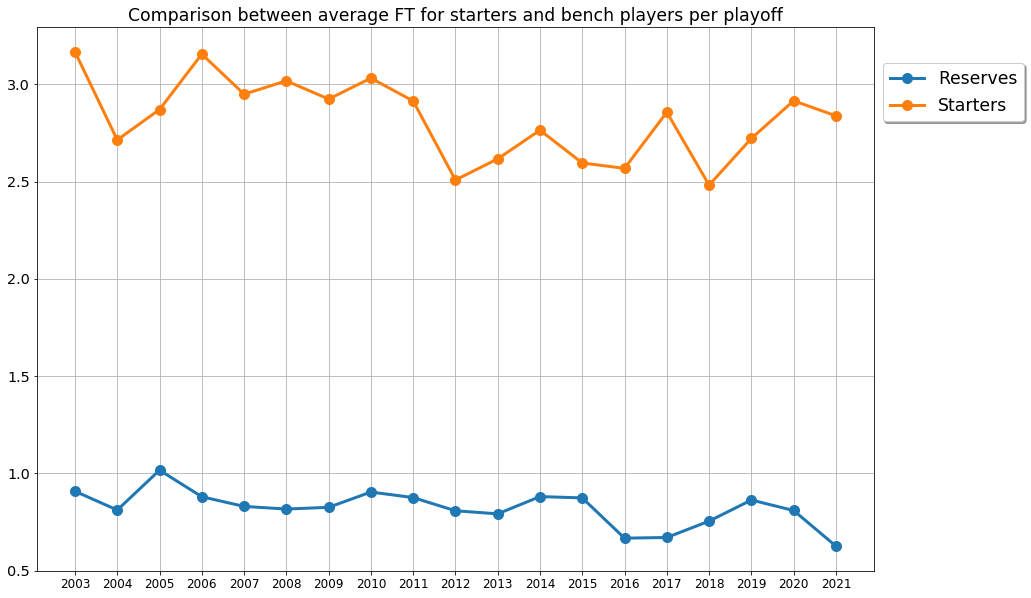

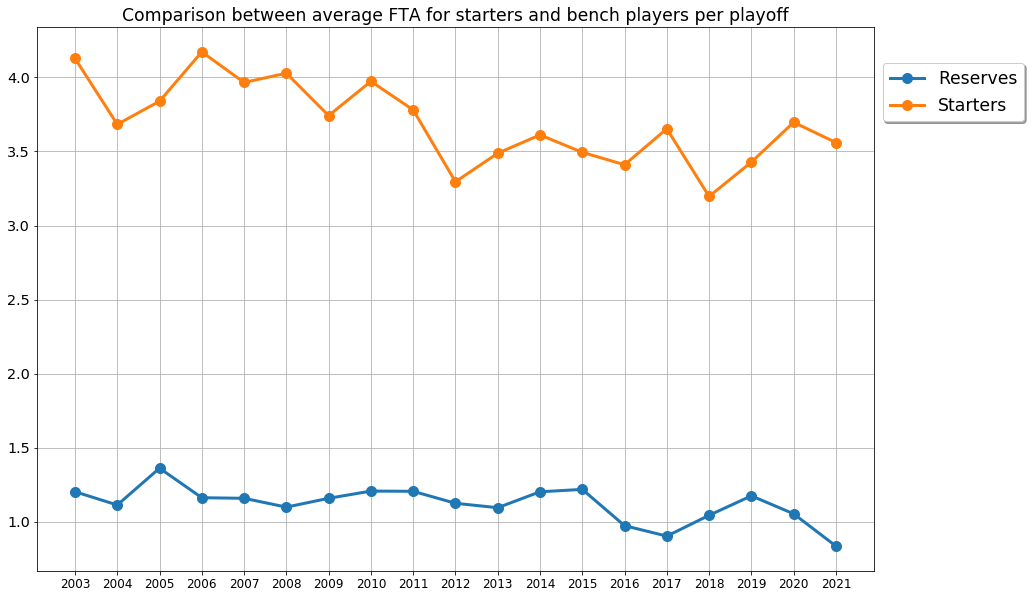

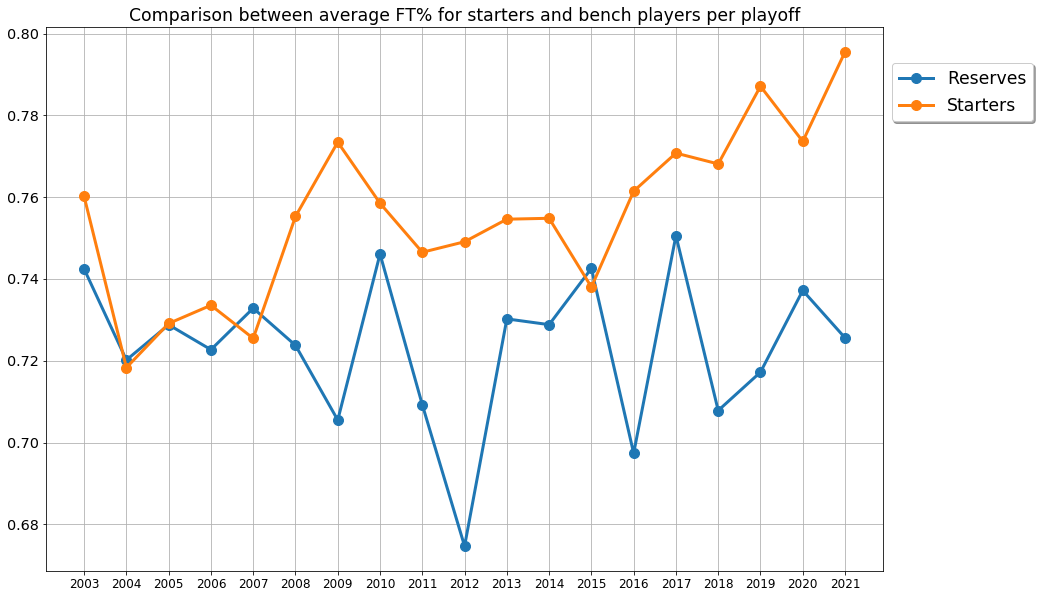

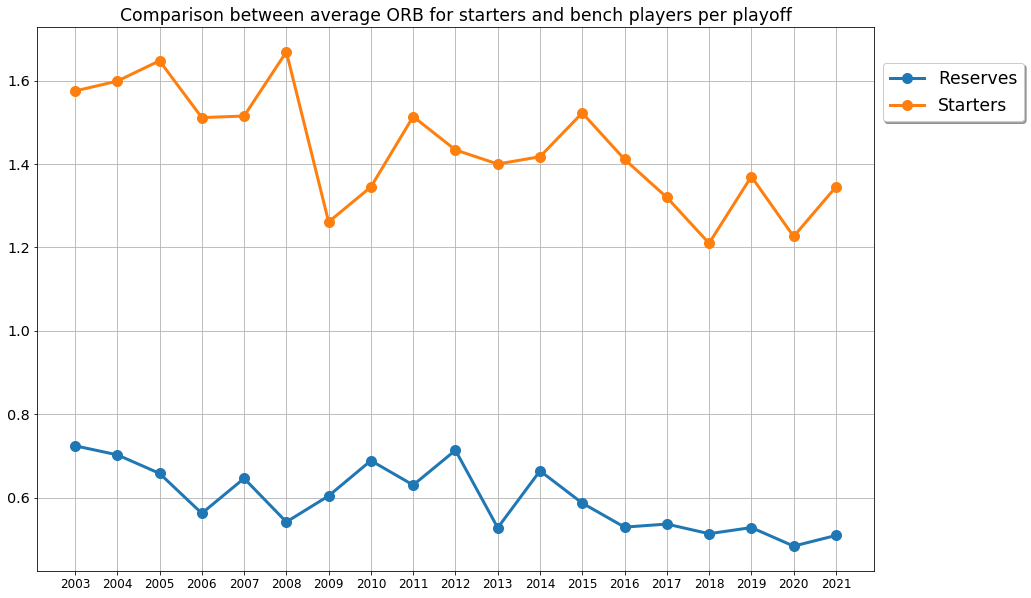

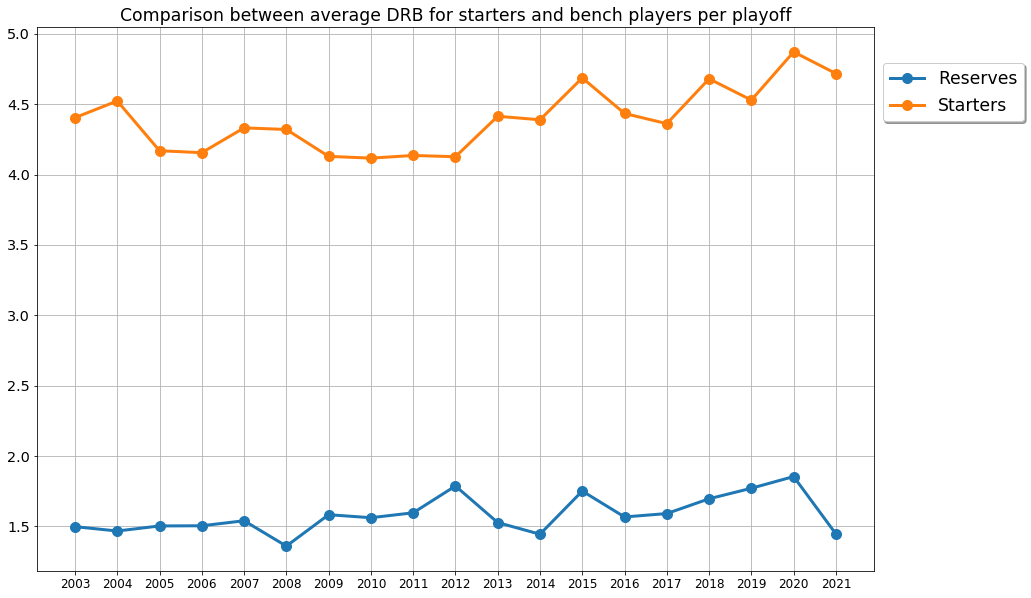

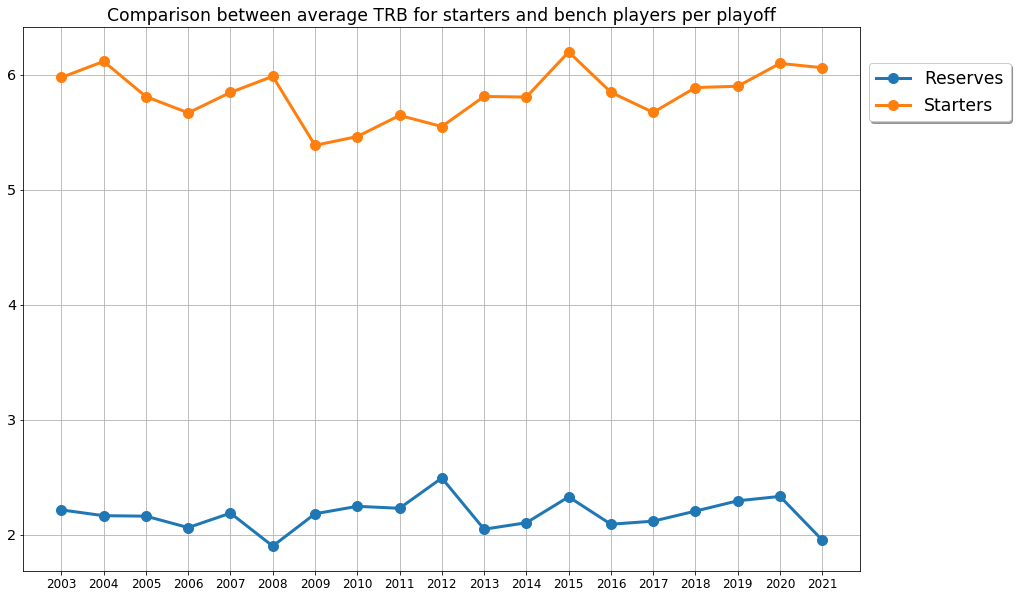

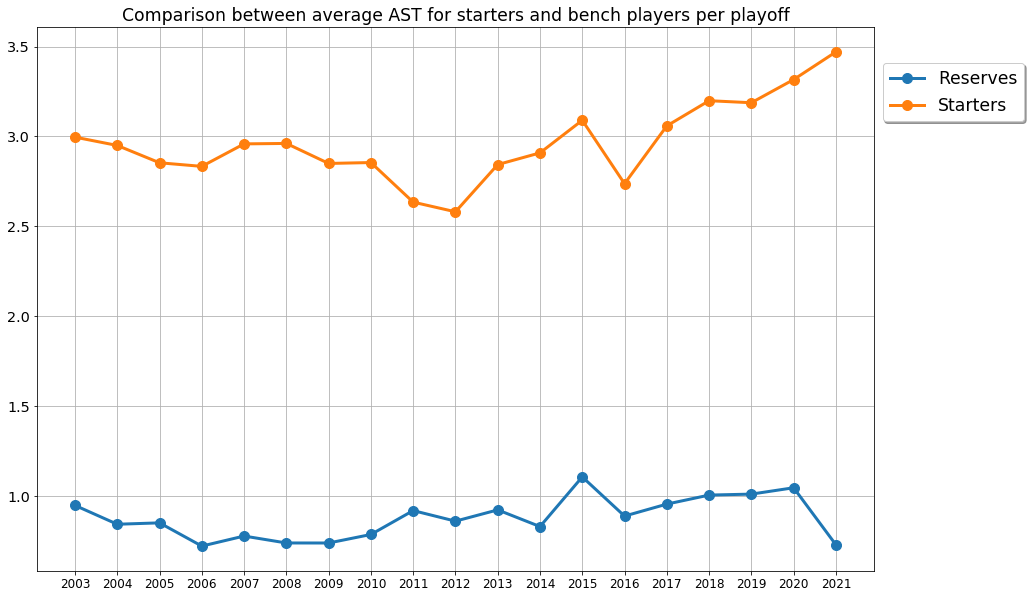

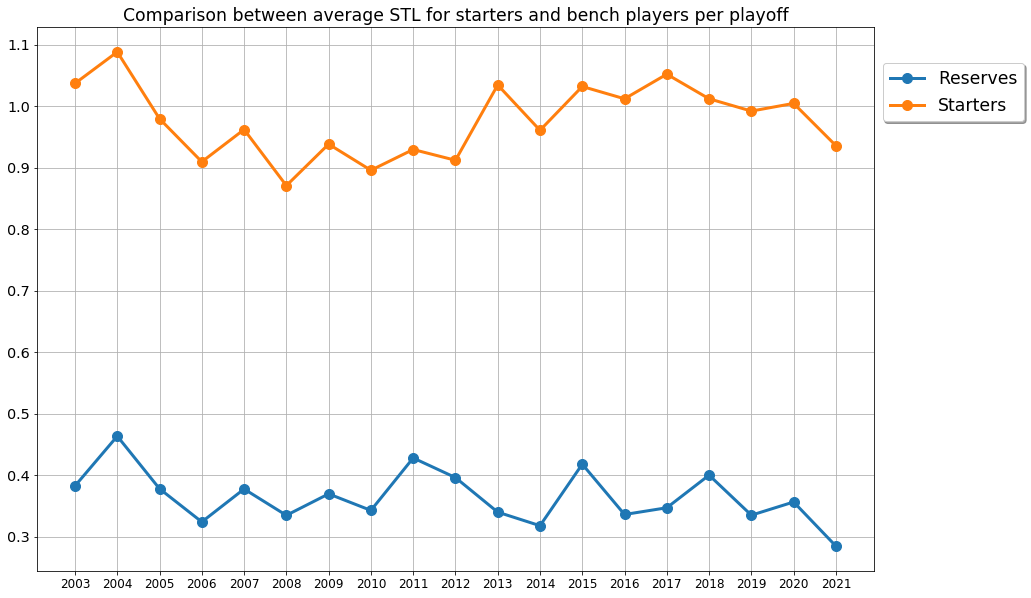

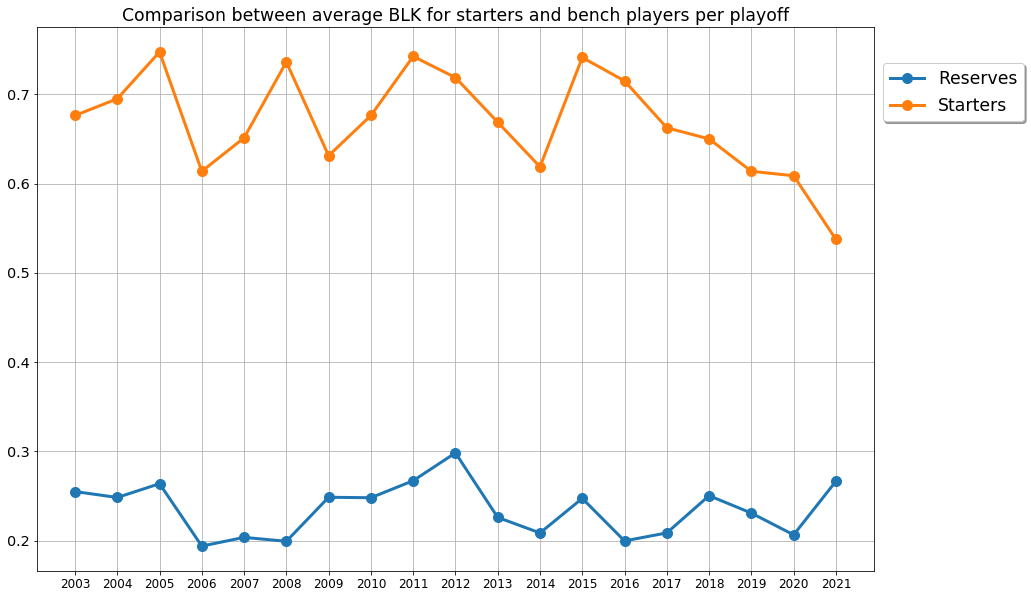

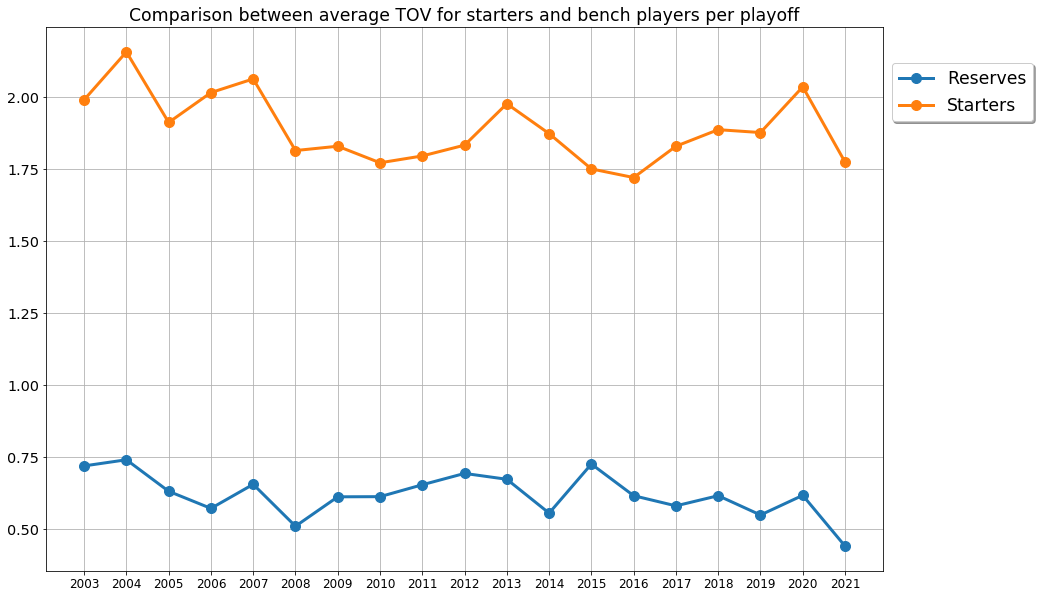

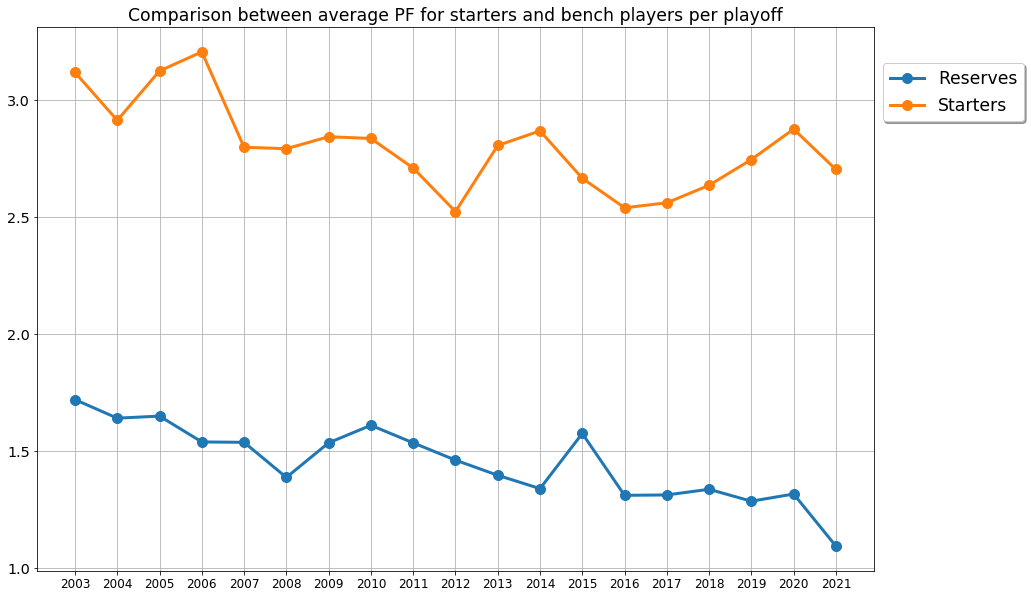

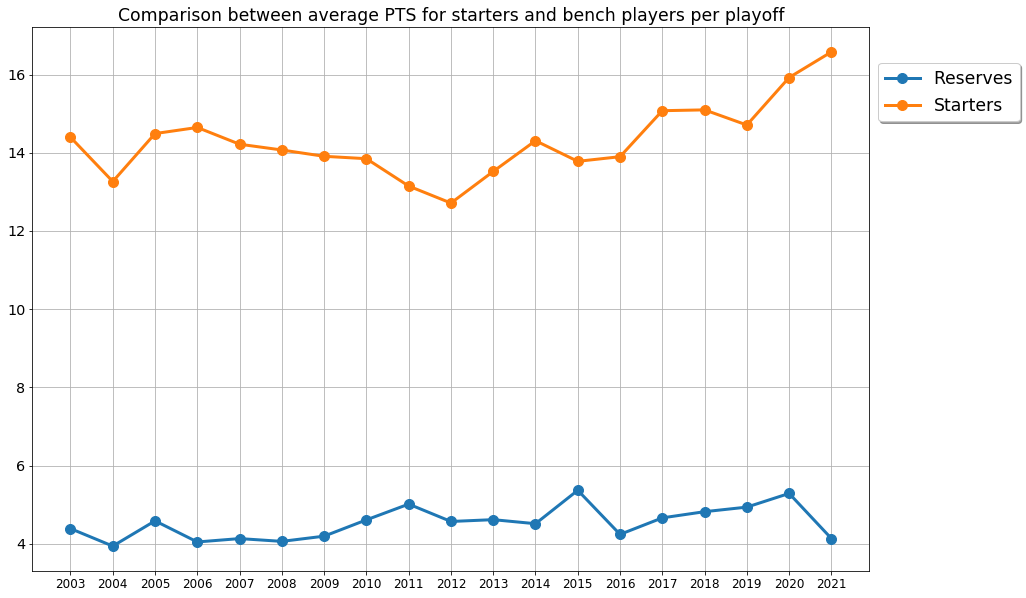

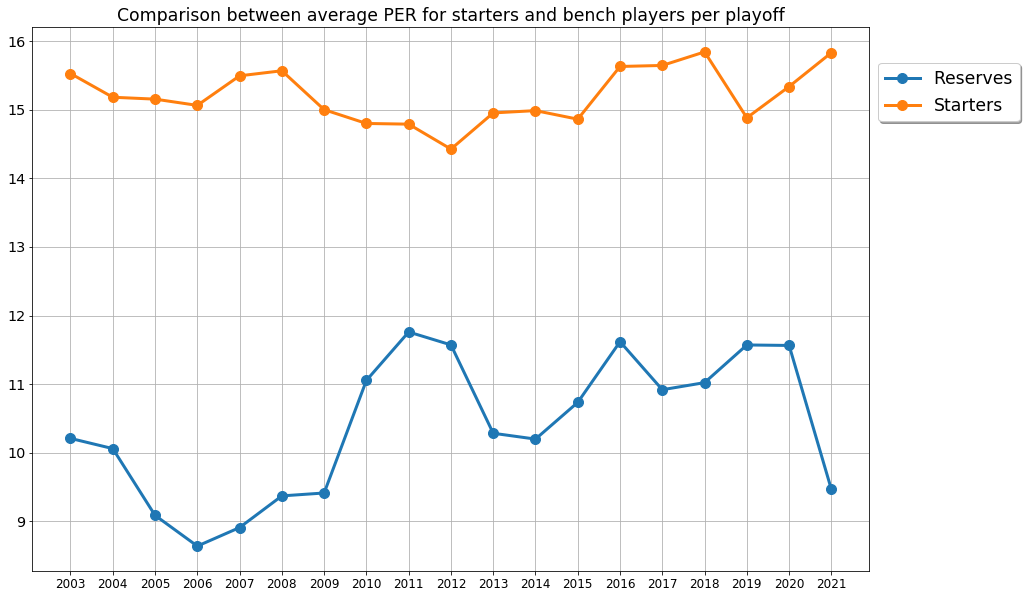

In [ ]:
for stat in bench_avg_per_playoff:
    plt.figure(figsize=(15,10))
    plt.grid()
    plt.plot(SEASONS, bench_avg_per_playoff[stat], label="Reserves", lw=3, marker='o', ms=10)
    if stat != "Count":
        plt.plot(SEASONS, starter_avg_per_playoff[stat], label="Starters", lw=3, marker='o', ms=10)
    plt.xticks(SEASONS)

    if '/' in stat:
        stat = stat.replace('/', '_')
    plt.title(f"Comparison between average {stat} for starters and bench players per playoff")
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 0.95),
          fancybox=True, shadow=True)
    plt.savefig(f"Results/DepthEvolution_Playoffs/{stat}_starters_and_reserves_each_playoff")
    plt.show()